In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
print(mpl.__version__)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from time import time
import uproot4 as up
from scipy.signal import find_peaks as fp
from scipy.fft import fft, ifft, fftfreq, fftshift
import scipy.signal as signal
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["font.size"] = 30
plt.rc('axes', titlesize=25, labelsize=25)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
xt = np.arange(0.5, 512., 1)
# %matplotlib

3.4.2


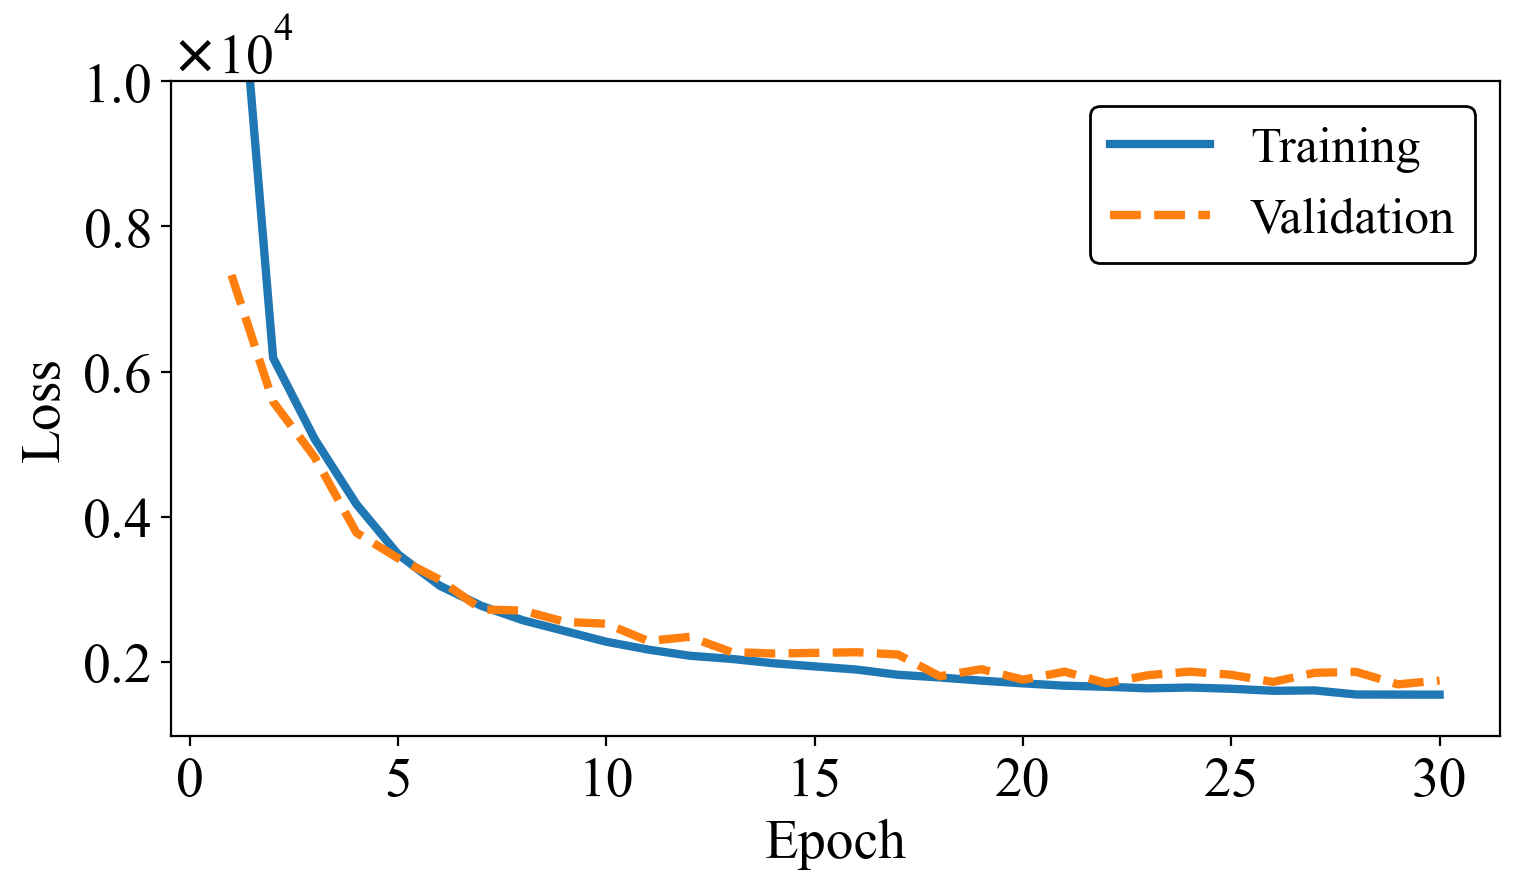

In [3]:
# df = pd.read_csv("./dados/DECONVCNN_SOURCE_TO_ONLY_BKG_ATTPC_2.csv")
# df = pd.read_csv("./dados/DECONVCNN_BKG_TO_DECONV_200_ATTPC.csv")
df = pd.read_csv("./dados/DECONVCNN_BKG_TO_DECONV_700.csv")
fonte = 20
fig = plt.figure(dpi = 200, figsize = (8, 4.85))
fig.patch.set_facecolor('white')
# plt.plot(np.arange(1, len(df) + 1, 1), df["loss"], lw = 3, label = "Training")
# plt.plot(np.arange(1, len(df) + 1, 1), df["val_loss"], ls = "--", lw = 3, label = "Validation")
plt.plot(np.arange(1, 30 + 1, 1), df["loss"][:30], lw = 3, label = "Training")
plt.plot(np.arange(1, 30 + 1, 1), df["val_loss"][:30], ls = "--", lw = 3, label = "Validation")
plt.xlabel("Epoch", fontsize = fonte)
plt.ylabel("Loss", fontsize = fonte)
fig.gca().set_ylim(top = 1.e4)
# scale_y = 1e3
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# fig.gca().yaxis.set_major_formatter(ticks_y)
plt.ticklabel_format(axis = "y", style = "sci", scilimits=(3, 4), useMathText = True)
# plt.title("loss x epoch")
plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black")
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2000))
# plt.yscale("log")
# plt.xscale("log")
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(2))
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
plt.tight_layout()
plt.savefig("loss_x_epoch.pdf", dpi = 600, bbox_inches='tight')
plt.show()

# Funções

In [3]:
def load_data_700():
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f = up.open("./dados/tspec_out_224_700.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    inputt        = [] # branches["input"].reshape(len(branches["input"]), 511)
    target1       = []
    target2       = [] # branches["target"].reshape(len(branches["input"]), 511)
    peaks         = []
    BKG           = []
    # scaled_deconv = []
    for i in range(len(branches["input"])):
        inputt.append(branches["input"][i].reshape(-1))
        target1.append(branches["inputBK"][i].reshape(-1))
        target2.append(branches["target"][i].reshape(-1))
        BKG.append(branches["fundo"][i].reshape(-1))
        peaks.append(branches["peaks"][i].astype(float).round().astype(int).reshape(-1))
    # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    inputt         = np.array(inputt, dtype = float)
    target1       = np.array(target1, dtype = float)
    target2       = np.array(target2, dtype = float)
    BKG           = np.array(BKG, dtype = float)
    peaks         = np.array(peaks, dtype = object)
    # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return inputt, target1, target2, peaks, BKG, target2*0.85

def load_data_BKGs():
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f  = up.open("./dados/tspec_out_224_700.root")
    f2 = up.open("./dados/signal_data.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    branches2     = f2[f2.keys()[0]].arrays(library = "np")
    inputt        = [] # branches["input"].reshape(len(branches["input"]), 511)
    target1       = []
    target2       = [] # branches["target"].reshape(len(branches["input"]), 511)
    peaks         = []
    BKG           = []
    # scaled_deconv = []
    for i in [1, 13]:
        inputt.append(branches["input"][i].reshape(-1))
        target1.append(branches["inputBK"][i].reshape(-1))
        target2.append(branches["target"][i].reshape(-1))
        BKG.append(branches["fundo"][i].reshape(-1))
        peaks.append(branches["peaks"][i].astype(float).round().astype(int).reshape(-1))
        # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    for i in [26, 65]:
        inputt.append(branches2["input"][i].reshape(-1))
        target1.append(branches2["input_sem_fundo"][i].reshape(-1))
        target2.append(branches2["deconv"][i].reshape(-1))
        BKG.append(branches2["fundo"][i].reshape(-1))
        peaks.append(branches2["picos"][i].astype(float).round().astype(int).reshape(-1))
        # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    inputt        = np.array(inputt, dtype = float)
    target1       = np.array(target1, dtype = float)
    target2       = np.array(target2, dtype = float)
    BKG           = np.array(BKG, dtype = float)
    peaks         = np.array(peaks, dtype = object)
  # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return inputt, target1, target2, peaks, BKG, target2*0.85

def load_data_DECONVs():
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f  = up.open("./dados/tspec_out_224_700.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    inputt        = [] # branches["input"].reshape(len(branches["input"]), 511)
    target1       = []
    target2       = [] # branches["target"].reshape(len(branches["input"]), 511)
    peaks         = []
    BKG           = []
    # scaled_deconv = []
    for i in [0, 2, 143, 148]:
        inputt.append(branches["input"][i].reshape(-1))
        target1.append(branches["inputBK"][i].reshape(-1))
        target2.append(branches["target"][i].reshape(-1))
        BKG.append(branches["fundo"][i].reshape(-1))
        peaks.append(branches["peaks"][i].astype(float).round().astype(int).reshape(-1))
        # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    inputt        = np.array(inputt, dtype = float)
    target1       = np.array(target1, dtype = float)
    target2       = np.array(target2, dtype = float)
    BKG           = np.array(BKG, dtype = float)
    peaks         = np.array(peaks, dtype = object)
  # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return inputt, target1, target2, peaks, BKG, target2*0.85

def load_data_700_attpc():
    # Na verdade foram 200 it com sigma = 5.
    ti  = time()
    # f = up.open("/content/drive/MyDrive/Collabs/tspec_out_192_3.root")
    f = up.open("./dados/signal_data.root")
    branches      = f[f.keys()[0]].arrays(library = "np")
    input         = [] # branches["input"].reshape(len(branches["input"]), 511)
    fundos        = []
    input_wo_bkg  = [] # branches["target"].reshape(len(branches["input"]), 511)
    deconv        = []
    BKG           = []
    peaks         = []
    # scaled_deconv = []
    pads = np.zeros(200_000, dtype = int)
    # for i in range(len(branches["input"])):
    for i in range(200_000):
        input.append(branches["input"][i].reshape(-1))
        fundos.append(branches["fundo"][i].reshape(-1))
        input_wo_bkg.append(branches["input_sem_fundo"][i].reshape(-1))
        deconv.append(branches["deconv"][i].reshape(-1))
        peaks.append(branches["picos"][i].astype(float).round().astype(int).reshape(-1))
        pads[i] = branches["pad"][i]
    # scaled_deconv.append(branches["deconv_scale"][i].reshape(-1))
    input         = np.array(input, dtype = float)
    fundos        = np.array(fundos, dtype = float)
    input_wo_bkg  = np.array(input_wo_bkg, dtype = float)
    deconv        = np.array(deconv, dtype = float)
    peaks         = np.array(peaks, dtype = object)
    # scaled_deconv = np.array(scaled_deconv, dtype = float)
    f.close()
    print("Tempo para carregar dados = %.3fs"%(time() - ti))
    return input, input_wo_bkg, deconv, peaks, fundos, deconv*0.85, pads

def return_predict_bkg_deconv_pat():
    return np.load("./dados/BKG_predict_pat.npy", allow_pickle = True), np.load("./dados/DECONV_predict_pat.npy", allow_pickle = True)

def return_predict_bkgs():
    indices = np.array([1, 13], dtype = int)
    a = np.load("./dados/BKG_predict_pat.npy", allow_pickle = True)[indices]
    indices = np.array([26, 65], dtype = int)
    b = np.load("./dados/BKG_predict_at.npy", allow_pickle = True)[indices]
    return np.vstack((a, b))

def return_predict_deconvs():
    indices = np.array([0, 2, 143, 148], dtype = int)
    a = np.load("./dados/DECONV_predict_pat.npy", allow_pickle = True)[indices]
    # indices = np.array([26, 65], dtype = int)
    # b = np.load("./dados/DECONV_predict_at.npy", allow_pickle = True)[indices]
    return a

def return_predict_bkg_deconv_at():
    return np.load("./dados/BKG_predict_at.npy", allow_pickle = True), np.load("./dados/DECONV_predict_at.npy", allow_pickle = True)

def construct_target_n_peaks_img(peaks_index, min_peak:int = 1, max_peak:int = 6, extra_points:int = 3):
    peaks   = []
    # weigths = []
    # FIXED   = np.array([0.2]*512, dtype = float)
    tams = np.array([len(a) for a in peaks_index], dtype = int)
    index   = np.where((tams >= min_peak) & (tams <= max_peak))[0]
    print(index.shape)
    for i in index:
        partial   = np.zeros(512, dtype = int)
        # positions = peaks_index[i].astype(float).round().astype(int)
        positions = fp(y2_scaled[i].reshape(-1), height = 50., distance = 4, prominence = 4)[0]
        for pos in positions:
            if pos < 508: 
                poss    = np.arange(pos - extra_points, pos + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            elif pos == 511:
                # poss    = np.arange(pos - 3, pos + 4, 1).astype(int)
                partial[np.arange(pos - extra_points, pos + 1, 1).astype(int)] = 1
            else:
                poss    = np.arange(pos - extra_points, (511 - pos) + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            partial[pos] = 0
    # w = np.copy(FIXED)
    # w[loc.astype(int)] = 0.8
    # weigths.append(w)
        peaks.append(partial)
    peaks   = np.array(peaks, dtype = int)
    # weigths = np.array(weigths, dtype = int)
    return peaks, index

def construct_target_n_peaks_img(peaks_index, min_peak:int = 1, max_peak:int = 6, extra_points:int = 3):
    peaks   = []
    # weigths = []
    # FIXED   = np.array([0.2]*512, dtype = float)
    tams = np.array([len(a) for a in peaks_index], dtype = int)
    index   = np.where((tams >= min_peak) & (tams <= max_peak))[0]
    print(index.shape)
    for i in index:
        partial   = np.zeros(512, dtype = int)
        # positions = peaks_index[i].astype(float).round().astype(int)
        positions = fp(y2_scaled[i].reshape(-1), height = 50., distance = 4, prominence = 4)[0]
        for pos in positions:
            if pos < 508: 
                poss    = np.arange(pos - extra_points, pos + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            elif pos == 511:
                # poss    = np.arange(pos - 3, pos + 4, 1).astype(int)
                partial[np.arange(pos - extra_points, pos + 1, 1).astype(int)] = 1
            else:
                poss    = np.arange(pos - extra_points, (511 - pos) + extra_points + 1, 1).astype(int)
                partial[poss] = 1
            partial[pos] = 0
    # w = np.copy(FIXED)
    # w[loc.astype(int)] = 0.8
    # weigths.append(w)
        peaks.append(partial)
    peaks   = np.array(peaks, dtype = int)
    # weigths = np.array(weigths, dtype = int)
    return peaks, index

def construct_target_n_peak_img(positions, extra_points: int = 2):
    partial   = np.zeros(512, dtype = int)
    # positions = peaks_index[i].astype(float).round().astype(int)
    for pos in positions:
        if pos < 508: 
            poss    = np.arange(pos - extra_points, pos + extra_points + 1, 1).astype(int)
            partial[poss] = 1
        elif pos == 511:
            # poss    = np.arange(pos - 3, pos + 4, 1).astype(int)
            partial[np.arange(pos - extra_points, pos + 1, 1).astype(int)] = 1
        else:
            poss    = np.arange(pos - extra_points, (511 - pos) + extra_points + 1, 1).astype(int)
            partial[poss] = 1
        partial[pos] = 0
    return partial

# Carregamento de dados

In [4]:
x1, y1, y2, peaksDeconv, BKG, y2_scaled = load_data_700()
# predict_bkg, predict_decv = return_predict_bkg_deconv_pat()
# x1, y1, y2, peaksDeconv, BKG, y2_scaled, pads = load_data_700_attpc()
# predict_bkg, predict_decv = return_predict_bkg_deconv_at()
# x1, _, _, _, BKG, _ = load_data_BKGs()
# predict_bkg = return_predict_bkgs()
# _, y1, _, _, _, _ = load_data_DECONVs()
# predict_decov = return_predict_deconvs()
# with np.load("artigo_bkg.npz") as f:
#     x1 = f["x1"]
#     BKG = f["BKG"]
#     predict_bkg = f["predict_bkg"]
# with np.load("artigo_dcv.npz") as f:
#     y1 = f["y1"]
#     predict_deconv = f["predict_decov"]


Tempo para carregar dados = 60.730s


In [9]:
# np.savez("artigo_dcv.npz", y1 = y1, predict_decov = predict_decov)

In [288]:
# gen = (i for i in range(100, len(x1)))
# print(gen)

<generator object <genexpr> at 0x0000020291942C10>


# Artigo

## CNN Fundo

Saída num = 1
['Raw signal', 'CNN']
300.0 715.05


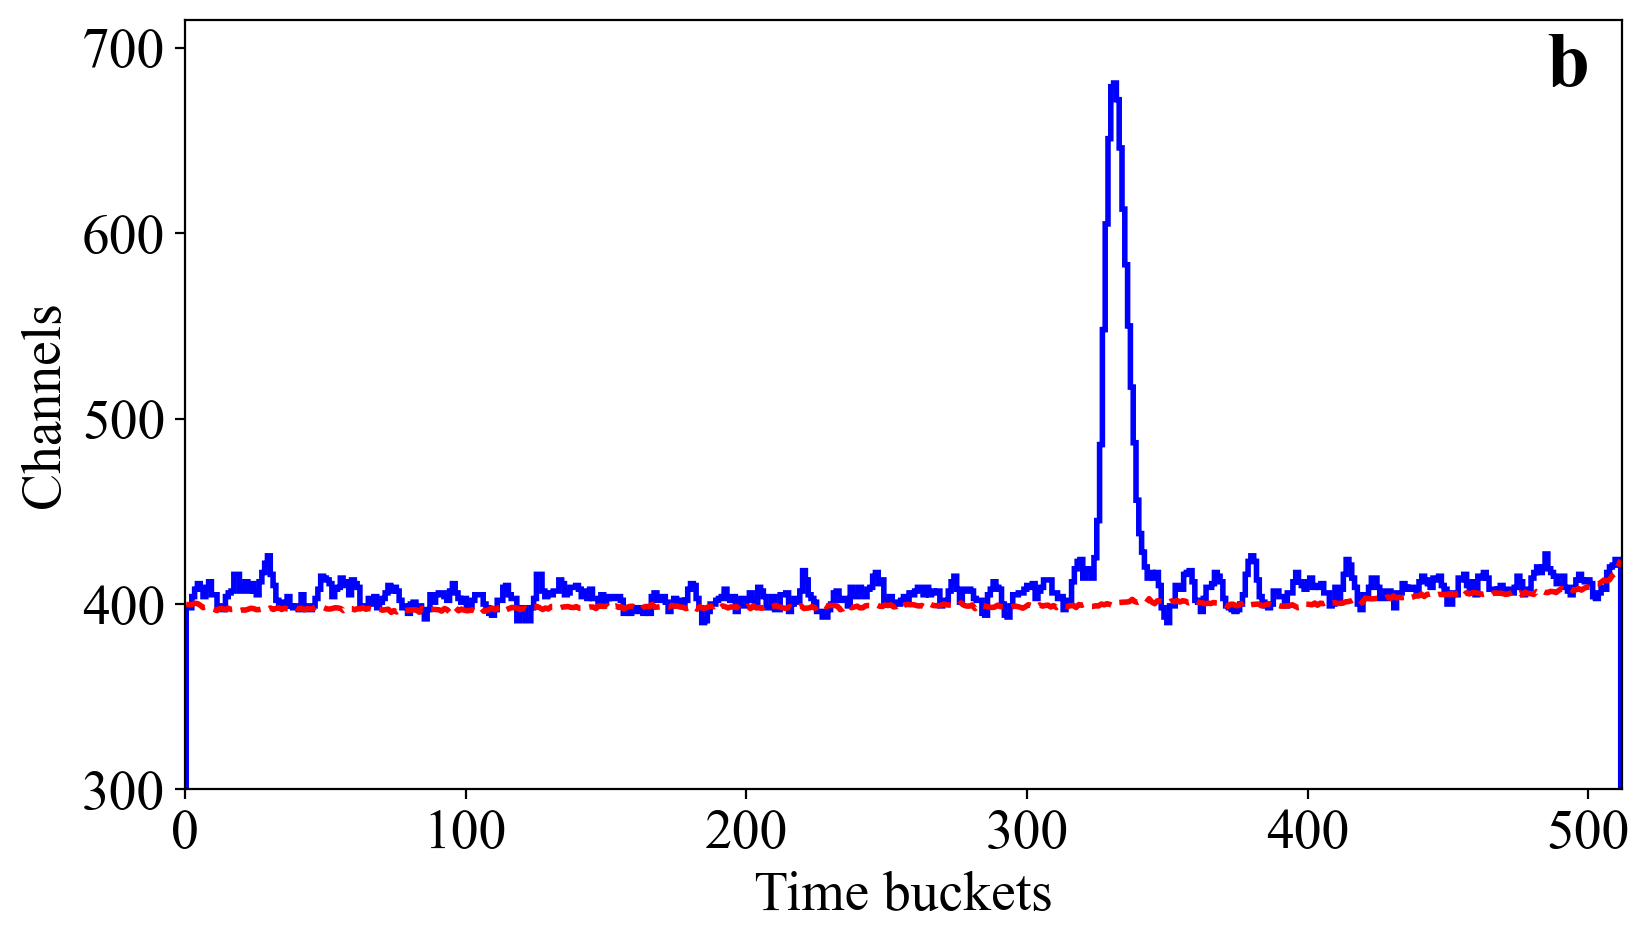

In [27]:
xt = np.arange(0.5, 512, 1)
fonte = 20
d = {1 : "a", 13 : "b", 26 : "c", 65 : "d"}
index = {1 : 0, 13 : 1, 26 : 2, 65 : 3}
# d = {0 : "a", 2 : "b", 143 : "c", 148 : "d"}
# num = np.random.randint(low = 0, high = len(predictions), size = 1)[0]
# num = next(gen)
num1 = 1
num  = index[num1]
print(f"Saída num = {num}")
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal")
# plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal w/o baseline", alpha = 0.75)
# plt.plot(xt, BKG[num], lw = 2, c = "green", label = "Correto")
plt.plot(xt, predict_bkg[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "CNN")
# plt.plot(xt, predict_decv[num].reshape(-1)/0.85, lw = 2, ls = "--", c = "red", label = "CNN")
# plt.axhline(y = 50., ls = (0, (3, 1, 1, 1, 1, 1)), lw = 2., c = "black", zorder = 0, label = "Threshold")
handles, labels = plt.gca().get_legend_handles_labels()
# labels.reverse()
# handles.reverse()
# labels2  = [labels[2], labels[1], labels[0], labels[3]]
# handles2 = [handles[2], handles[1], handles[0], handles[3]]
by_label = dict(zip(labels, handles))
print(list(by_label.keys()))
nomes_1 = list(by_label.keys())
lines_1 = list(by_label.values())
nomes = [nomes_1[1], nomes_1[0]]
lines = [lines_1[1], lines_1[0]]
# plt.legend(fontsize = fonte - 3, framealpha = 1., edgecolor = "black", loc = 2)
plt.legend(lines, nomes, fontsize = fonte - 3., framealpha = 1., edgecolor = "black", loc = 2)
plt.tight_layout()
plt.xlabel("Time buckets", fontsize = fonte)
plt.ylabel("ADC Channels", fontsize = fonte)
# plt.title(num)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
fig.gca().set_ylim(bottom = 300)
# fig.gca().set_ylim(bottom = 0, top = 900)
fig.gca().set_xlim(left = 0, right = 512)
bottom, top = plt.ylim()
print(bottom, top)
plt.text(485, (top)*0.95, d[num1], fontsize = 28, weight='bold')
plt.savefig(f"imagens/stb_{num}.png", dpi = 600, bbox_inches='tight')
# plt.savefig(f"imagens/final_bkg_{num}.png", dpi = 600, bbox_inches='tight')
# plt.savefig(f"imagens/final_deconv_pat_{num}.png", dpi = 600, bbox_inches='tight')
plt.show()

# Usados artigo = pat 1, pat 13, at 26, at 65

# at
# Talvez = 8, 9, 12, 14, 26, 56, 65

# Talvez = 0, 1, 8, 11, 12, 23, 55, 56
# Usados = 1, 11, 12

## CNN Deconvolução

In [ ]:
xt = np.arange(0.5, 512, 1)
fonte = 20
# d = {1 : "a", 13 : "b", 26 : "c", 65 : "d"}
d = {0 : "a", 2 : "b", 143 : "c", 148 : "d"}
# num = np.random.randint(low = 0, high = len(predictions), size = 1)[0]
# num = next(gen)
num = 148
print(f"Saída num = {num}")
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal")
plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal w/o baseline", alpha = 0.75)
# plt.plot(xt, BKG[num], lw = 2, c = "green", label = "Correto")
# plt.plot(xt, predict_bkg[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "CNN")
plt.plot(xt, predict_decv[num].reshape(-1)/0.85, lw = 2, ls = "--", c = "red", label = "CNN")
plt.axhline(y = 50., ls = (0, (3, 1, 1, 1, 1, 1)), lw = 2., c = "black", zorder = 0, label = "Threshold")
handles, labels = plt.gca().get_legend_handles_labels()
# labels.reverse()
# handles.reverse()
# labels2  = [labels[2], labels[1], labels[0], labels[3]]
# handles2 = [handles[2], handles[1], handles[0], handles[3]]
by_label = dict(zip(labels, handles))
print(list(by_label.keys()))
nomes_1 = list(by_label.keys())
lines_1 = list(by_label.values())
nomes = [nomes_1[1], nomes_1[0], nomes_1[2]]
lines = [lines_1[1], lines_1[0], lines_1[2]]
# plt.legend(fontsize = fonte - 3, framealpha = 1., edgecolor = "black", loc = 2)
# plt.legend(lines, nomes, fontsize = fonte - 3., framealpha = 1., edgecolor = "black", loc = 2)
plt.tight_layout()
plt.xlabel("Time buckets", fontsize = fonte)
plt.ylabel("ADC Channels", fontsize = fonte)
# plt.title(num)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
fig.gca().set_ylim(bottom = 0)
# fig.gca().set_ylim(bottom = 0, top = 900)
fig.gca().set_xlim(left = 0, right = 512)
bottom, top = plt.ylim()
plt.text(485, (top-bottom)*0.9, d[num], fontsize = 28, weight='bold')
# plt.savefig(f"imagens/final_bkg_pat_{num}.png", dpi = 600, bbox_inches='tight')
# plt.savefig(f"imagens/final_deconv_pat_{num}.png", dpi = 600, bbox_inches='tight')
plt.show()

## CNN Segmentação

Saída num = 148
['Integral', 'Detected centroid', 'CNN', 'Raw signal w/o baseline']


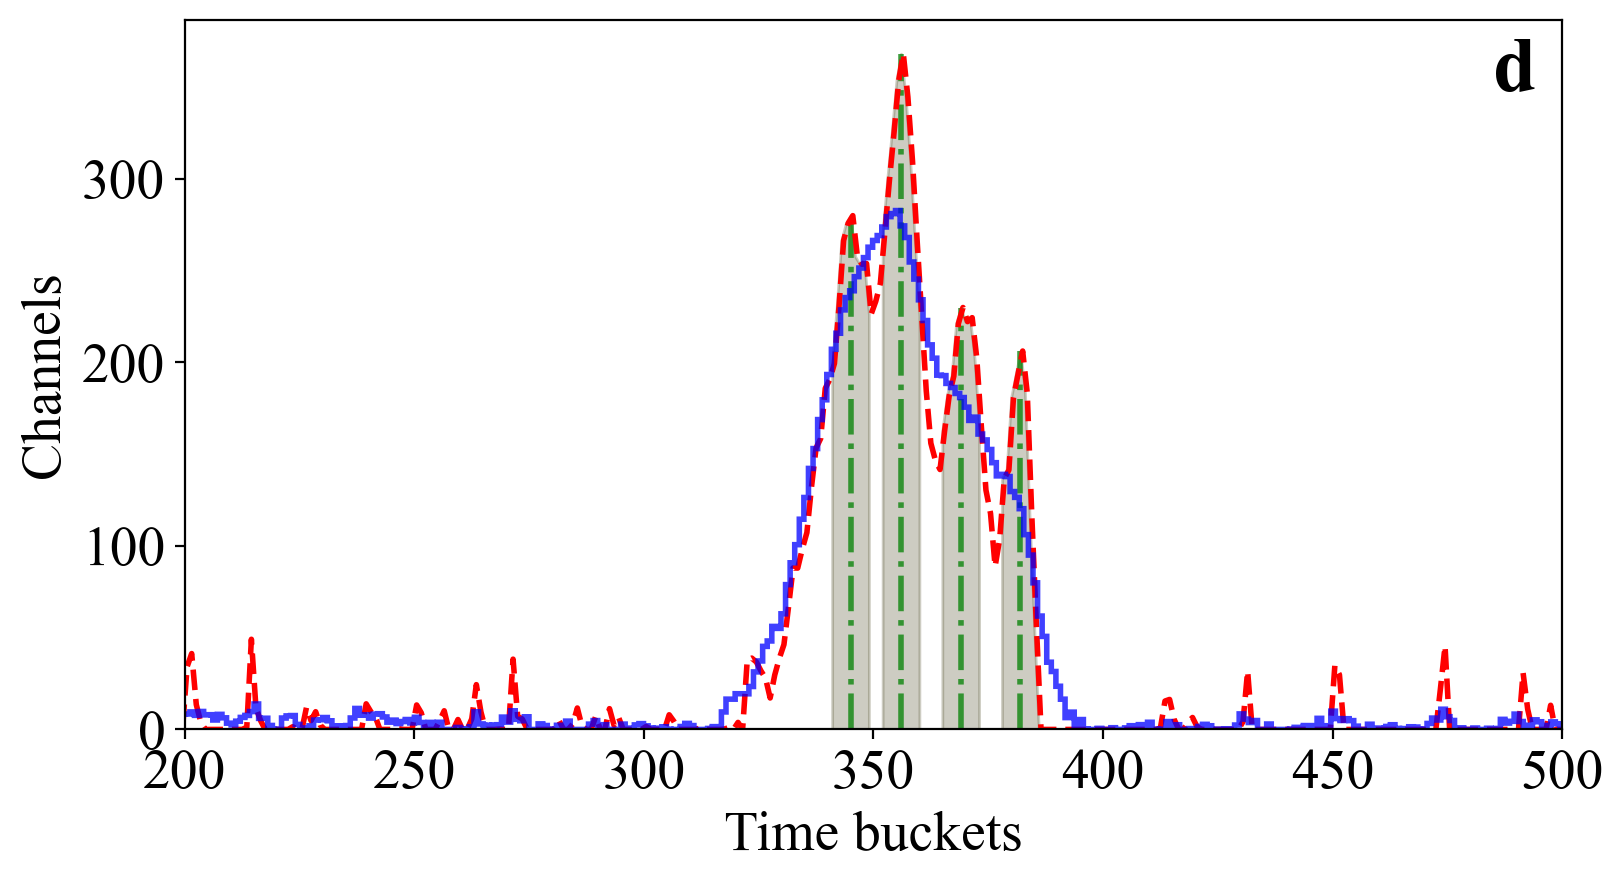

In [35]:
xt = np.arange(0.5, 512, 1)
fonte = 20
# num = np.random.randint(low = 0, high = len(predictions), size = 1)[0]
# num = next(gen)
d = {0 : "b", 2 : "a", 143 : "c", 148 : "d"}
num = 148
print(f"Saída num = {num}")
predict = predict_decv[num].reshape(-1)/0.85
picos_p = fp(predict, height = 50., distance = 4, prominence = 4)[0]
picos = []
for p in picos_p:
    if y1[num][p] > 50.:
        picos.append(p)
picos = np.array(picos, dtype = int)
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal")
# for pico in picos[np.array([0, 1, 3, 4, 5])]:
for pico in picos:
    extra = 4
    area = np.arange(pico - extra, pico + extra + 1)
    plt.fill_between(area, predict[area.astype(int)], alpha = 0.3, color = "#5B5936", label = "Integral")
    plt.plot(np.array([pico, pico], dtype = int), np.array([0., predict[pico]]), lw = 2., ls = "-.", c = "green",
             alpha = 0.75, label = "Detected centroid")
#     extra = 4
#     area = np.arange(pico - extra, pico + extra + 1)
#     plt.fill_between(area, predict[area.astype(int)], alpha = 0.3, color = "#5B5936", label = "Integral")

plt.plot(xt, predict, lw = 2, ls = "--", c = "red", label = "CNN")
plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal w/o baseline", alpha = 0.75)
# plt.plot(xt, BKG[num], lw = 2, c = "green", label = "Correto")
# plt.plot(xt, predict_bkg[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "CNN")
# plt.axhline(y = 50., ls = "--", lw = 2., c = "black", zorder = 0, label = "Threshold")
# plt.legend(fontsize = fonte - 3, framealpha = 1., edgecolor = "black", loc = 2)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
print(list(by_label.keys()))
nomes_1 = list(by_label.keys())
lines_1 = list(by_label.values())
nomes = [nomes_1[2], nomes_1[-1], nomes_1[1], nomes_1[0]]
lines = [lines_1[2], lines_1[-1], lines_1[1], lines_1[0]]
# plt.legend(lines, nomes, fontsize = fonte - 3.5, framealpha = 1., edgecolor = "black", loc = 2)
plt.tight_layout()
plt.xlabel("Time buckets", fontsize = fonte)
plt.ylabel("ADC Channels", fontsize = fonte)
# plt.title(num)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
fig.gca().set_ylim(bottom = 0)
# fig.gca().set_ylim(bottom = 0, top = 900)
fig.gca().set_xlim(left = 200, right = 500)
bottom, top = plt.ylim()
plt.text(485, (top-bottom)*0.9, d[num], fontsize = 28, weight='bold')
plt.savefig(f"imagens/final_peak_pat_{num}.png", dpi = 600, bbox_inches='tight')
plt.show()

# Reconstrução nuvem de pontos

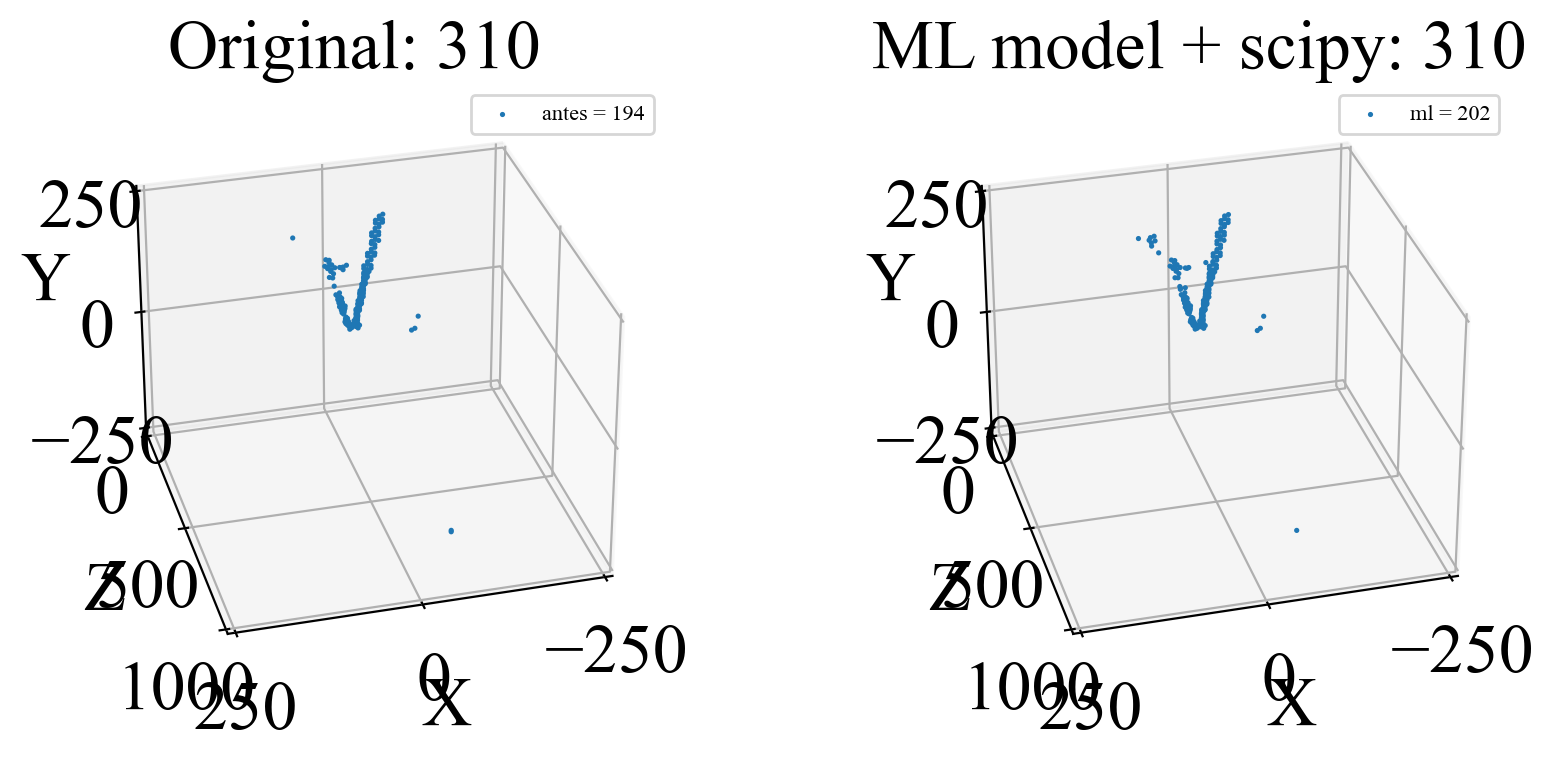

In [2]:
num = 310
name = ""
data   = np.load(f"./dados/nuvem_origi_{num}.npy", allow_pickle = True)
data_2 = np.load(f"./dados/nuvem_cnn_{num}.npy", allow_pickle = True)
fig = plt.figure(figsize=plt.figaspect(0.4), dpi = 200)
fig.patch.set_facecolor('white')
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
#ax1 = plt.axes(projection="3d")
ax1.view_init(None, 75)
ax2.view_init(None, 75)
ax1.set_zlim((-250, 250))
ax1.set_xlim((-250, 250))
ax1.set_ylim((0, 1000))
ax2.set_zlim((-250, 250))
ax2.set_xlim((-250, 250))
ax2.set_ylim((0, 1000))
ax1.set_xlabel('X')
ax1.set_ylabel('Z')
ax1.set_zlabel('Y')
ax1.set_title("Original: " + str(num) + " " + name)
ax2.set_title("ML model + scipy: " + str(num) + " " + name)
ax2.set_xlabel('X')
ax2.set_ylabel('Z')
ax2.set_zlabel('Y')
ax1.scatter3D(data[:, 0], data[:, 2], data[:, 1], marker = '.', s = 3, alpha = 1, label = "antes = " + str(len(data)))
ax2.scatter3D(data_2[:, 0], data_2[:, 2], data_2[:, 1], marker = '.', s = 3, alpha = 1, label = "ml = " + str(len(data_2)))
ax1.legend(fontsize = 8)
ax2.legend(fontsize = 8)
plt.show()

# Exemplos pulsos

Saída num = 152278


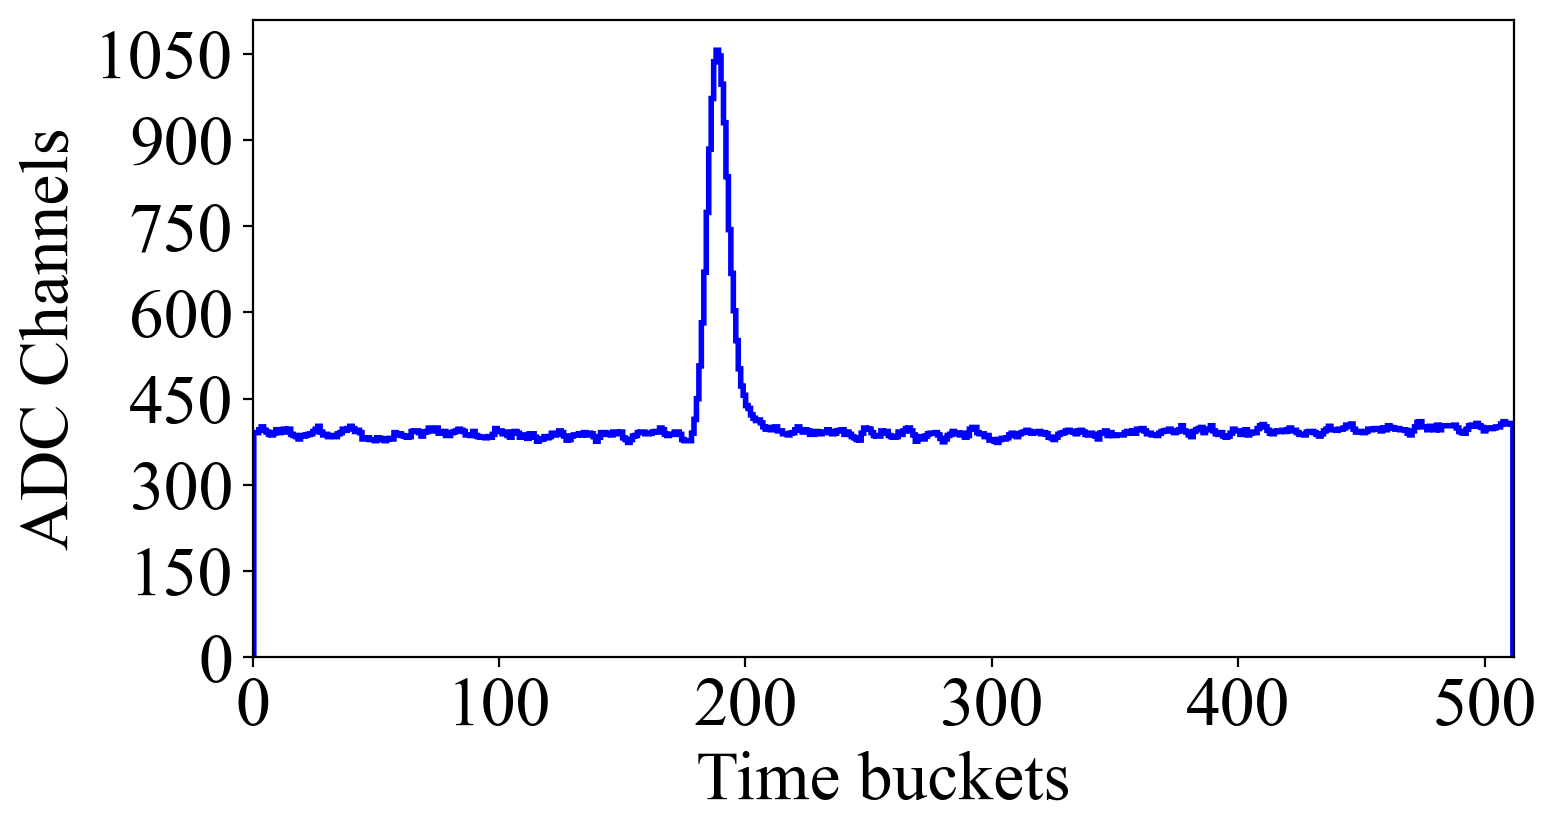

Saída num = 165960


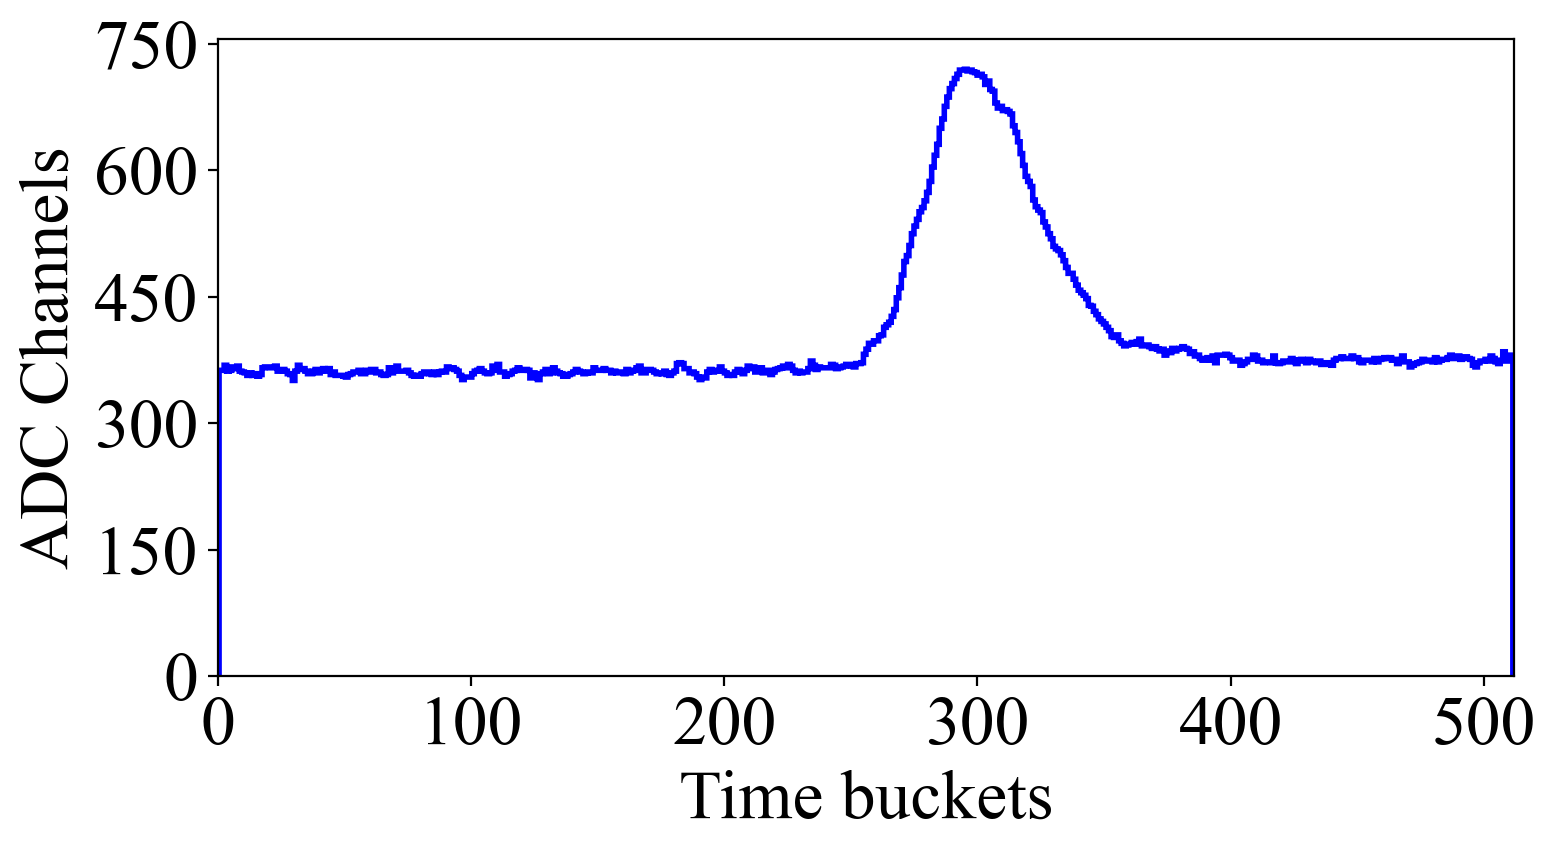

In [8]:
# num = 165960
# num = 152278
xt  = np.arange(0.5, 512, 1)
tam = 512
d = {152278 : 1, 165960 : 2}
for num in [152278, 165960]:
    print(f"Saída num = {num}")
    fig = plt.figure(dpi = 200, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step")
    # plt.plot(xt, y2[num], lw = 2, c = "green", label = "Resultado correto")
    # plt.plot(xt, predictions[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "Resultado do modelo")
    # plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte) # Size here overrides font_prop
    plt.tight_layout()
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(150))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/ex_sinal_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()

# Fundo: CNN vs fourier

Saída num = 3
['Fundo', 'CNN', 'Sinal bruto']
300.0 477.75


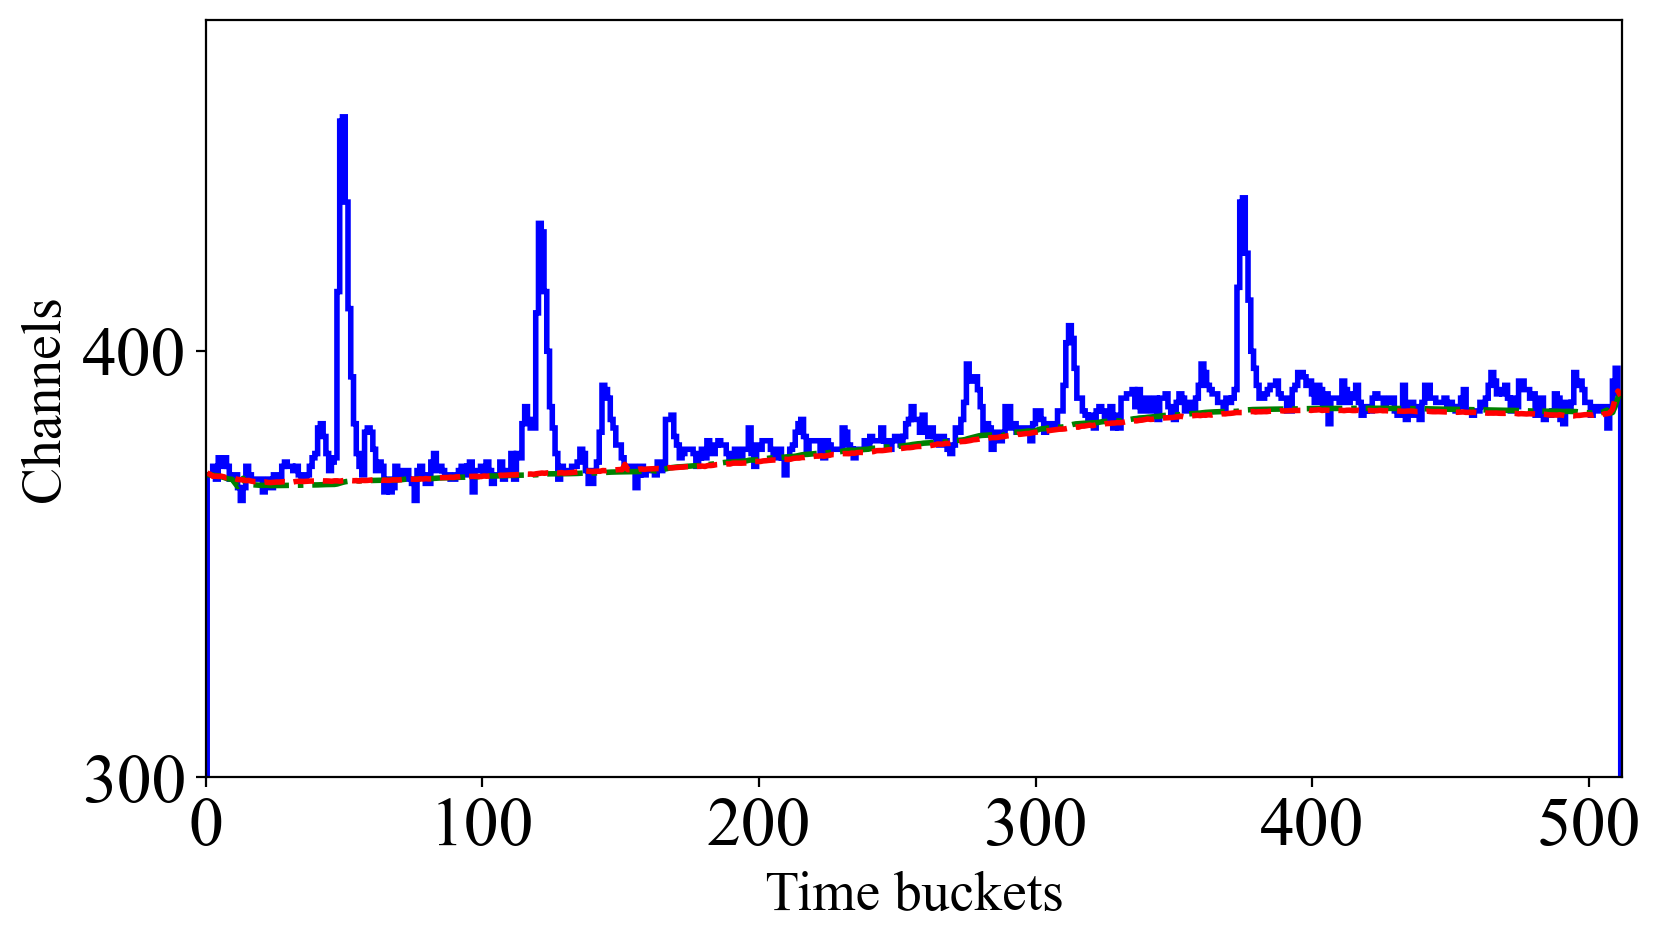

In [14]:
xt = np.arange(0.5, 512, 1)
fonte = 20
d = {1 : "a", 13 : "b", 26 : "c", 65 : "d"}
index = {1 : 0, 13 : 1, 26 : 2, 65 : 3}
# d = {0 : "a", 2 : "b", 143 : "c", 148 : "d"}
# num = np.random.randint(low = 0, high = len(predictions), size = 1)[0]
# num = next(gen)
num1 = 65
num  = index[num1]
print(f"Saída num = {num}")
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Sinal bruto")
# plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Raw signal w/o baseline", alpha = 0.75)
plt.plot(xt, BKG[num], lw = 2, ls = "-.", c = "green", label = "Fundo")
plt.plot(xt, predict_bkg[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "CNN")
# plt.plot(xt, predict_decv[num].reshape(-1)/0.85, lw = 2, ls = "--", c = "red", label = "CNN")
# plt.axhline(y = 50., ls = (0, (3, 1, 1, 1, 1, 1)), lw = 2., c = "black", zorder = 0, label = "Threshold")
handles, labels = plt.gca().get_legend_handles_labels()
# labels.reverse()
# handles.reverse()
# labels2  = [labels[2], labels[1], labels[0], labels[3]]
# handles2 = [handles[2], handles[1], handles[0], handles[3]]
by_label = dict(zip(labels, handles))
print(list(by_label.keys()))
nomes_1 = list(by_label.keys())
lines_1 = list(by_label.values())
nomes = [nomes_1[1], nomes_1[0], nomes_1[2]]
lines = [lines_1[1], lines_1[0], lines_1[2]]
# plt.legend(fontsize = fonte - 3, framealpha = 1., edgecolor = "black", loc = 2)
# plt.legend(lines, nomes, fontsize = fonte - 3., framealpha = 1., edgecolor = "black", loc = 2)
plt.tight_layout()
plt.xlabel("Time buckets", fontsize = fonte)
plt.ylabel("ADC Channels", fontsize = fonte)
# plt.title(num)
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
fig.gca().set_ylim(bottom = 300)
# fig.gca().set_ylim(bottom = 0, top = 900)
fig.gca().set_xlim(left = 0, right = 512)
bottom, top = plt.ylim()
print(bottom, top)
# plt.text(485, (top - bottom)*0.9 + bottom, d[num1], fontsize = 28, weight='bold')
plt.savefig(f"imagens/stb_{num}.png", dpi = 600, bbox_inches='tight')
# plt.savefig(f"imagens/final_bkg_{num}.png", dpi = 600, bbox_inches='tight')
# plt.savefig(f"imagens/final_deconv_pat_{num}.png", dpi = 600, bbox_inches='tight')
plt.show()

# Fundo filtro passa baixa

142859


C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


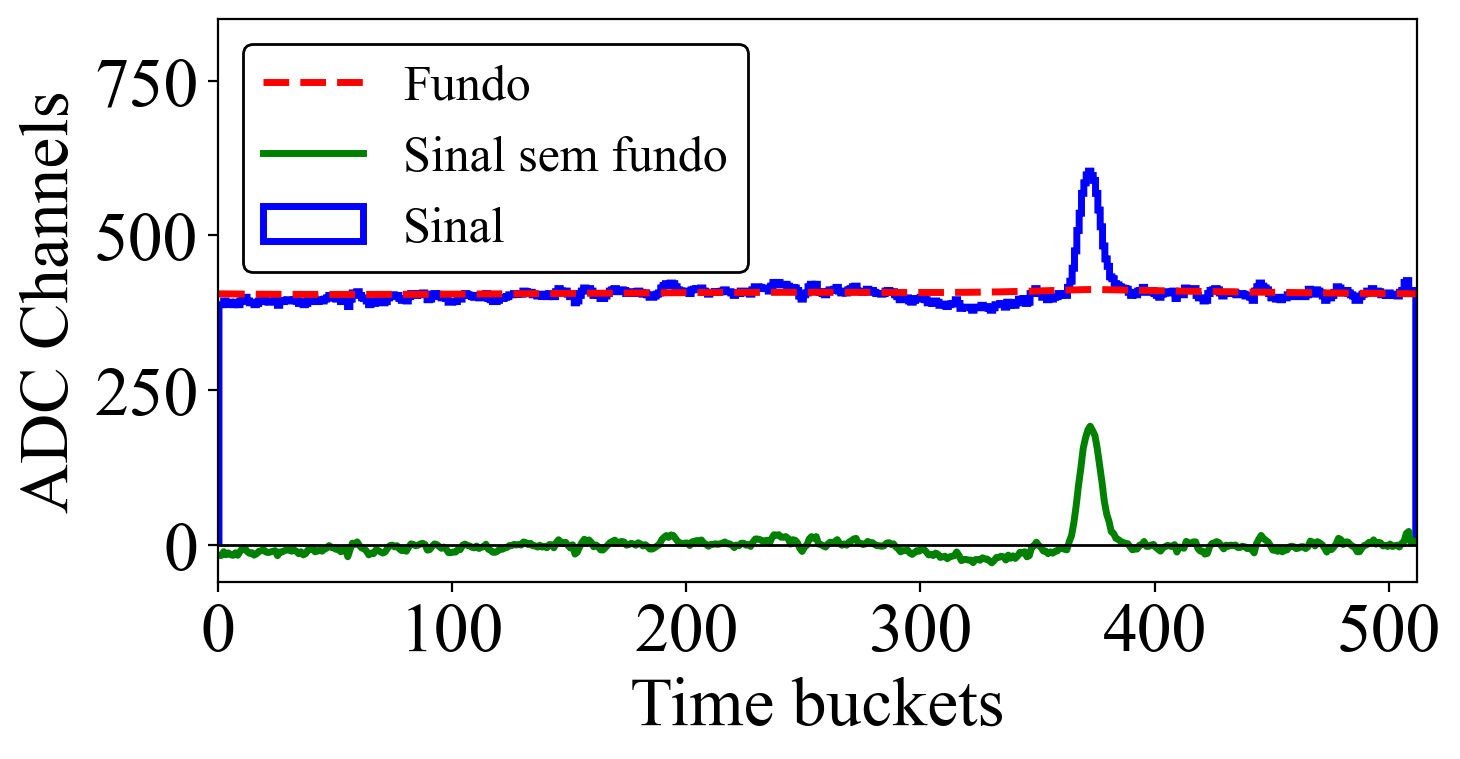

14271


C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


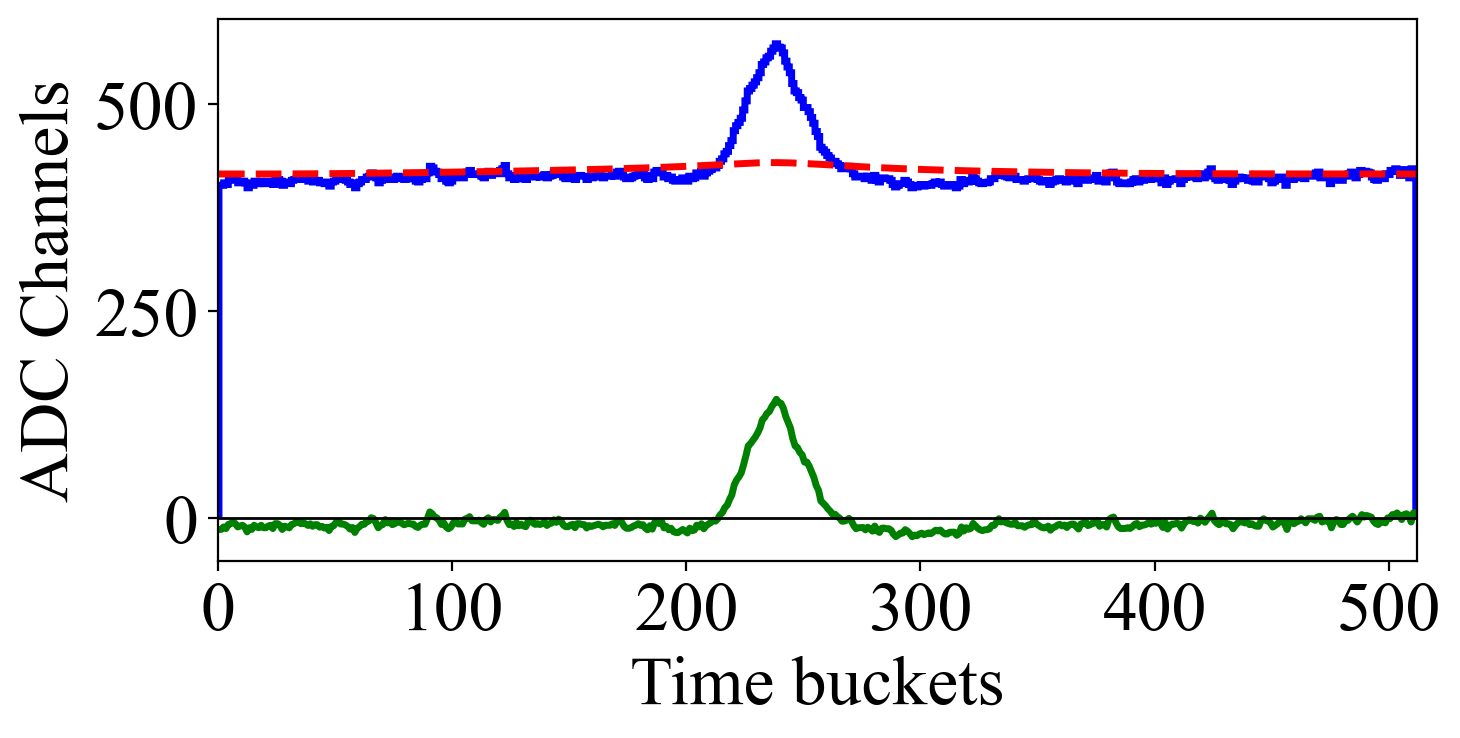

159912


C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


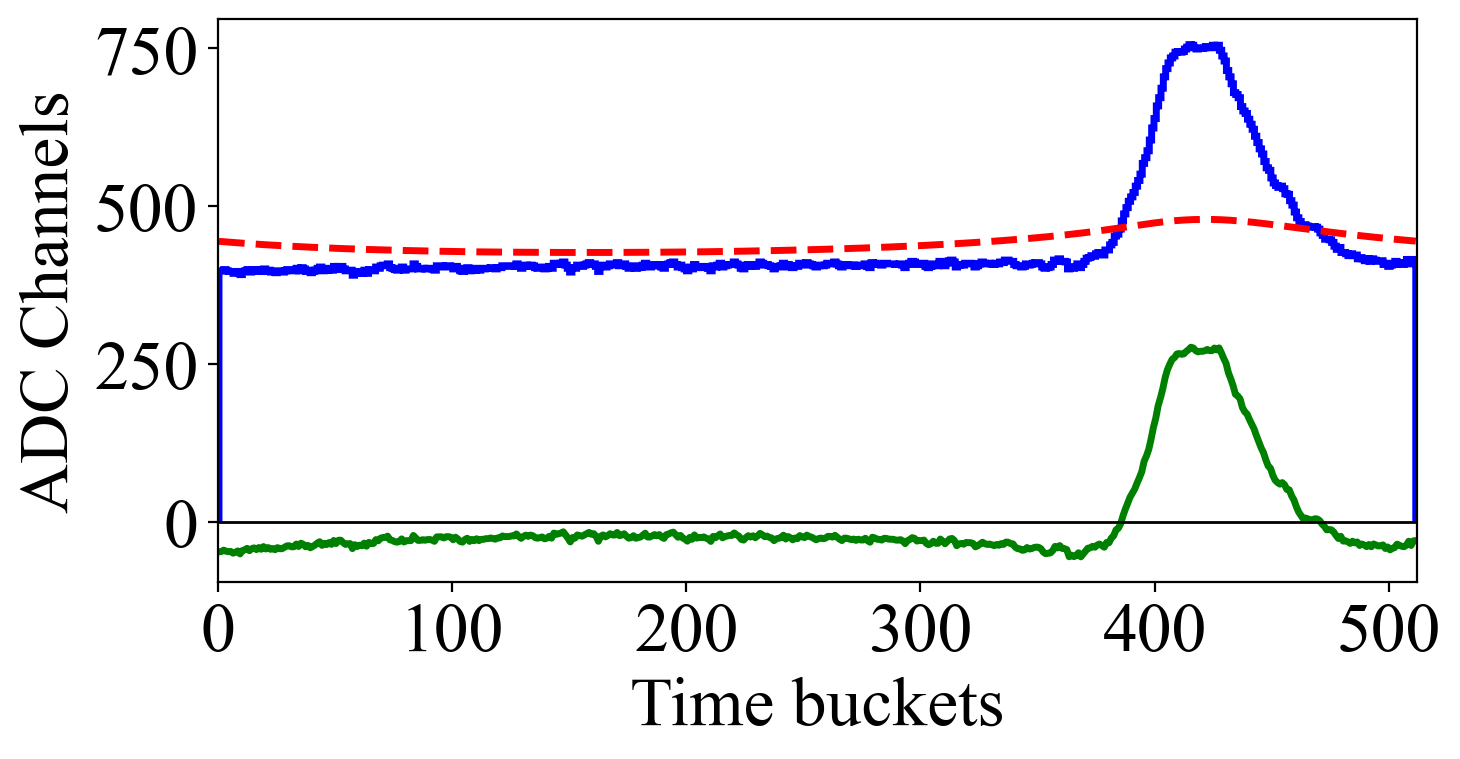

147137


C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


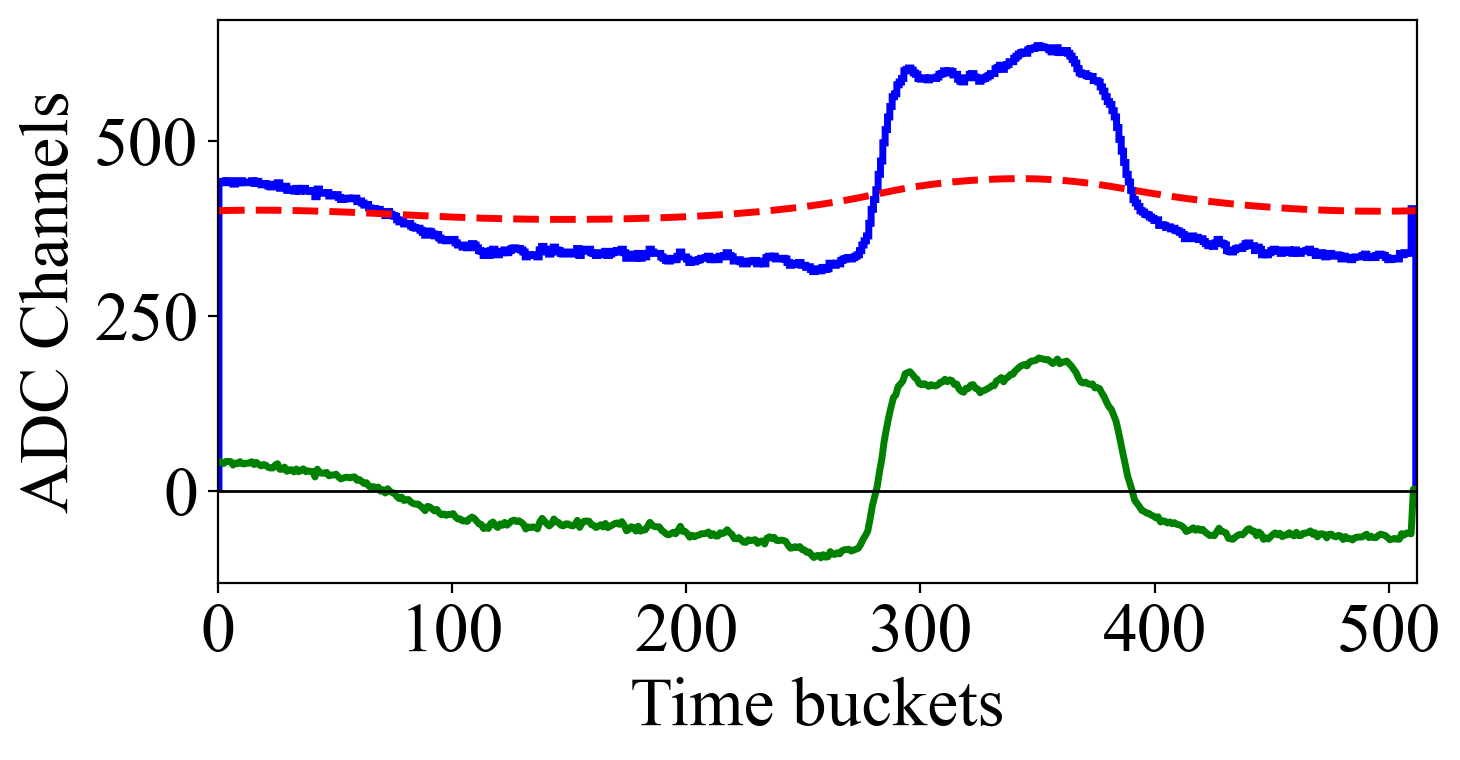

In [7]:
xt = np.arange(0.5, 512, 1)
# num = np.random.randint(low = 0, high = 200_000, size = 1)[0]
# num    = 173529
fonte = 20
# num    = 142859
# num    = 14271
# num    = 159912
d = {142859 : 1, 14271 : 2, 159912 : 3, 147137 : 4}
for num in d.keys():
# num    = 147137
    print(num)
    orig   = x1[num]
    passo1 = fft(orig)
    xv = 1/xt
    a  = 1
    prtial = np.sin(np.pi*xv/a)/(np.pi*xv/a)
    passo2 = passo1*prtial
    passo3 = ifft(passo2)
    # print(passo2.shape)
    fundo = orig - passo3
    # fig, (f1) = plt.subplots(nrows = 1, figsize = (8, 4.5), dpi = 250)
    fig = plt.figure(dpi = 200, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    plt.hist(xt, weights = orig, bins = 512, color = "blue", histtype = "step", lw = 2.5, label = "Sinal")
    # f1.set(xlabel = "Buckets", ylabel = "ADC Charge")
    # f1.set_title(f"Number = {num}")
    # f2.set_title(f"Prediction")
    # f1.plot(xt, passo1, c = "green", lw = 1, label = "Passo1")
    # f1.plot(xt, passo2, c = "red", lw = 1, label = "Passo2")
    plt.plot(xt, fundo, c = "red", lw = 2.5, label = "Fundo", ls = "--")
    plt.plot(xt, passo3, c = "green", lw = 2.5, label = "Sinal sem fundo")
    plt.axhline(c = "black", lw = 1)
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.xlim(left = 0, right = 512)
    plt.xticks([0, 100, 200, 300, 400, 500])
    # plt.ylim(bottom = None, top = 850)
    # f1.set_ylim(bottom = -200, top = 900)
    if num == 142859:
        plt.ylim(bottom = None, top = 850)
        plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black", loc = 2)
    # f2.legend()
    # f3.legend()
    # plt.tight_layout(rect = [0.015, 0., 1., 1.])
    plt.tight_layout()
    # fig.set(ylabel = "ADC Charge")
    # fig.subplots_adjust(hspace = 0)
    # fig.text(0.01, 0.5, 'ADC Channels', va='center', rotation='vertical')
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/bs_fourier_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()
# 14271 142859 159912 147137

# Fundo passa baixa 2

142859


C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


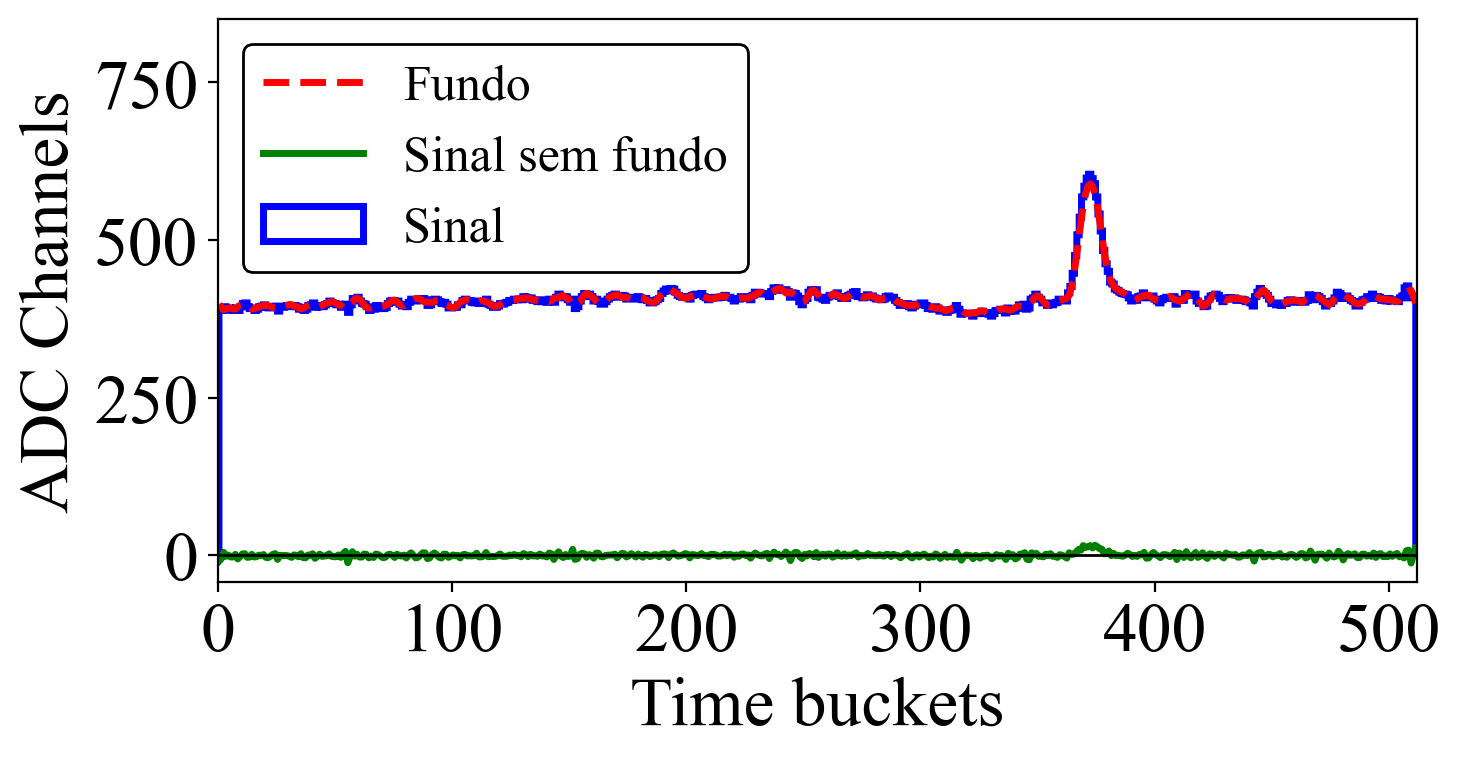

14271


C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


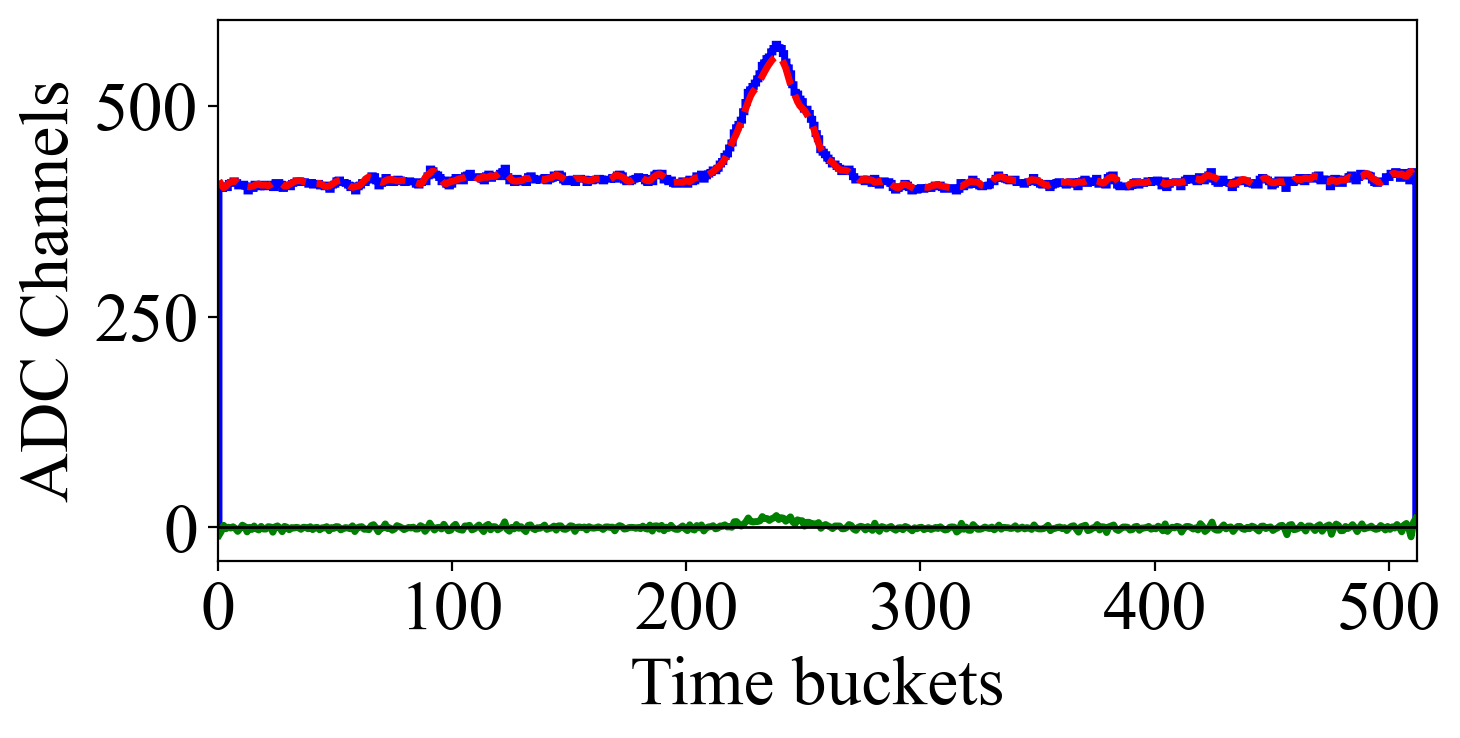

C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


159912


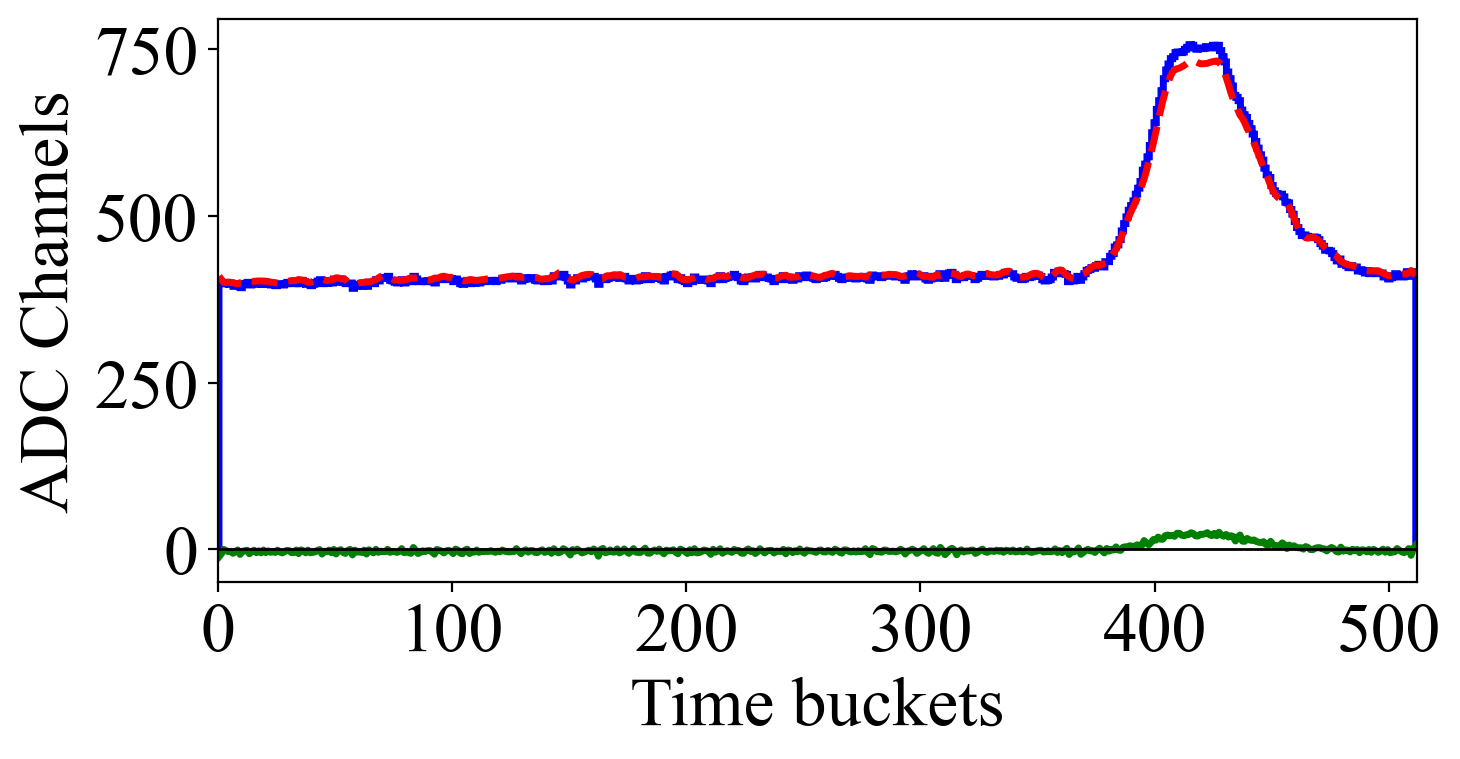

147137


C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


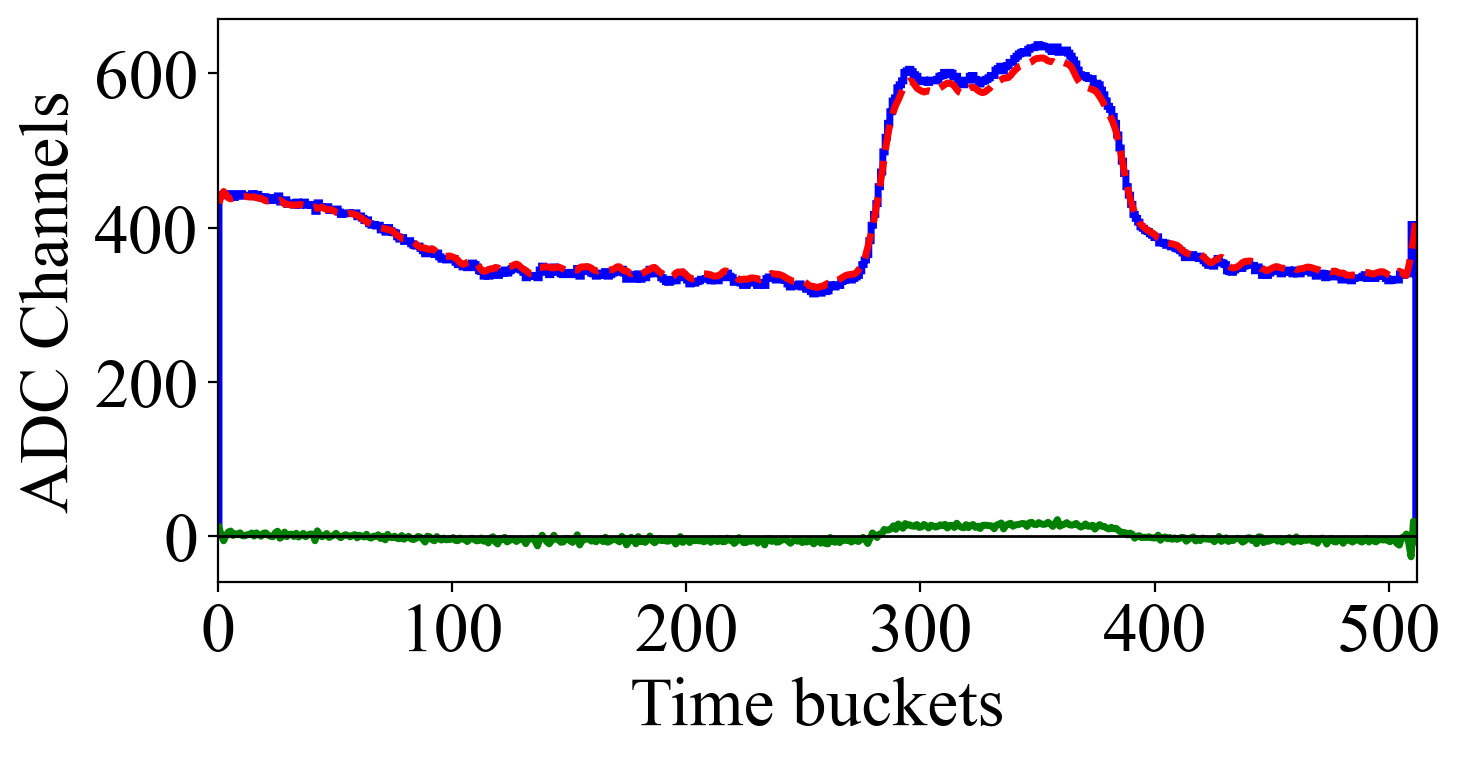

In [55]:
xt = np.arange(0.5, 512, 1)
# num = np.random.randint(low = 0, high = 200_000, size = 1)[0]
# num    = 173529
fonte = 20
# num    = 142859
# num    = 14271
# num    = 159912
d = {142859 : 1, 14271 : 2, 159912 : 3, 147137 : 4}
for num in d.keys():
# num    = 147137
    print(num)
    orig   = x1[num]
    passo1 = fft(orig)
    xv = 1/xt
    a  = 0.5
    # prtial = np.sin(np.pi*xv/a)/(np.pi*xv/a)
    
    # prtial = signal.gausspulse(xv, fc = 60, bw = 0.5)[0]
    
    # AA = lambda a: 2/(np.sqrt(3*a)*(np.pi**0.25))
    # prtial = AA(a)*(1 - (xv/a)**2)*np.exp(-0.5*(xv/a)**2)
    h = lambda t, A, tau: A*np.exp(-2*t/tau)*np.power(t/tau, 3)*np.sin(t/tau)
    # prtial = signal.ricker(512, a = 4)
    prtial = h(xv, 15, 1e-3)
    passo2 = passo1*prtial
    passo3 = ifft(passo2)
    # print(passo2.shape)
    fundo = orig - passo3
    # fig, (f1) = plt.subplots(nrows = 1, figsize = (8, 4.5), dpi = 250)
    fig = plt.figure(dpi = 200, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    plt.hist(xt, weights = orig, bins = 512, color = "blue", histtype = "step", lw = 2.5, label = "Sinal")
    # f1.set(xlabel = "Buckets", ylabel = "ADC Charge")
    # f1.set_title(f"Number = {num}")
    # f2.set_title(f"Prediction")
    # f1.plot(xt, passo1, c = "green", lw = 1, label = "Passo1")
    # f1.plot(xt, passo2, c = "red", lw = 1, label = "Passo2")
    plt.plot(xt, fundo, c = "red", lw = 2.5, label = "Fundo", ls = "--")
    plt.plot(xt, passo3, c = "green", lw = 2.5, label = "Sinal sem fundo")
    plt.axhline(c = "black", lw = 1)
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.xlim(left = 0, right = 512)
    plt.xticks([0, 100, 200, 300, 400, 500])
    # plt.ylim(bottom = None, top = 850)
    # f1.set_ylim(bottom = -200, top = 900)
    if num == 142859:
        plt.ylim(bottom = None, top = 850)
        plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black", loc = 2)
    # f2.legend()
    # f3.legend()
    # plt.tight_layout(rect = [0.015, 0., 1., 1.])
    plt.tight_layout()
    # fig.set(ylabel = "ADC Charge")
    # fig.subplots_adjust(hspace = 0)
    # fig.text(0.01, 0.5, 'ADC Channels', va='center', rotation='vertical')
    # plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/bs_fourier_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()

# Fundo fourier

Saída num = 74036


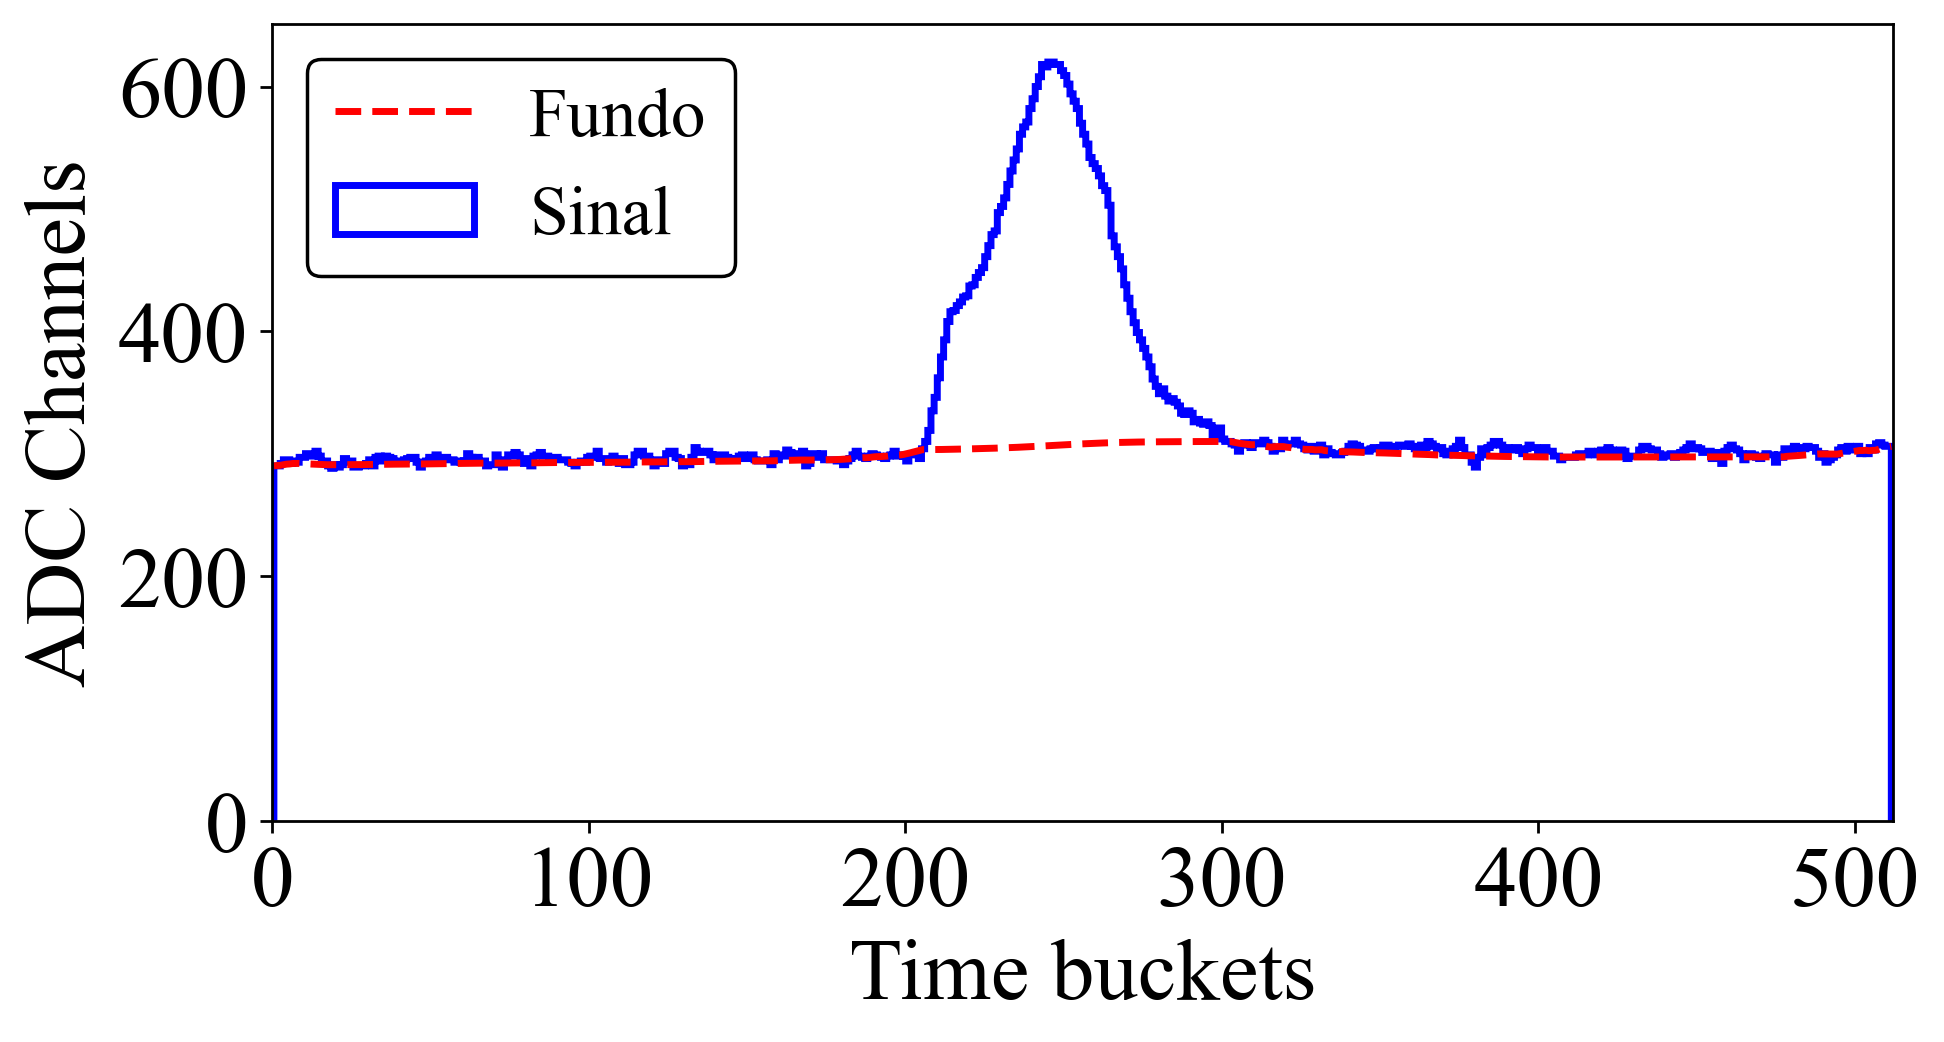

Saída num = 23880


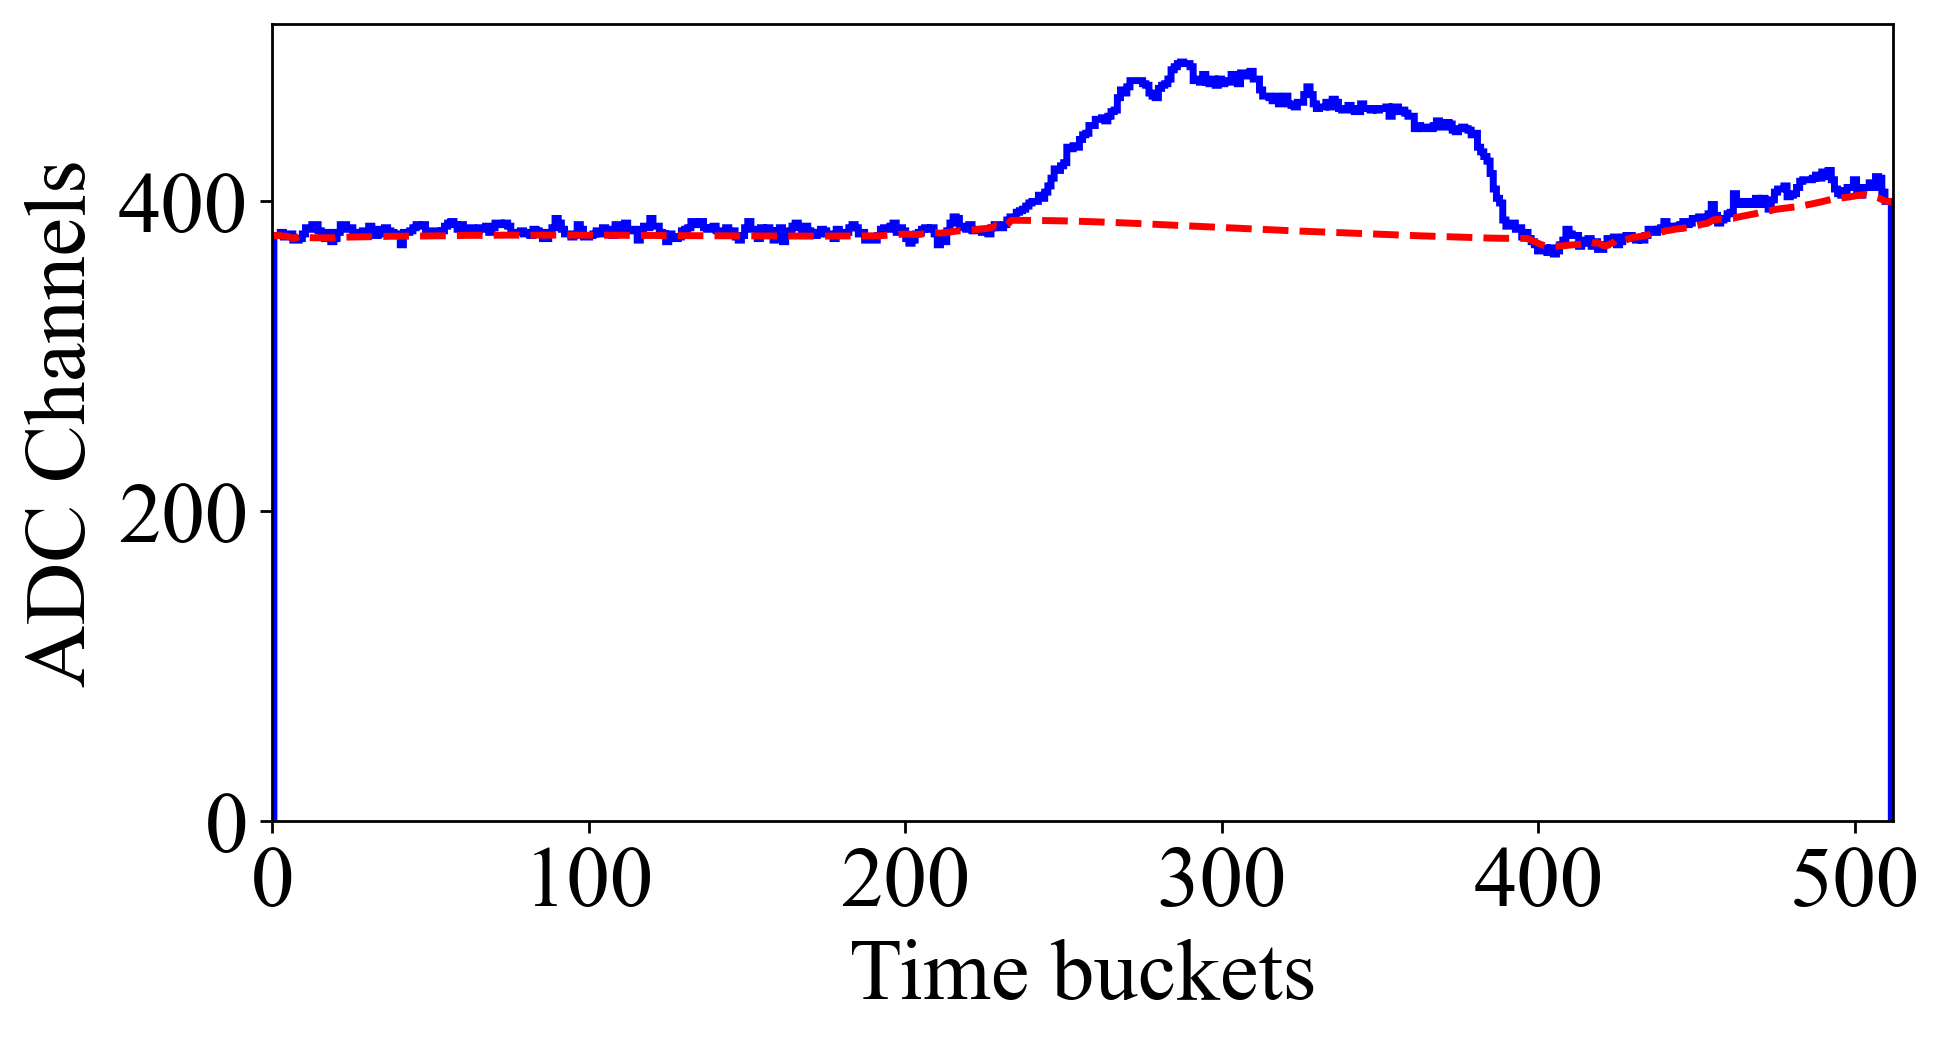

Saída num = 90601


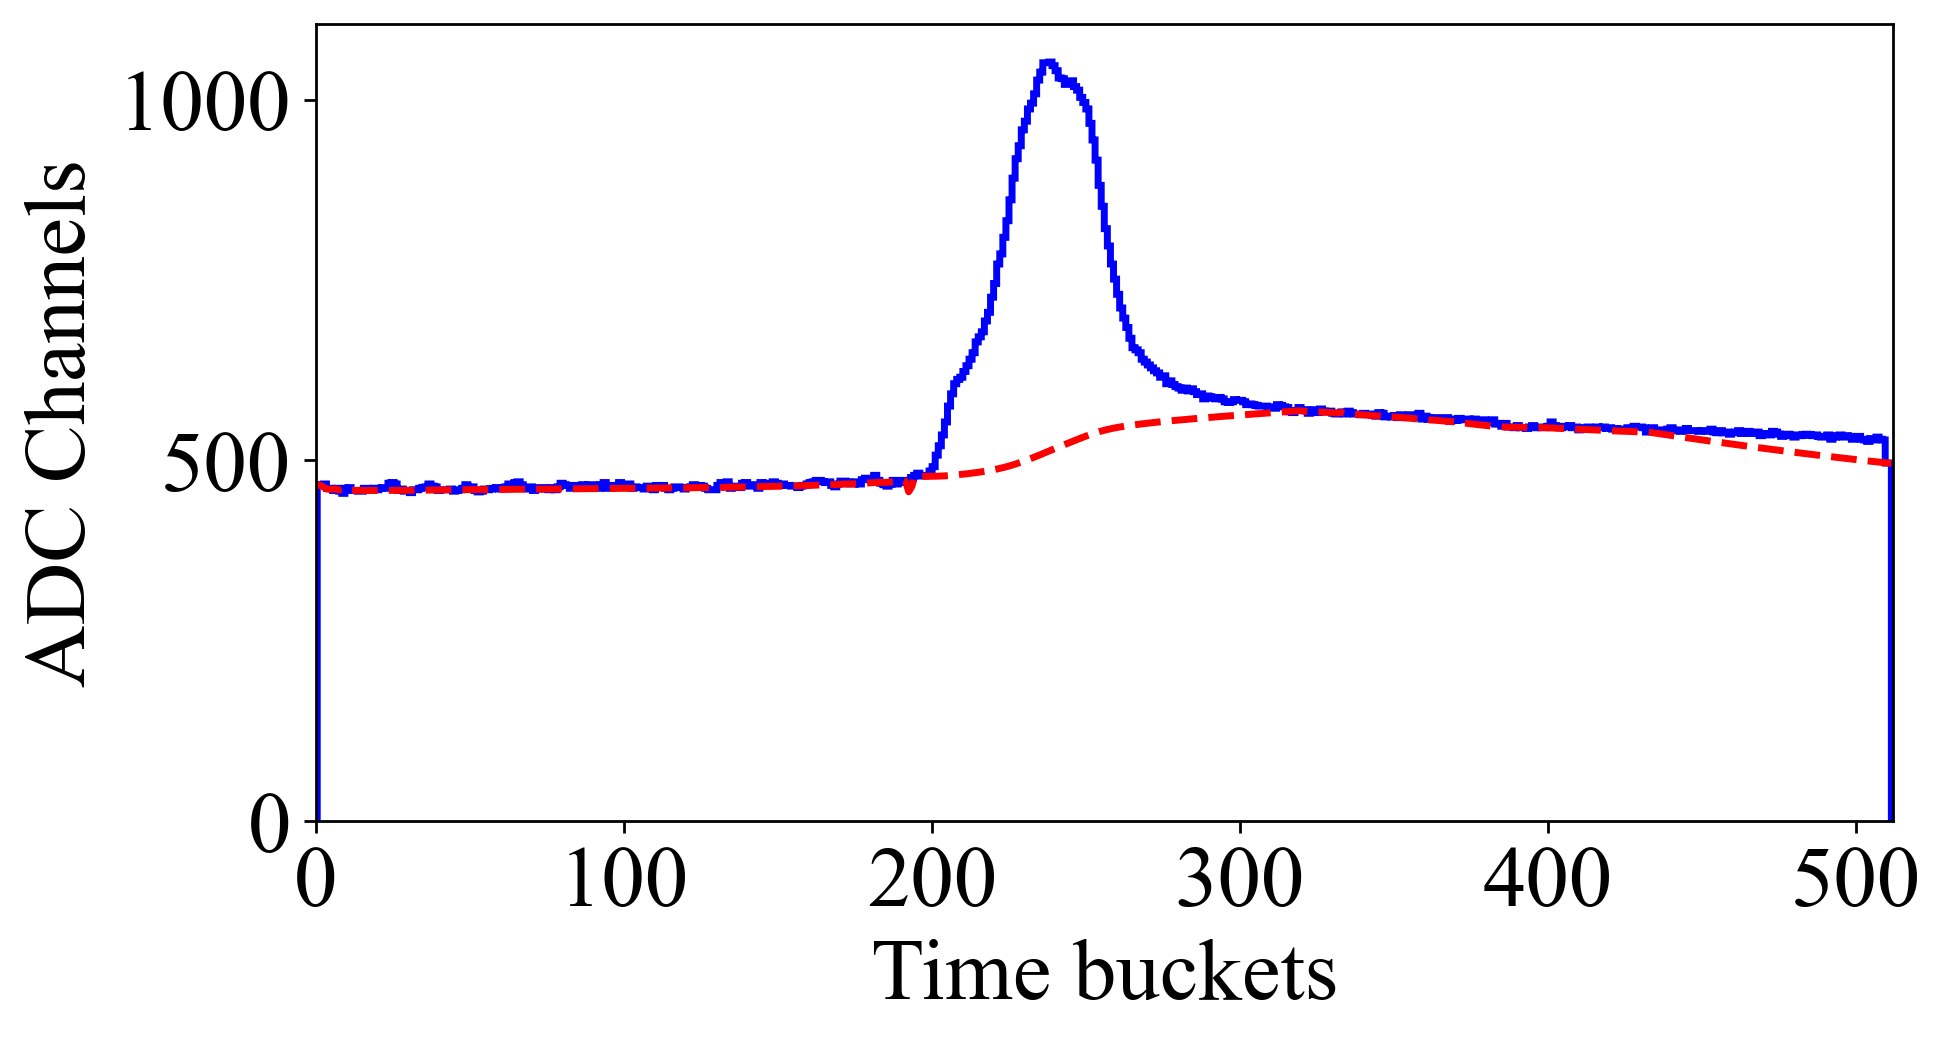

Saída num = 37358


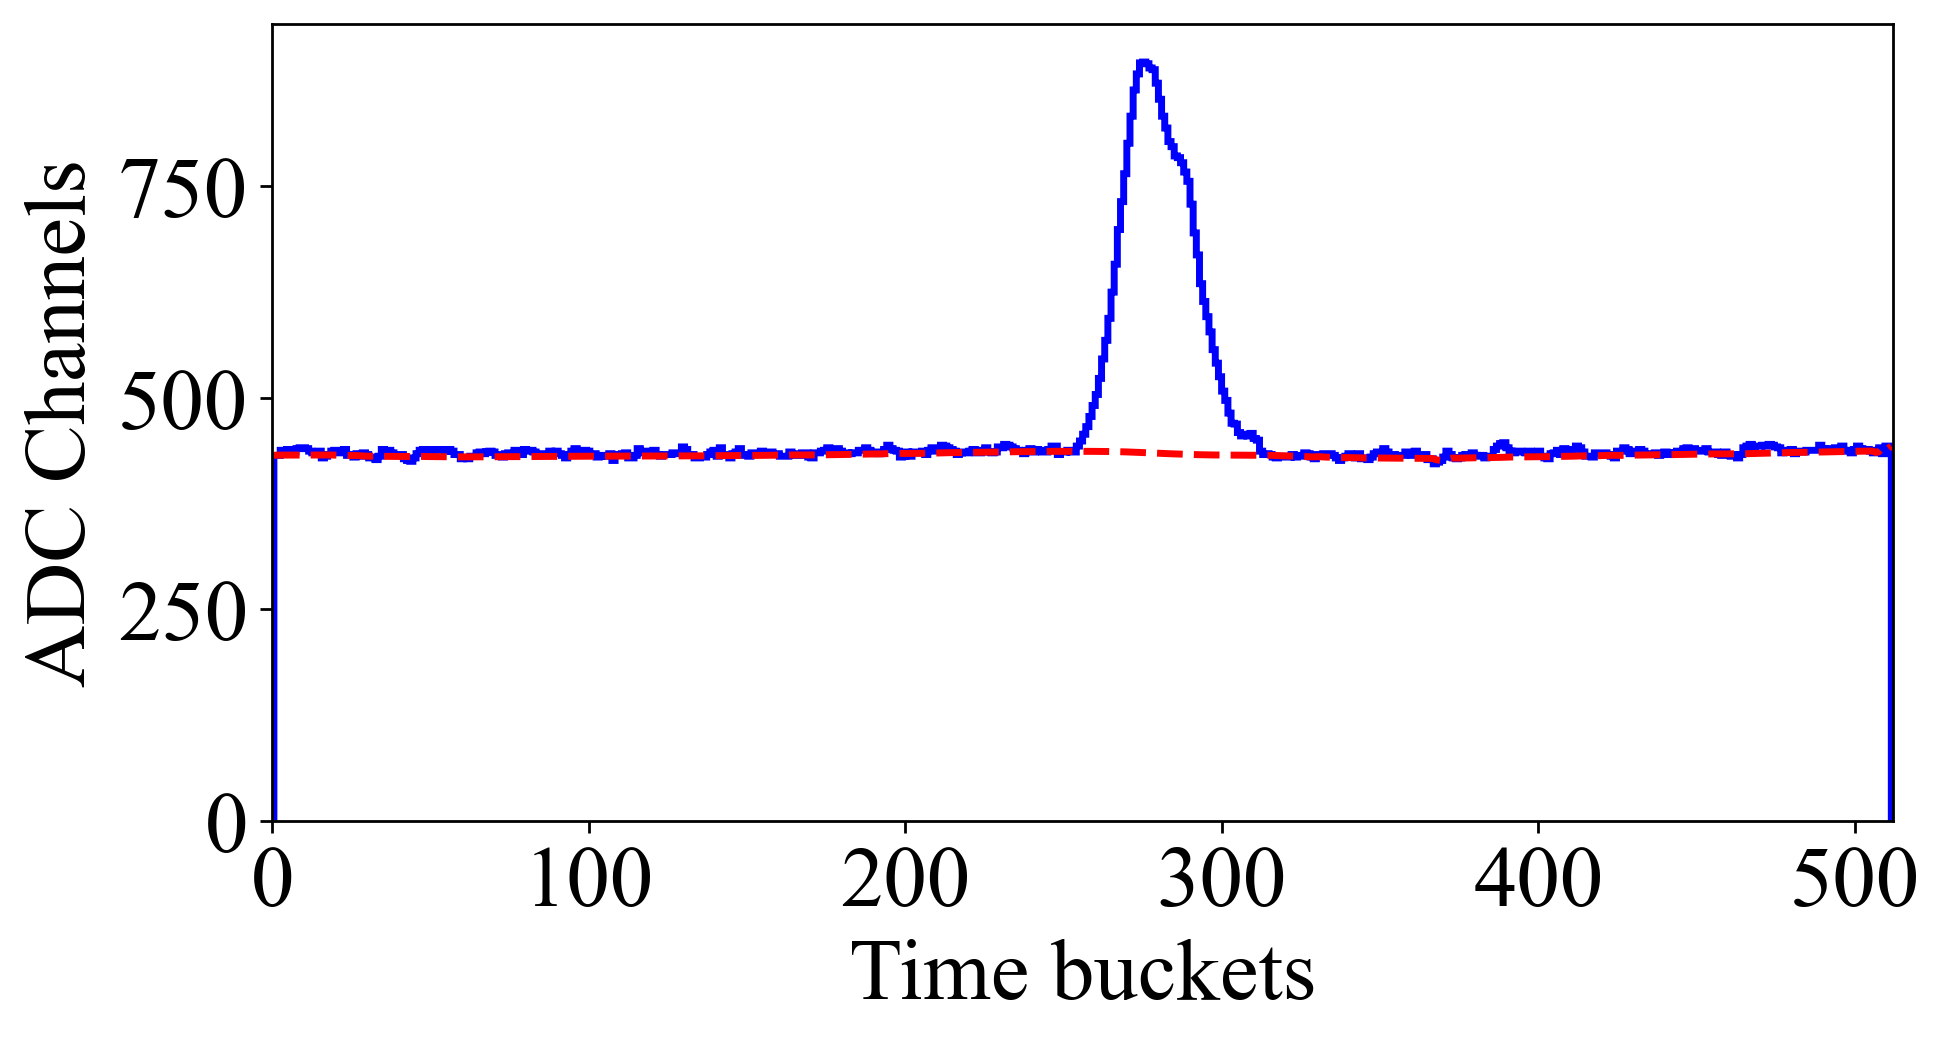

In [10]:
fonte = 15
xt = np.arange(0.5, 512, 1)
d = {74036 : 1, 23880 : 2, 90601 : 3, 37358 : 4}
# num = np.random.randint(low = 0, high = len(x1), size = 1)[0]
# num = np.random.choice(indd, 1)[0]
# num = 74036
# num = 37358
for num in d.keys():
    print(f"Saída num = {num}")
    fig = plt.figure(dpi = 250, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", label = "Sinal")
    plt.plot(xt, BKG[num], lw = 2, c = "red", ls = "--", label = "Fundo")
    # plt.plot(xt, y2[num], lw = 2, c = "green", label = "Resultado correto")
    # plt.plot(xt, predictions[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "Resultado do modelo")
    # plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte) # Size here overrides font_prop
    plt.tight_layout()
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    # plt.title("Espectro original")
    # plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(150))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    if num == 74036:
        plt.legend(fontsize = 20, framealpha = 1., edgecolor = "black", loc = 2)
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/ex_sinal_bkg_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()

# 74036 23880 90601 37358
# 176082, 0, 2

# Gold deconvolution

Saída num = 110413


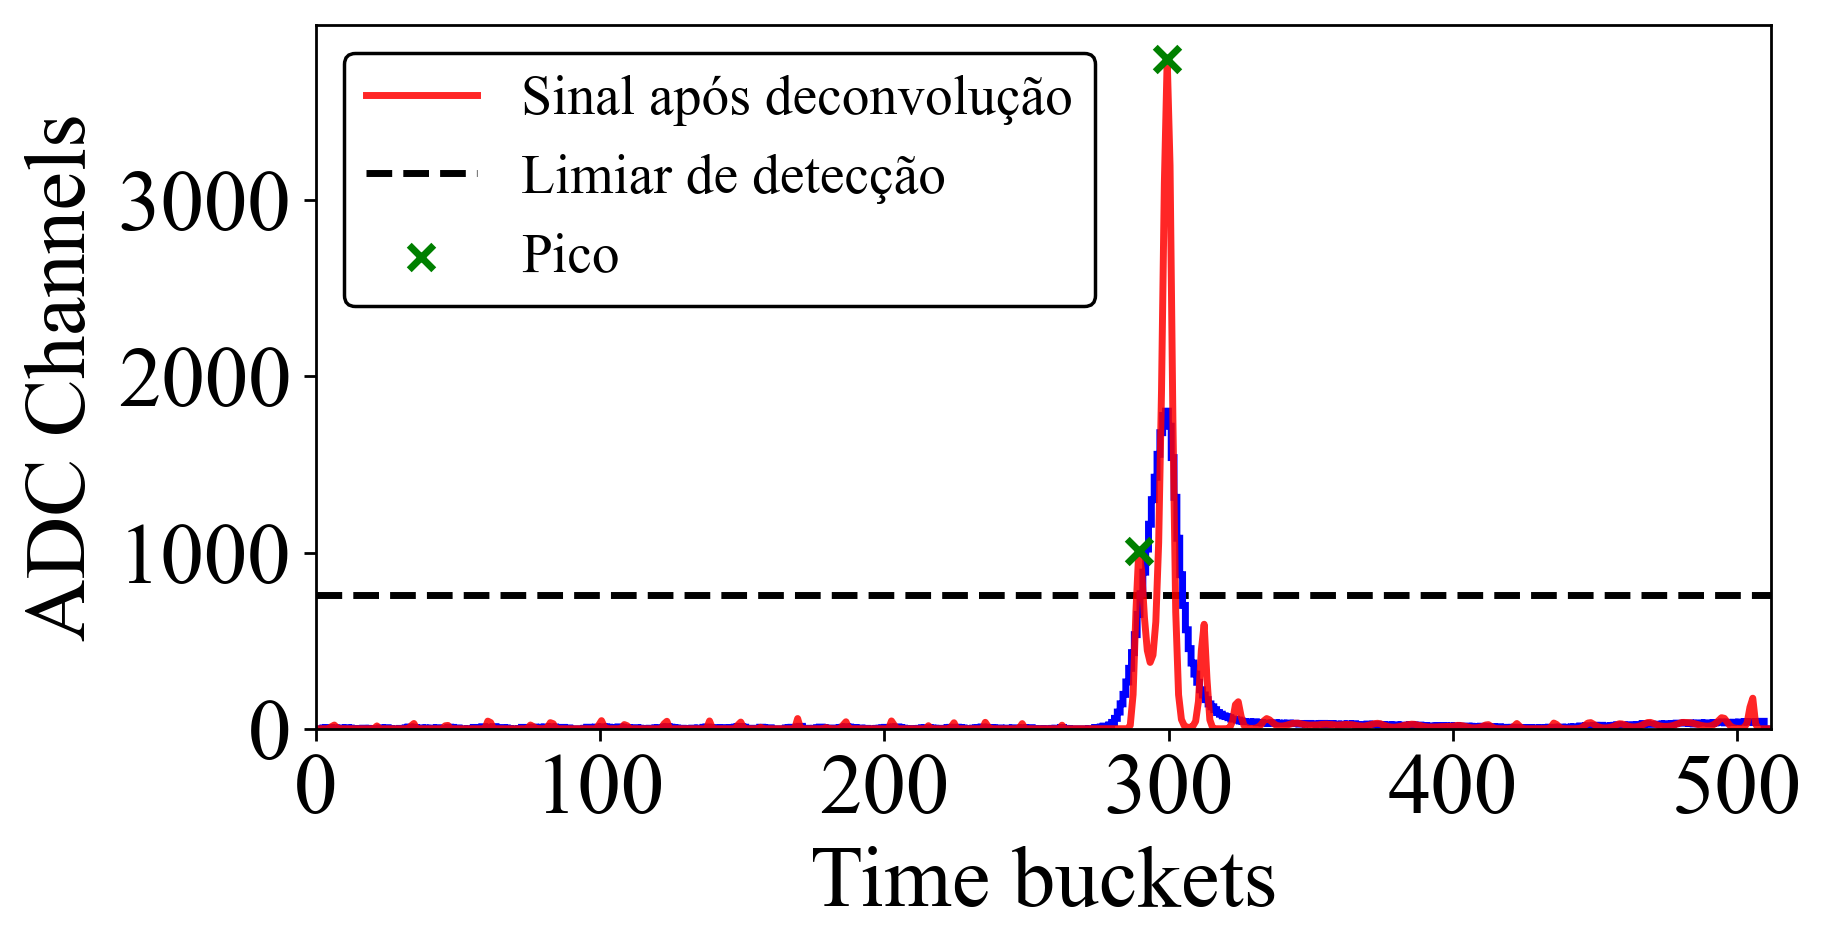

Saída num = 116959


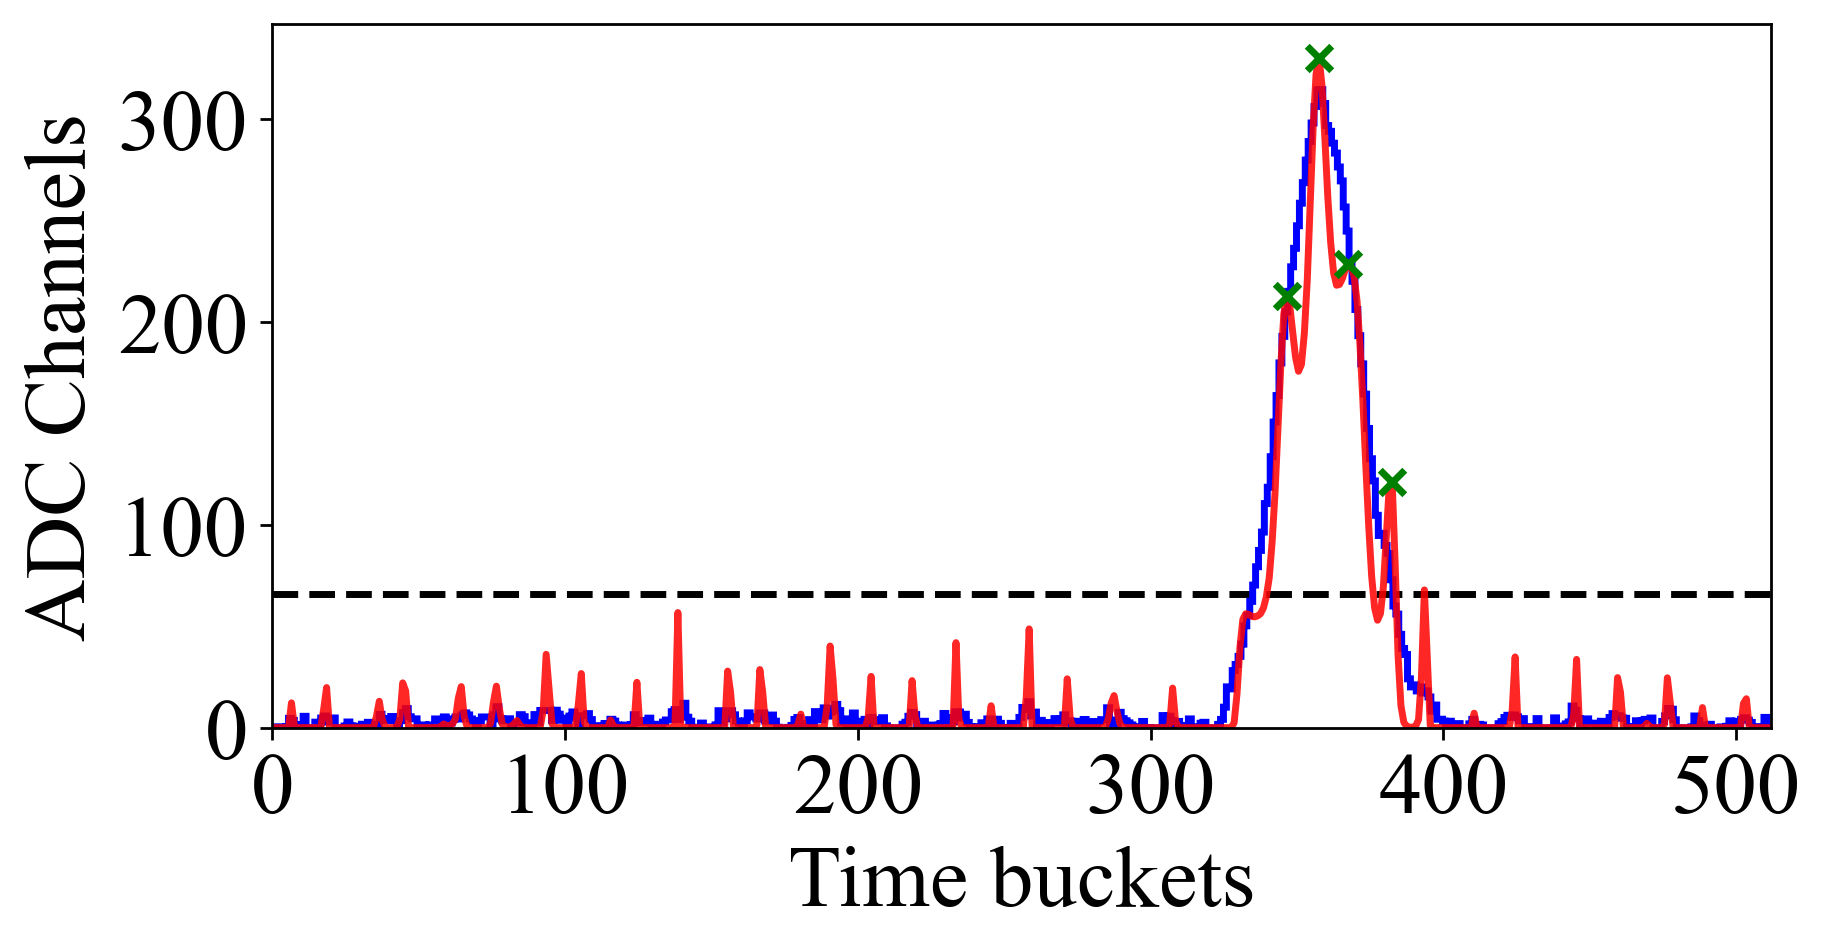

Saída num = 21484


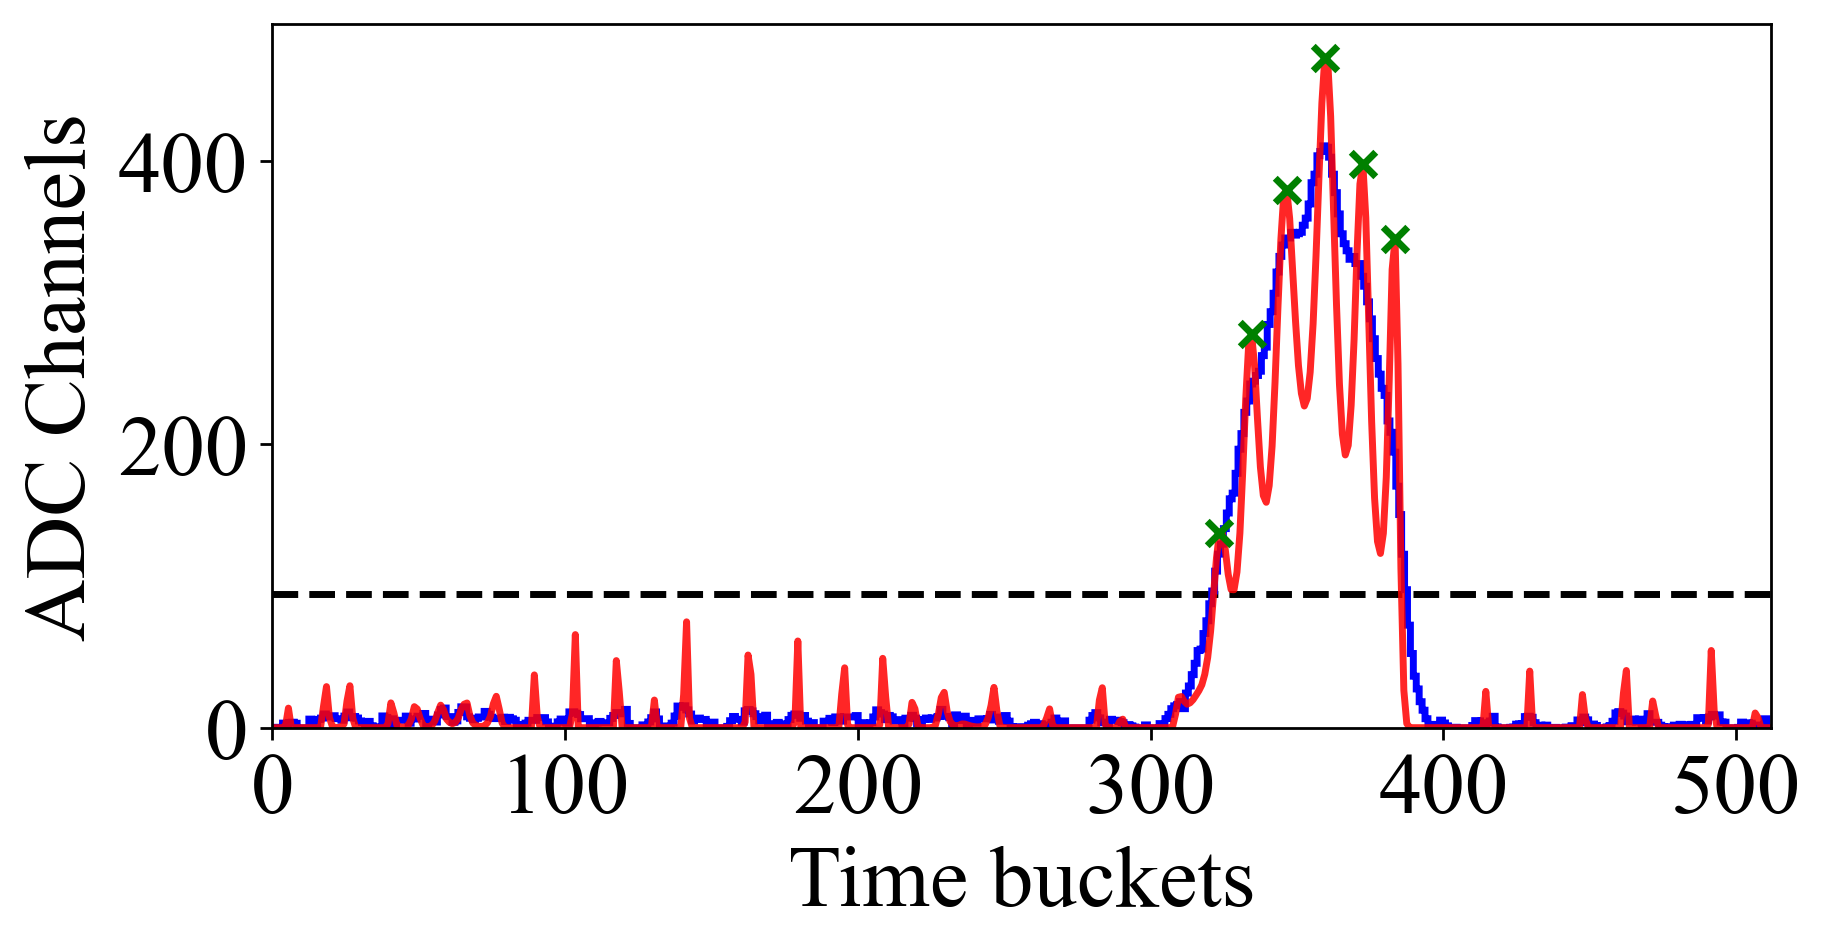

Saída num = 43115


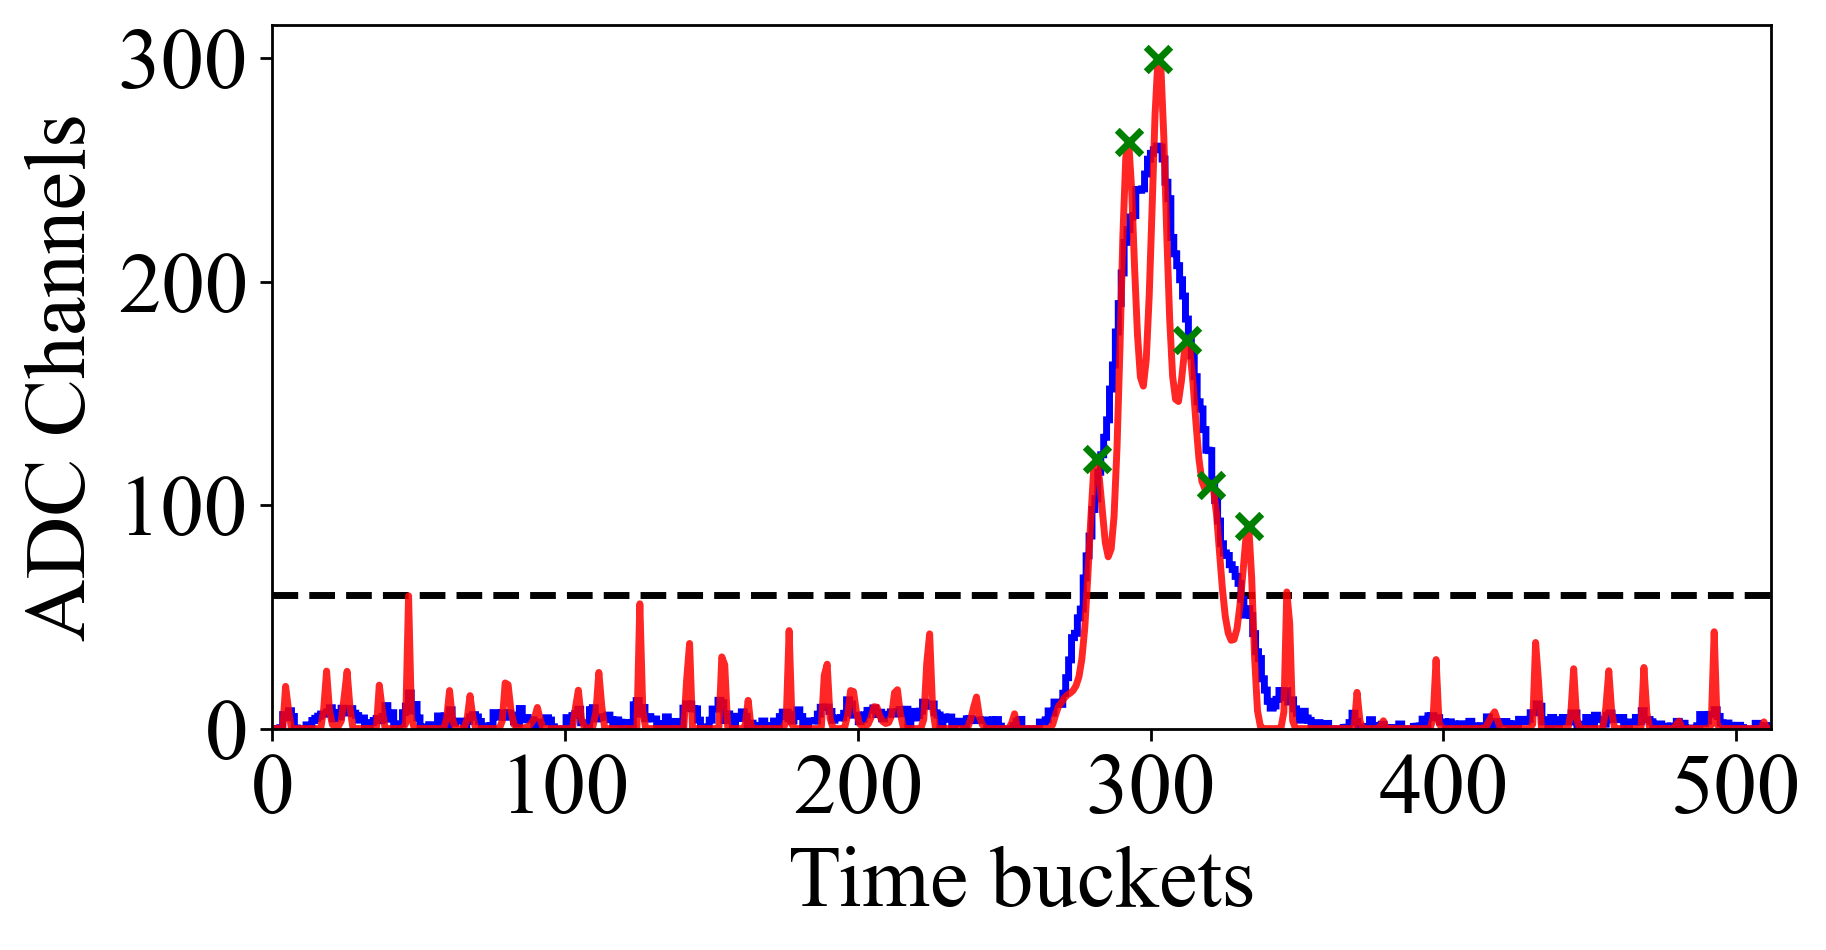

In [11]:
fonte = 12
d = {110413 : 1, 116959 : 2, 21484 : 3, 43115 : 4}
# num = 43115
# num = 74036
# num = 176082
# num = 43115
for num in d.keys():
    print(f"Saída num = {num}")
    picos_deconv = peaksDeconv[num].astype(float).round().astype(int)
    fig = plt.figure(dpi = 250, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    # plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
    plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
    # plt.plot(xt, CFD[num], lw = 2, c = "red", ls = "-", label = "CFD", alpha = 0.85, zorder = 2)
    plt.plot(xt, y2_scaled[num], lw = 2, c = "red", ls = "-", label = "Sinal após deconvolução", alpha = 0.85, zorder = 2)
    plt.scatter(xt[picos_deconv], y2_scaled[num][picos_deconv], marker = "x", lw = 2, zorder = 3, alpha = 1., s = 50, c = "green", label = "Pico")
    # plt.plot(xt, y2[num], lw = 2, c = "red", ls = "-", label = "Espectro deconvolucionado", alpha = 0.85, zorder = 2)
    # plt.scatter(xt[picos_deconv], y2[num][picos_deconv], marker = "x", lw = 2, zorder = 3, alpha = 1., s = 50, c = "green", label = "Picos detectados")
    plt.axhline(y = y2_scaled[num].max()*0.2, ls = "--", lw = 2., c = "black", zorder = 0, label = "Limiar de detecção")
    # plt.plot(xt, y2[num], lw = 2, c = "green", label = "Resultado correto")
    # plt.plot(xt, predictions[num].reshape(-1), lw = 2, ls = "--", c = "red", label = "Resultado do modelo")
    if num == 110413:
        plt.legend(fontsize = 16, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte - 5) # Size here overrides font_prop
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    # plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.xticks(np.arange(0, 512, 100))
    # plt.legend()
    plt.tight_layout()
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/ex_deconv_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()

# 110413 116959 21484 120060
#                     43115
# 55865

# Fundo: CNN vs fourier

Saída num = 155647


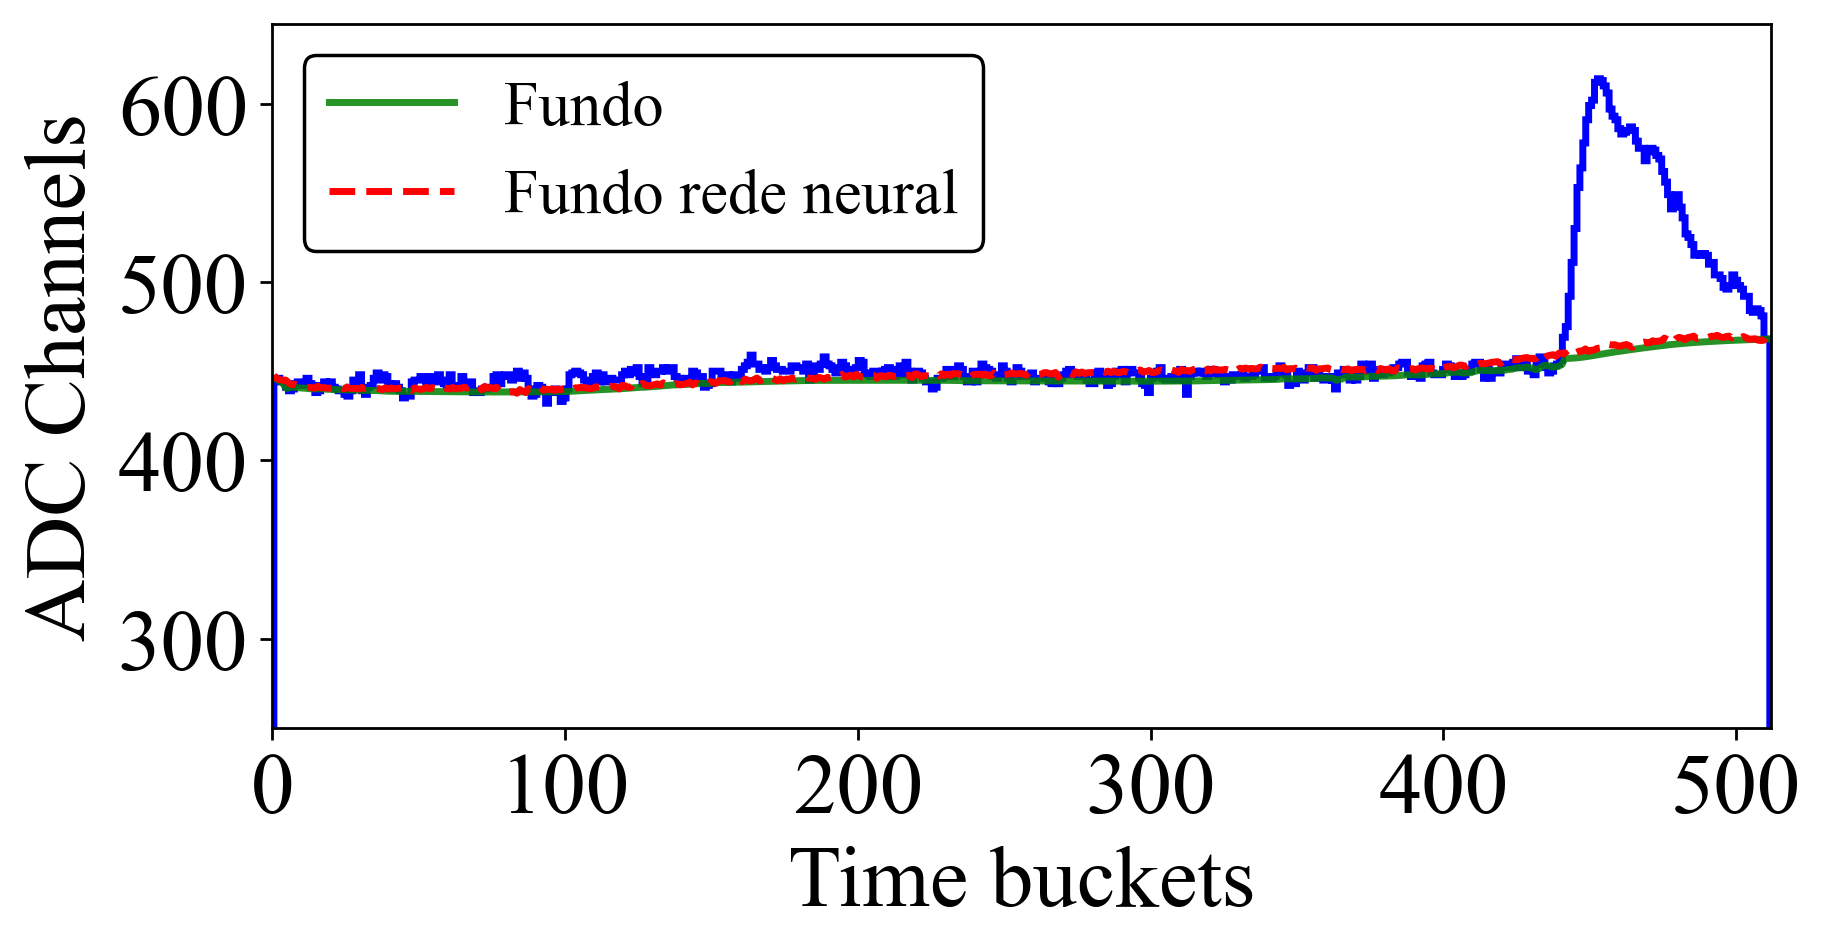

Saída num = 162599


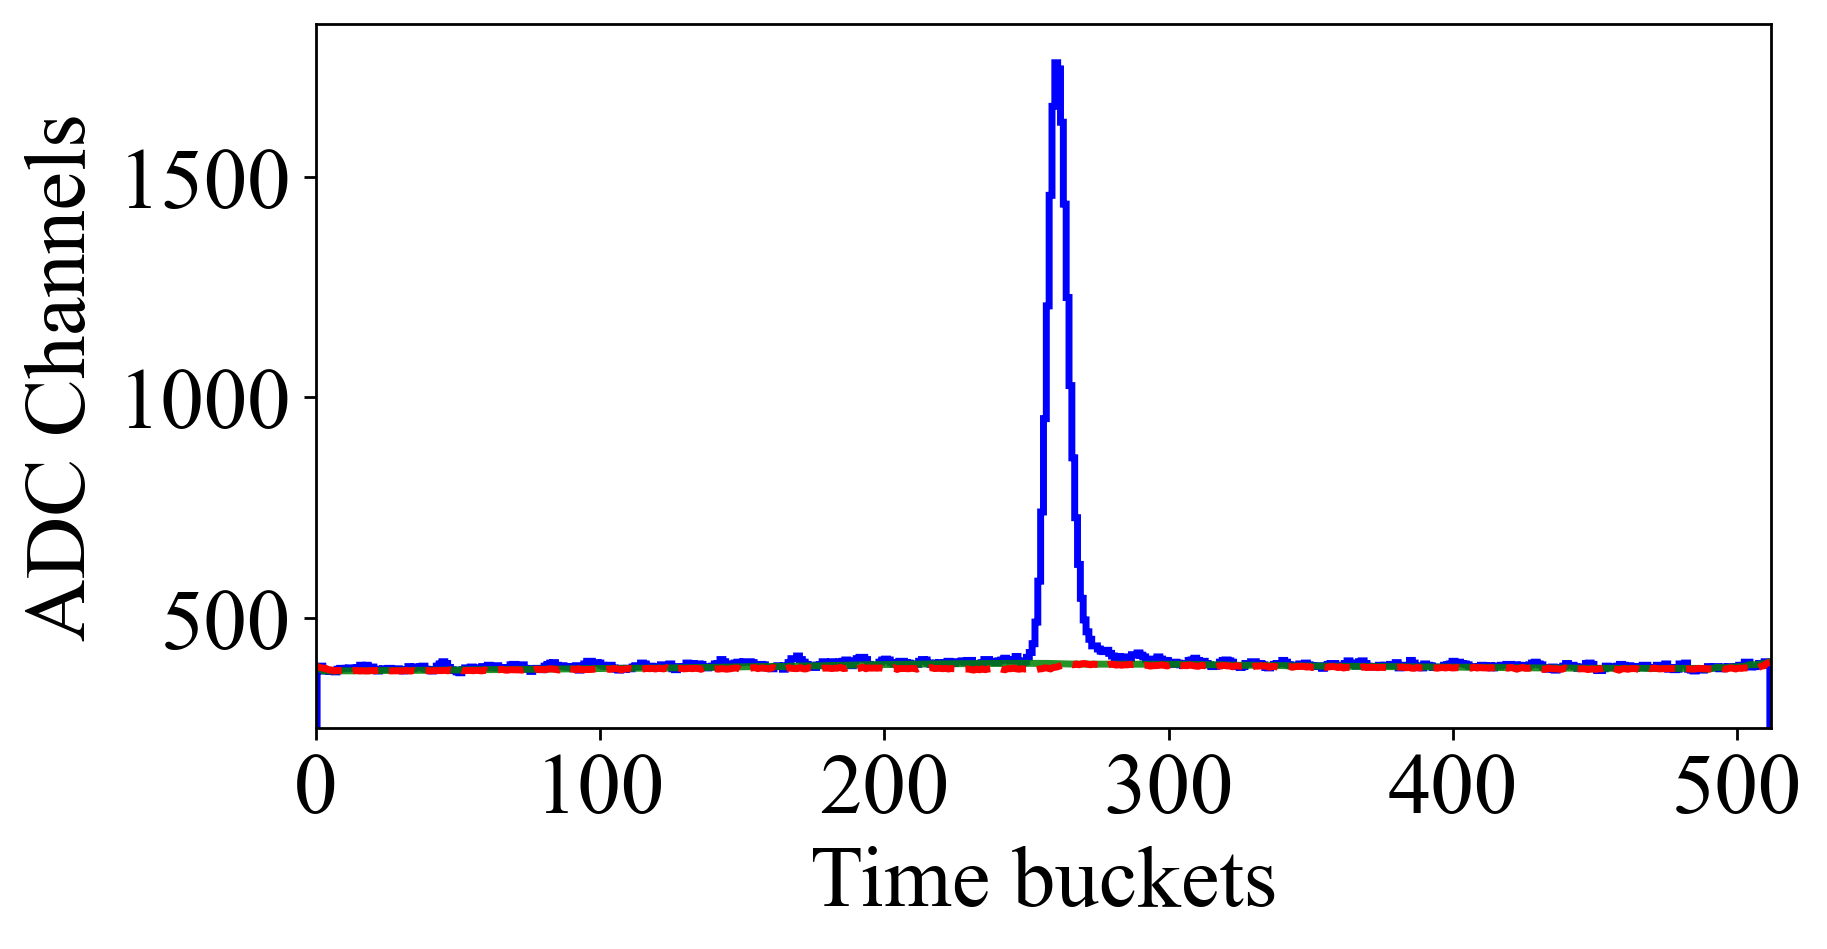

Saída num = 103332


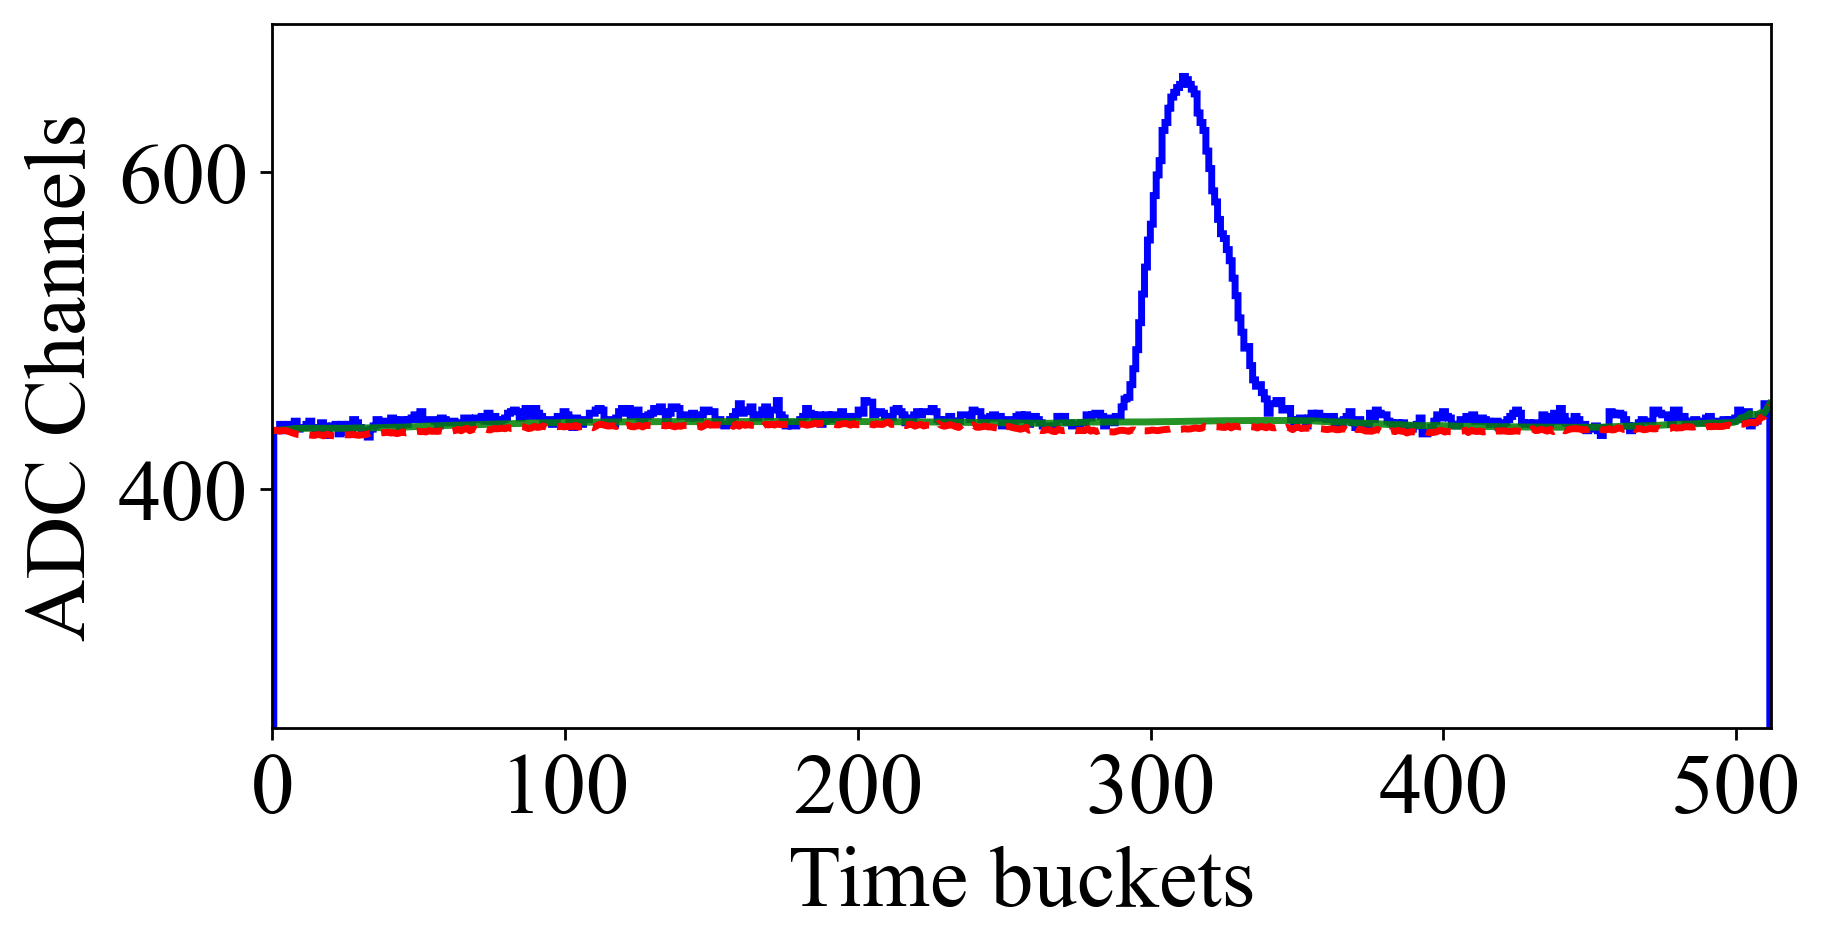

Saída num = 147589


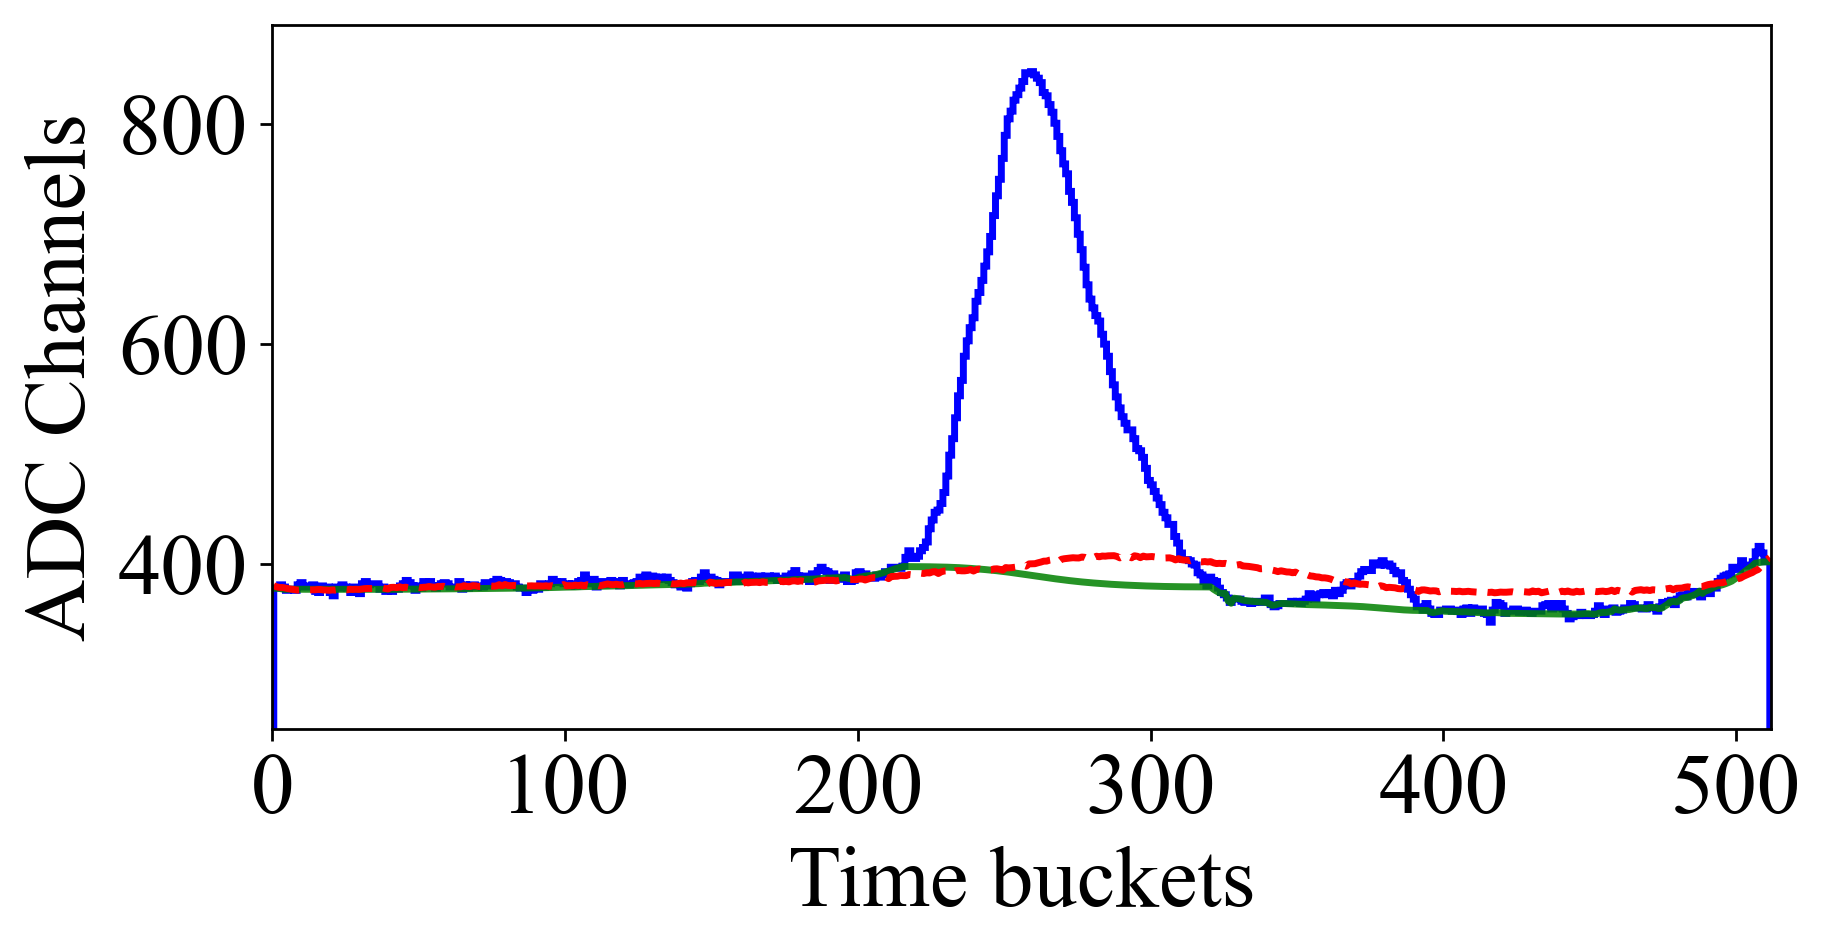

In [12]:
fonte = 12
predictions = np.load("BKG_predict.npy", allow_pickle = True)
xt = np.arange(0.5, 512, 1)
d = {155647 : 1, 162599 : 2, 103332 : 3, 147589 : 4}
# num = 155647
# num = 162599
# num = 103332
# num = 147589
for num in d.keys():
    print(f"Saída num = {num}")
    picos_deconv = peaksDeconv[num].astype(float).round().astype(int)
    fig = plt.figure(dpi = 250, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    # plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
    plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
    # plt.plot(xt, CFD[num], lw = 2, c = "red", ls = "-", label = "CFD", alpha = 0.85, zorder = 2)
    plt.plot(xt, BKG[num], lw = 2, c = "green", ls = "-", label = "Fundo", alpha = 0.85, zorder = 2)
    plt.plot(xt, predictions[d[num] - 1].reshape(-1), lw = 2, ls = "--", c = "red", label = "Fundo rede neural")
    if num == 155647:
        plt.legend(fontsize = 18, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte - 5) # Size here overrides font_prop
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    # plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.xticks(np.arange(0, 512, 100))
    plt.ylim(bottom = 250)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/stb_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()
# 155647, 162599, 103332, 147589

# Deconvolução: CNN vs gold deconvolution

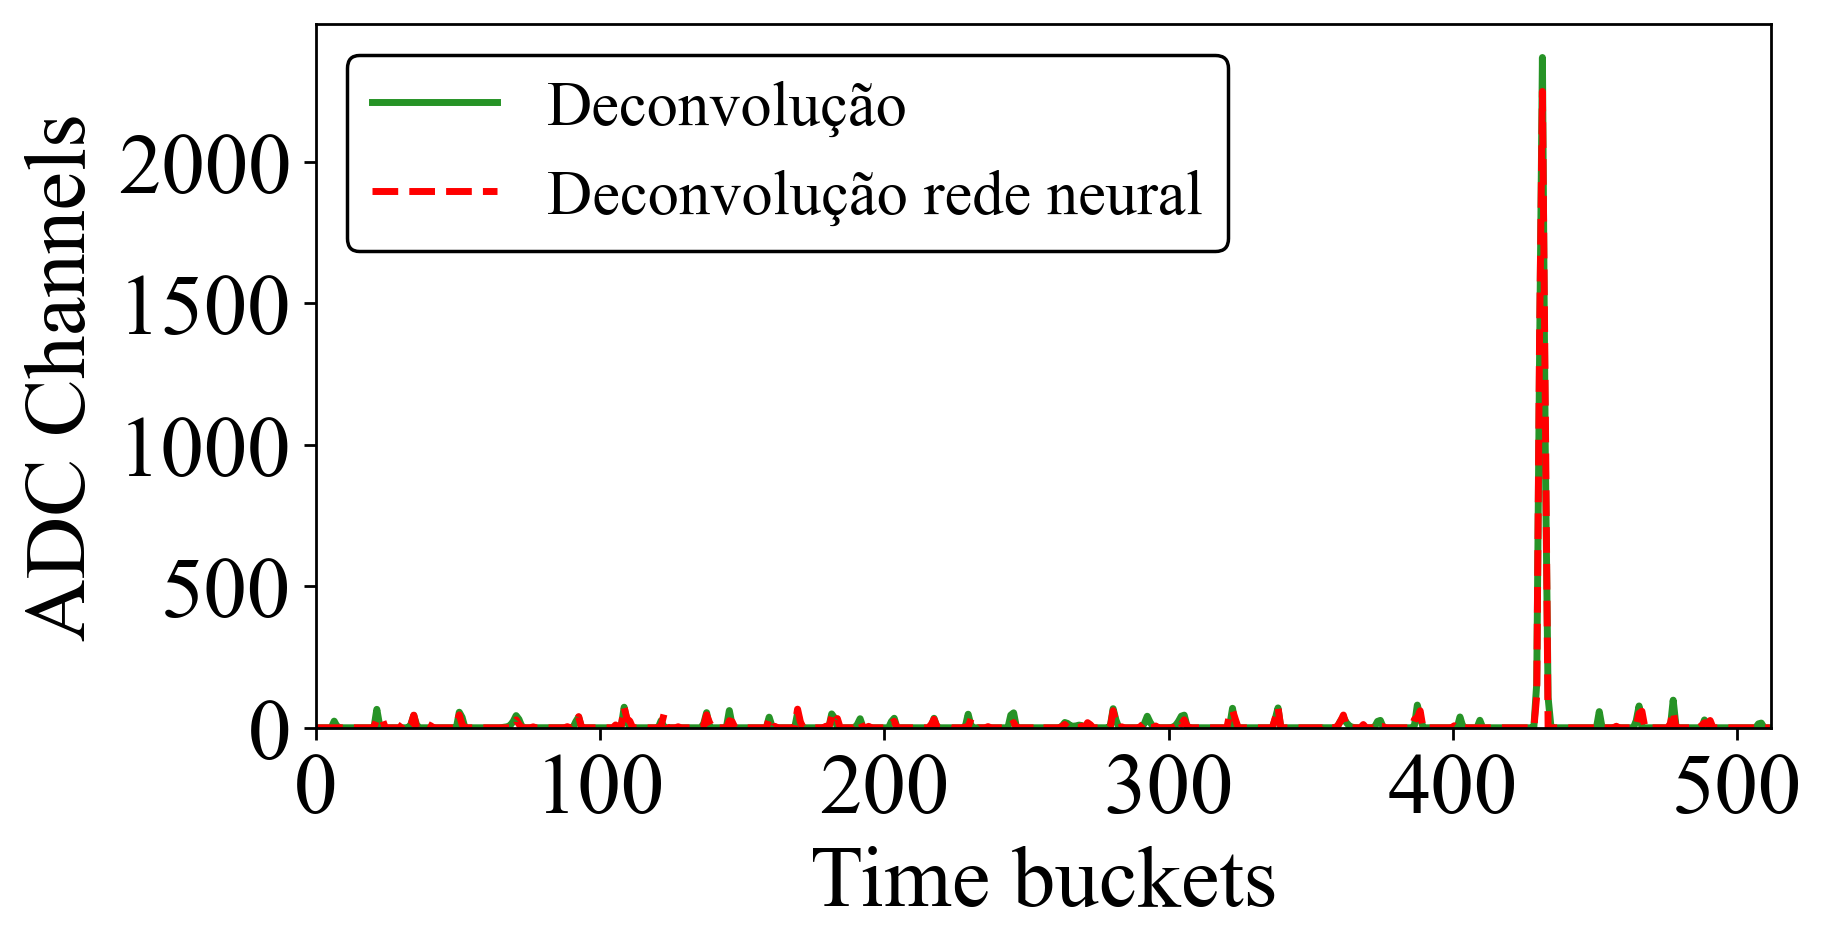

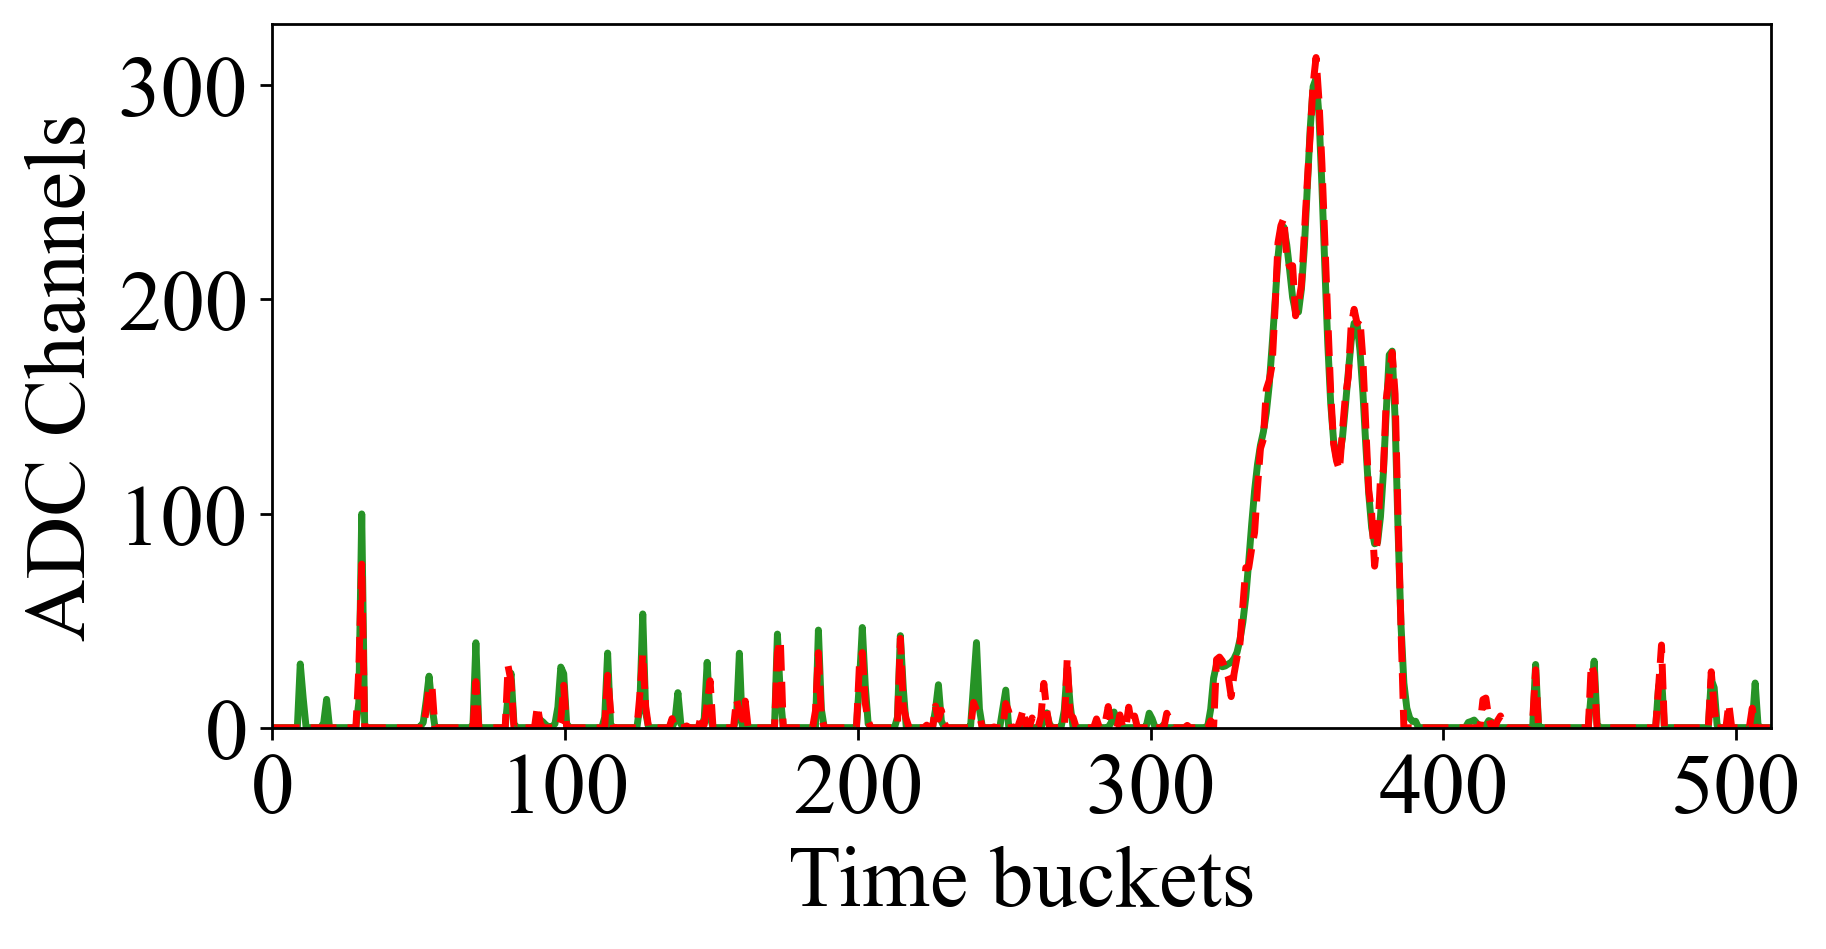

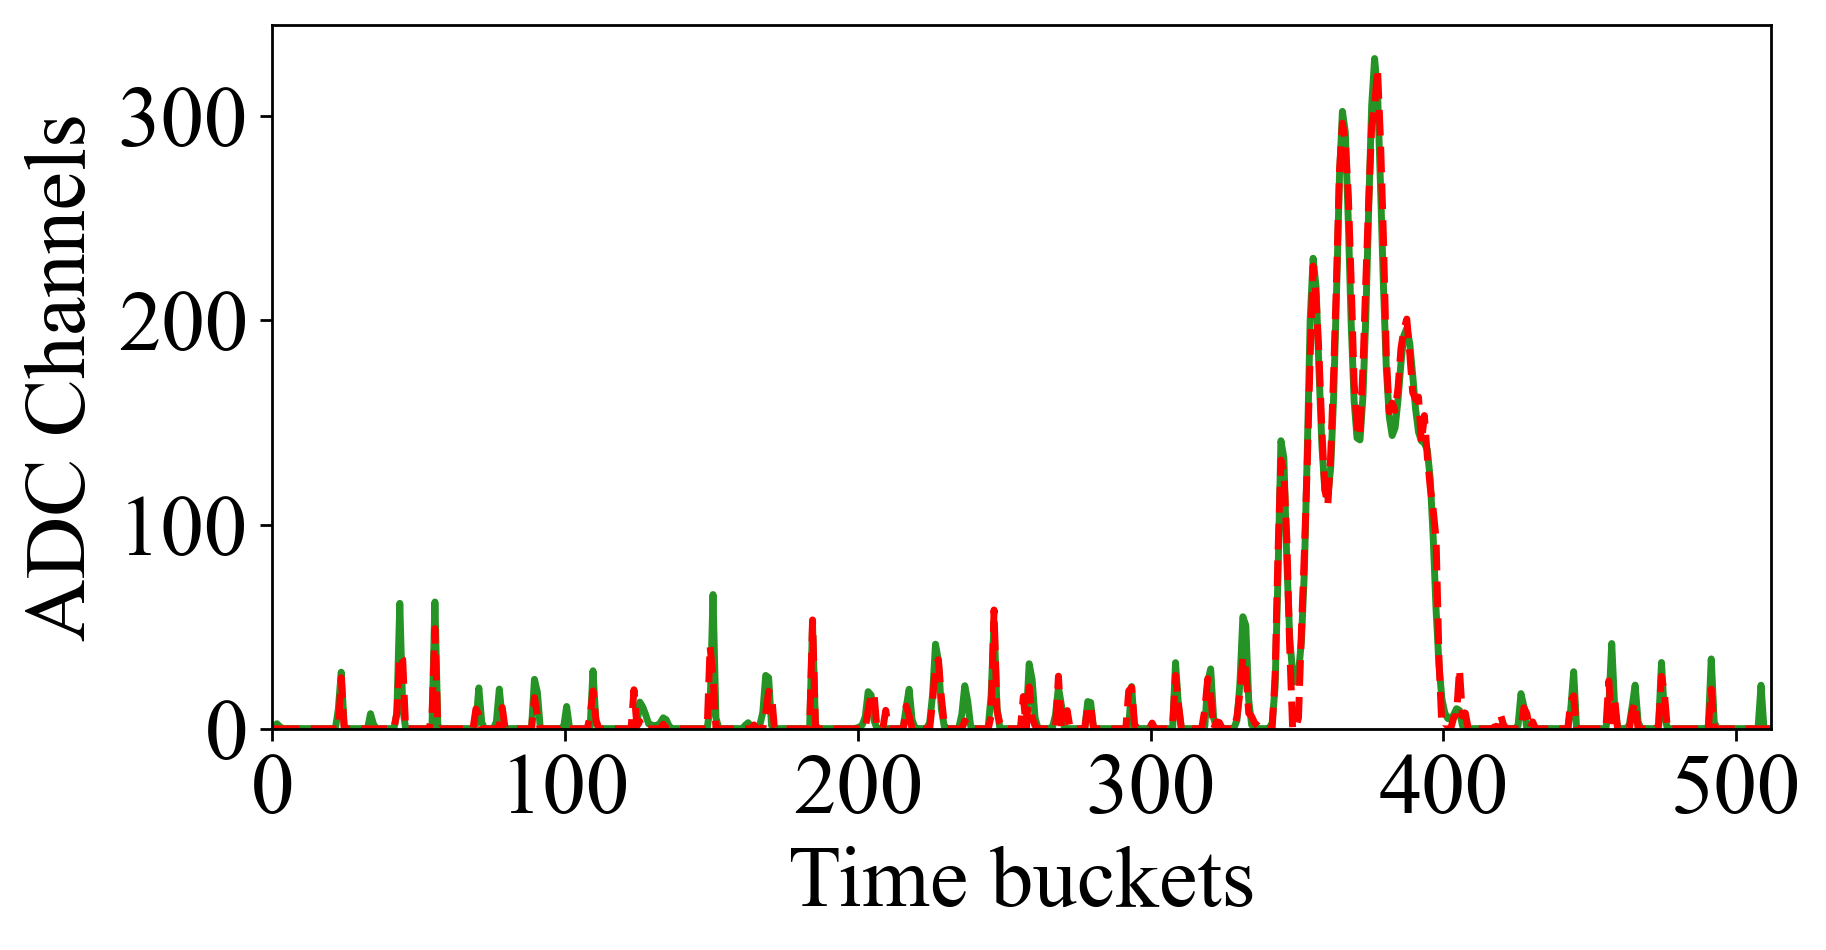

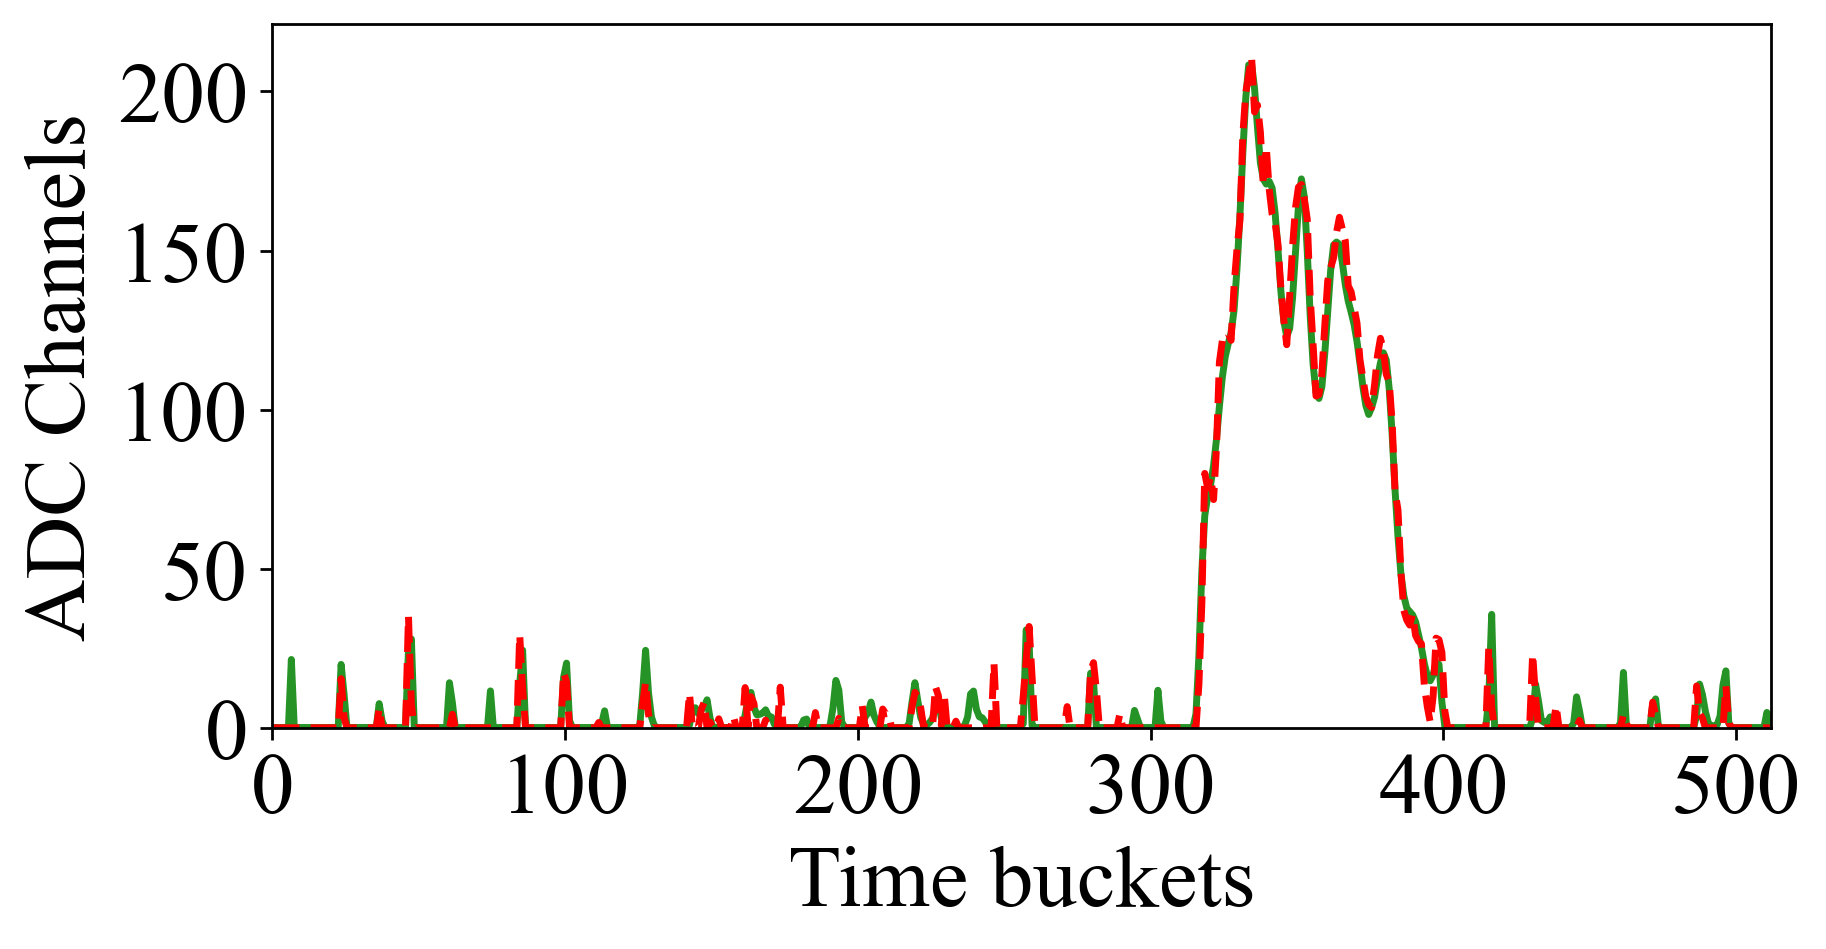

In [13]:
fonte = 12
predictions = np.load("DECV_predict.npy", allow_pickle = True)
xt = np.arange(0.5, 512, 1)
d = {18800 : 1, 148 : 2, 30527 : 3, 84214 : 4}
# num = 18800
# num = 148
# num = 30527
# num = 84214
for num in d.keys():
    # print(f"Saída num = {num}")
    picos_deconv = peaksDeconv[num].astype(float).round().astype(int)
    fig = plt.figure(dpi = 250, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    # plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
    # plt.hist(xt, weights = x1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
    # plt.plot(xt, CFD[num], lw = 2, c = "red", ls = "-", label = "CFD", alpha = 0.85, zorder = 2)
    plt.plot(xt, y2_scaled[num], lw = 2, c = "green", ls = "-", label = "Deconvolução", alpha = 0.85, zorder = 2)
    plt.plot(xt, predictions[d[num] - 1].reshape(-1), lw = 2, ls = "--", c = "red", label = "Deconvolução rede neural")
    # if num == 18800:
    #     plt.legend(fontsize = 18, framealpha = 1., edgecolor = "black", loc = 2)
    # for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
    #     # label.set_fontproperties(font_prop)
    #     label.set_fontsize(fonte - 5) # Size here overrides font_prop
    # plt.xlabel("Buckets", fontsize = fonte)
    # plt.ylabel("ADC Charge", fontsize = fonte)
    plt.xlim(left = 0., right = 512.)
    if num == 18800:
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(500))
        plt.legend(fontsize = 18, framealpha = 1., edgecolor = "black", loc = 2)
    elif num == 84214:
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(50))
    else:
        plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.xticks(np.arange(0, 512, 100))
    plt.ylim(bottom = 0)
    # plt.legend()
    plt.tight_layout()
    plt.savefig(f"imagens/swbtd_{d[num]}.png", dpi = 600, bbox_inches='tight')
    plt.show()
    # 18800, 148, 30527, 84214

# Loss e métrica por epoch

In [18]:
# df = pd.read_csv("./dados/DECONVCNN_BKG_TO_DECONV_700.csv")
df = pd.read_csv("./dados/CSVSDECONVCNN_SOURCE_TO_ONLY_BKG.csv")

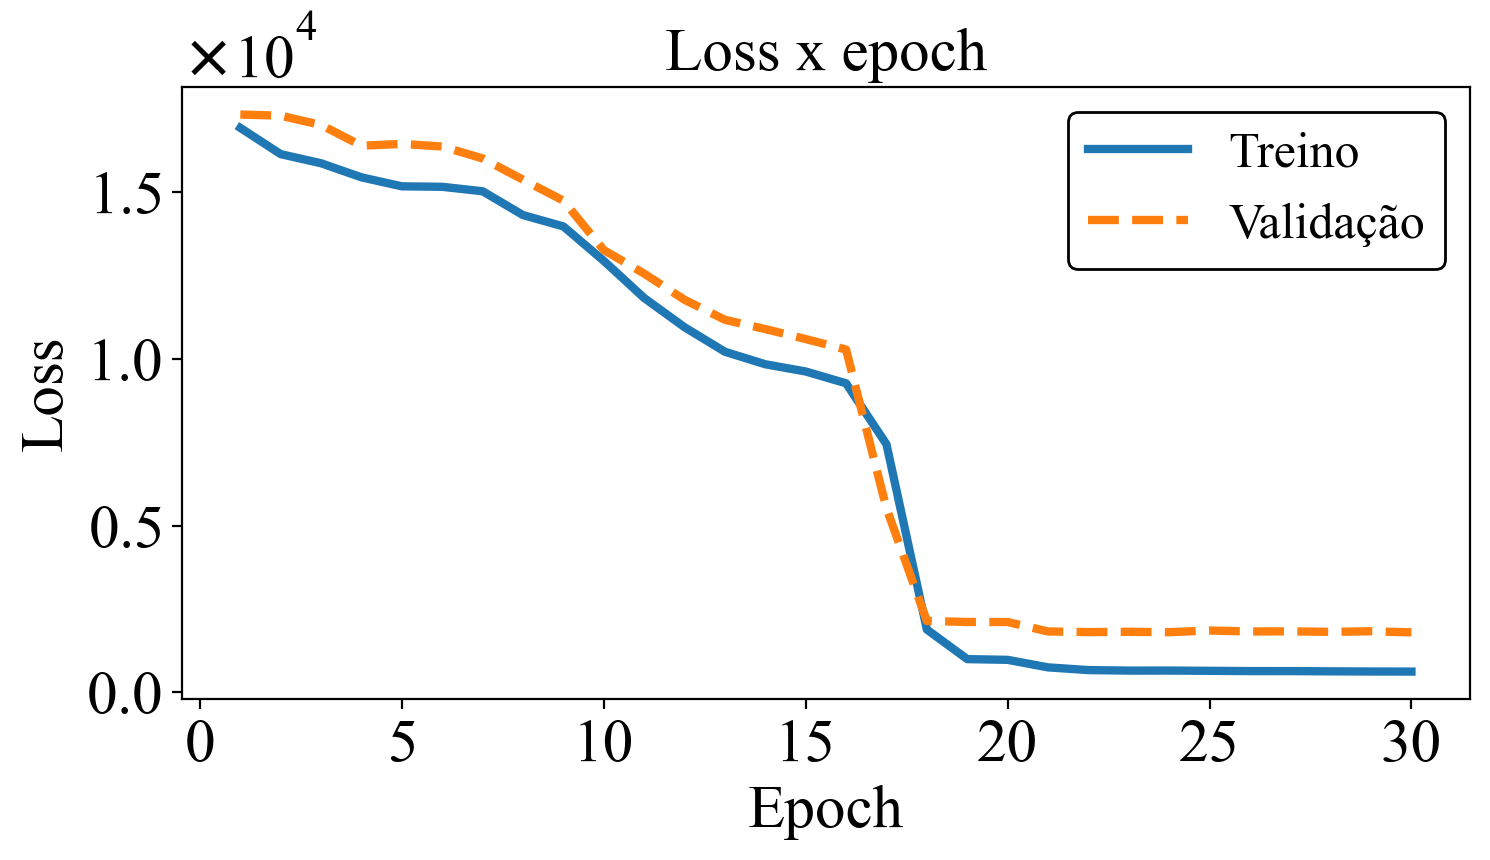

In [19]:
fonte = 20
fig = plt.figure(dpi = 200, figsize = (8, 4.85))
fig.patch.set_facecolor('white')
plt.plot(np.arange(1, len(df) + 1, 1), df["loss"], lw = 3, label = "Treino")
plt.plot(np.arange(1, len(df) + 1, 1), df["val_loss"], ls = "--", lw = 3, label = "Validação")
# plt.xlabel("Epoch", fontsize = fonte)
# plt.ylabel("Loss", fontsize = fonte)
plt.xlabel("Epoch")
plt.ylabel("Loss")
# scale_y = 1e3
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# fig.gca().yaxis.set_major_formatter(ticks_y)
plt.ticklabel_format(axis = "y", style = "sci", scilimits=(3, 4), useMathText = True)
plt.title("Loss x epoch")
plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black")
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3000))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
plt.tight_layout()
# plt.savefig(f"imagens/source_wo_bkg_to_deconv_loss.png", dpi = 600, bbox_inches='tight')
plt.savefig(f"imagens/source_to_bkg_loss.png", dpi = 600, bbox_inches='tight')
plt.show()

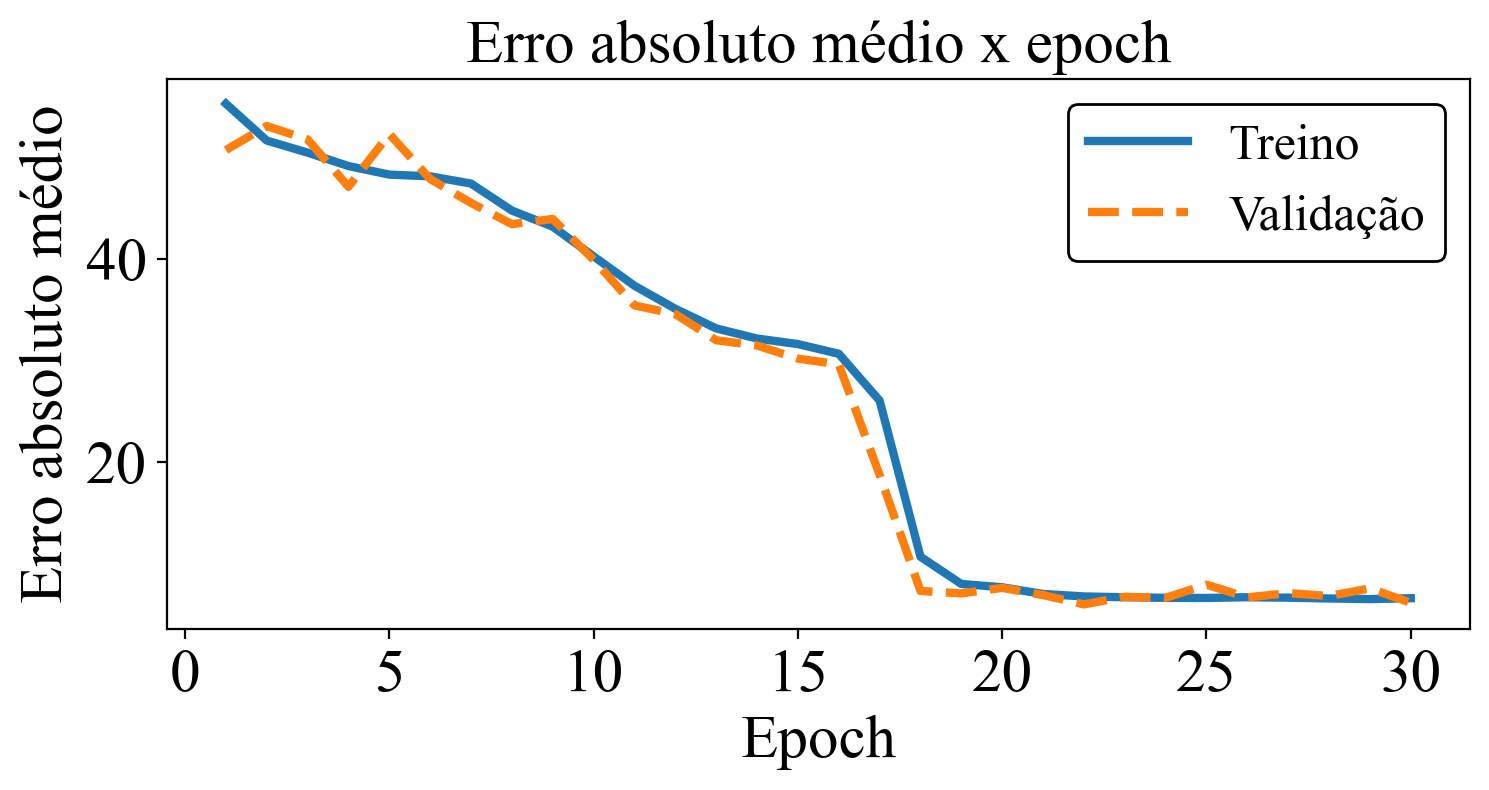

In [20]:
fonte = 20
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
plt.plot(np.arange(1, len(df) + 1, 1), df["mean_absolute_error"], lw = 3, label = "Treino")
plt.plot(np.arange(1, len(df) + 1, 1), df["val_mean_absolute_error"], ls = "--", lw = 3, label = "Validação")
# plt.plot(np.arange(1, len(df) + 1, 1), df["binary_accuracy"], lw = 3, label = "Acurácia binária treino")
# plt.plot(np.arange(1, len(df) + 1, 1), df["val_binary_accuracy"], ls = "--", lw = 3, label = "Acurácia binária validação")
plt.xlabel("Epoch")
plt.ylabel("Erro absoluto médio")
plt.title("Erro absoluto médio x epoch")
plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black")
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.tight_layout()
# plt.savefig(f"imagens/source_wo_bkg_to_deconv_metric.png", dpi = 600, bbox_inches='tight')
plt.savefig(f"imagens/source_to_bkg_metric.png", dpi = 600, bbox_inches='tight')
plt.show()

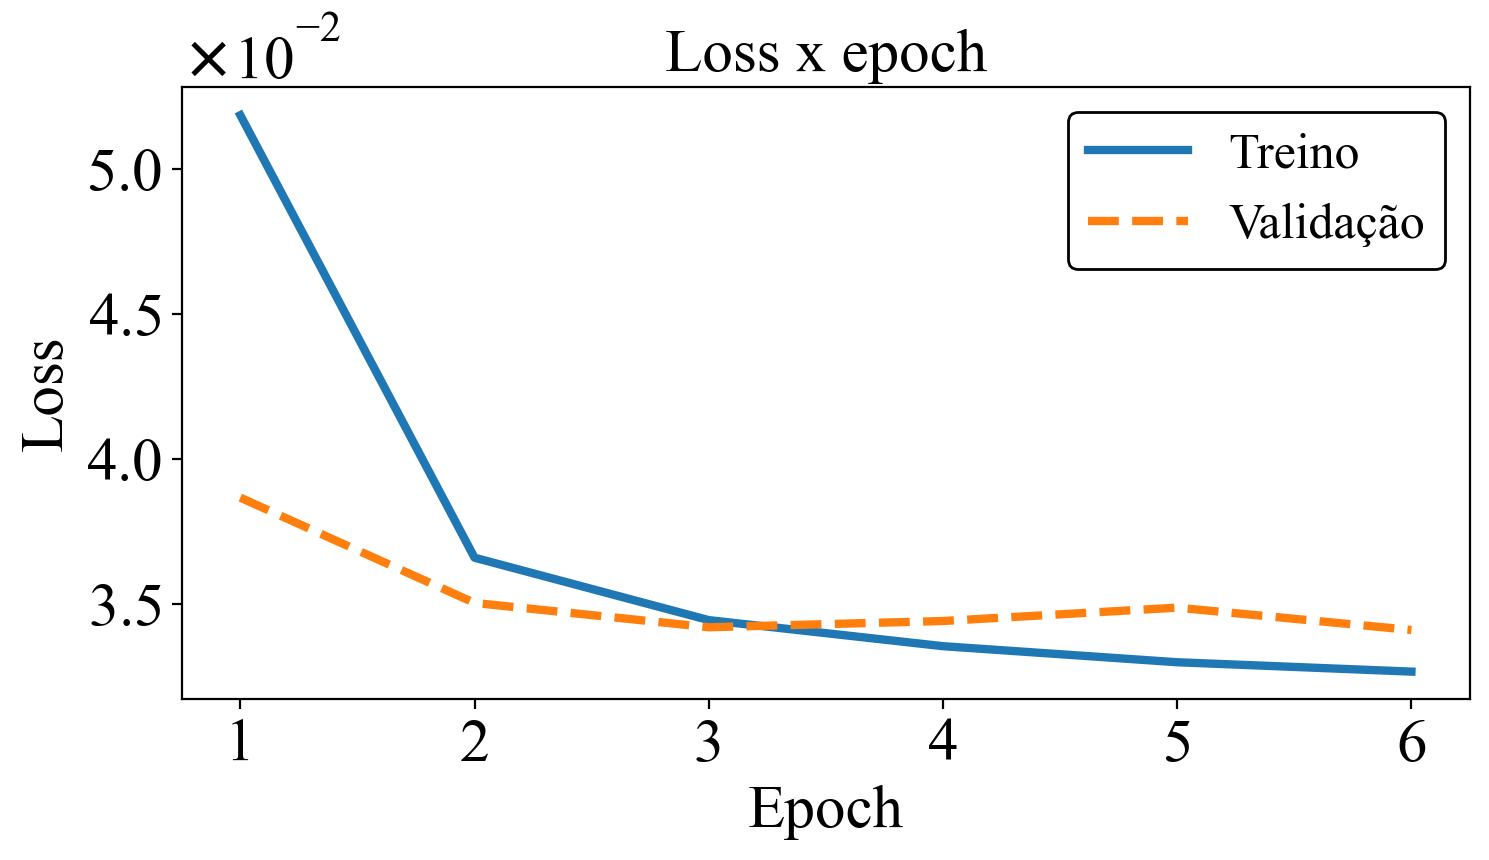

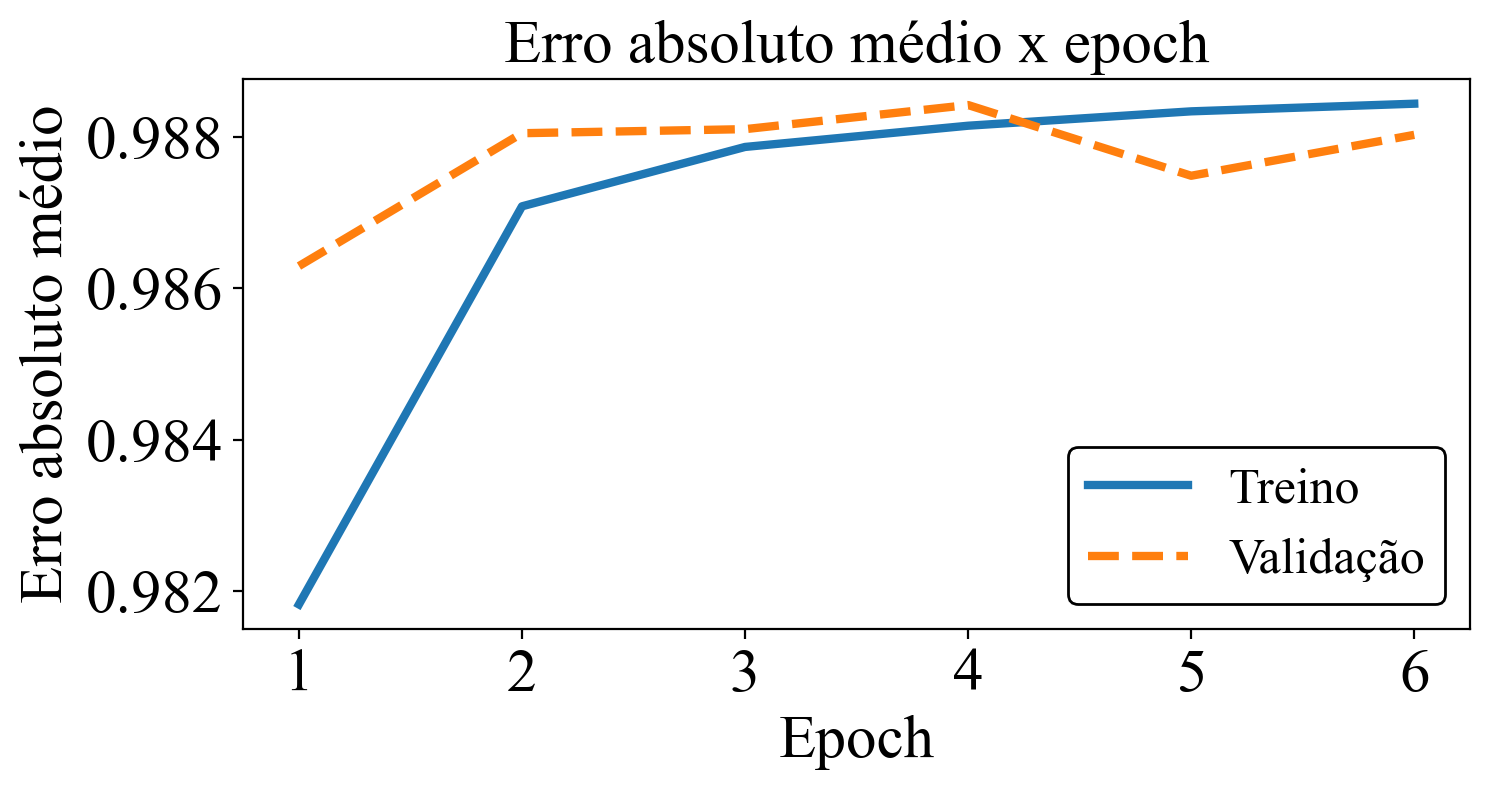

In [2]:
df = pd.read_csv("./dados/DECONVCNN_TO_N_PEAKS.csv")

fonte = 20
fig = plt.figure(dpi = 200, figsize = (8, 4.85))
fig.patch.set_facecolor('white')
plt.plot(np.arange(1, len(df) + 1, 1), df["loss"], lw = 3, label = "Treino")
plt.plot(np.arange(1, len(df) + 1, 1), df["val_loss"], ls = "--", lw = 3, label = "Validação")
# plt.xlabel("Epoch", fontsize = fonte)
# plt.ylabel("Loss", fontsize = fonte)
plt.xlabel("Epoch")
plt.ylabel("Loss")
# scale_y = 1e3
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# fig.gca().yaxis.set_major_formatter(ticks_y)
plt.ticklabel_format(axis = "y", style = "sci", scilimits=(3, 4), useMathText = True)
plt.title("Loss x epoch")
plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black")
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3000))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
plt.tight_layout()
# plt.savefig(f"imagens/source_wo_bkg_to_deconv_loss.png", dpi = 600, bbox_inches='tight')
plt.savefig(f"imagens/n_peaks_loss.png", dpi = 600, bbox_inches='tight')
plt.show()

fonte = 20
fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.plot(np.arange(1, len(df) + 1, 1), df["mean_absolute_error"], lw = 3, label = "Treino")
# plt.plot(np.arange(1, len(df) + 1, 1), df["val_mean_absolute_error"], ls = "--", lw = 3, label = "Validação")
plt.plot(np.arange(1, len(df) + 1, 1), df["binary_accuracy"], lw = 3, label = "Treino")
plt.plot(np.arange(1, len(df) + 1, 1), df["val_binary_accuracy"], ls = "--", lw = 3, label = "Validação")
plt.xlabel("Epoch")
plt.ylabel("Erro absoluto médio")
plt.title("Erro absoluto médio x epoch")
plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black")
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.tight_layout()
# plt.savefig(f"imagens/source_wo_bkg_to_deconv_metric.png", dpi = 600, bbox_inches='tight')
plt.savefig(f"imagens/n_peaks_metric.png", dpi = 600, bbox_inches='tight')
plt.show()

# CNNS 300 it deconv

Saída num = 60334


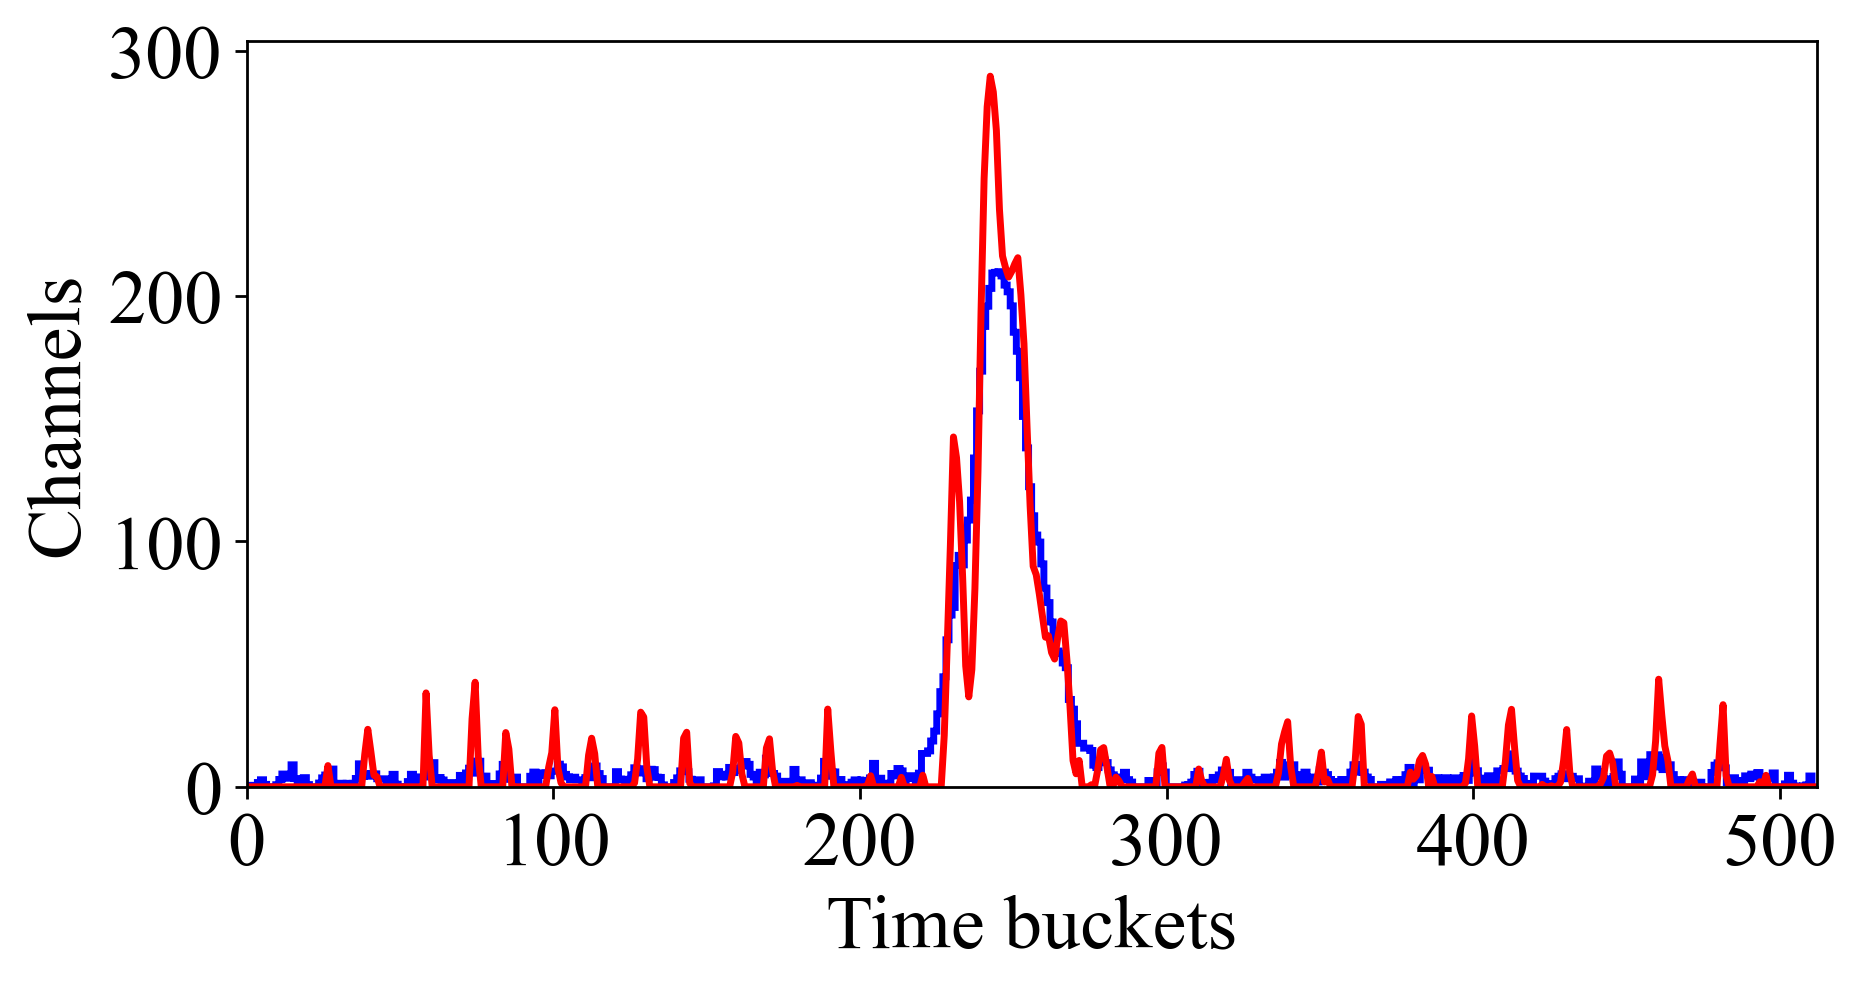

In [17]:
cnns = np.load("./dados/deconv_300_it.npy", allow_pickle = True)
fonte = 12
d = {18800 : 0, 148 : 1, 110413 : 2, 21484 : 3, 60334 : 4}
# num = 18800
# num = 148
# num = 110413
# num = 21484
num = 60334
print(f"Saída num = {num}")
# picos_deconv = peaksDeconv[num].astype(float).round().astype(int)
fig = plt.figure(dpi = 250, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1, label = "Raw signal w/o baseline")
# plt.plot(xt, CFD[num], lw = 2, c = "red", ls = "-", label = "CFD", alpha = 0.85, zorder = 2)
# plt.plot(xt, y2_scaled[num], lw = 2, c = "red", ls = "-", label = "Sinal após deconvolução", alpha = 0.85, zorder = 2)
# plt.scatter(xt[picos_deconv], y2_scaled[num][picos_deconv], marker = "x", lw = 2, zorder = 3, alpha = 1., s = 50, c = "green", label = "Pico")
plt.plot(xt, cnns[d[num]]/0.8, lw = 2, c = "red", ls = "-", label = "CNN", alpha = 1., zorder = 2)
# plt.plot(xt, cnns[d[num]], lw = 2, c = "red", ls = "-", label = "CNN", alpha = 1., zorder = 2)
if num == 18800:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    print(list(by_label.keys()))
    nomes_1 = list(by_label.keys())
    lines_1 = list(by_label.values())
    nomes = [nomes_1[1], nomes_1[0]]
    lines = [lines_1[1], lines_1[0]]
    plt.legend(lines, nomes, fontsize = 16, framealpha = 1., edgecolor = "black", loc = 2)
    # plt.legend(fontsize = 16, framealpha = 1., edgecolor = "black", loc = 2)
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte - 5) # Size here overrides font_prop
# plt.xlabel("Buckets", fontsize = fonte)
# plt.ylabel("ADC Charge", fontsize = fonte)
plt.xlim(left = 0., right = 512.)
plt.ylim(bottom = 0.)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.xlabel("Time buckets")
plt.ylabel("ADC Channels")
plt.xticks(np.arange(0, 512, 100))
# plt.legend()
plt.tight_layout()
plt.savefig(f"imagens/deconv_300_{d[num]}.png", dpi = 600, bbox_inches='tight')
plt.show()

# CNN 700 it deconv

Saída num = 60334


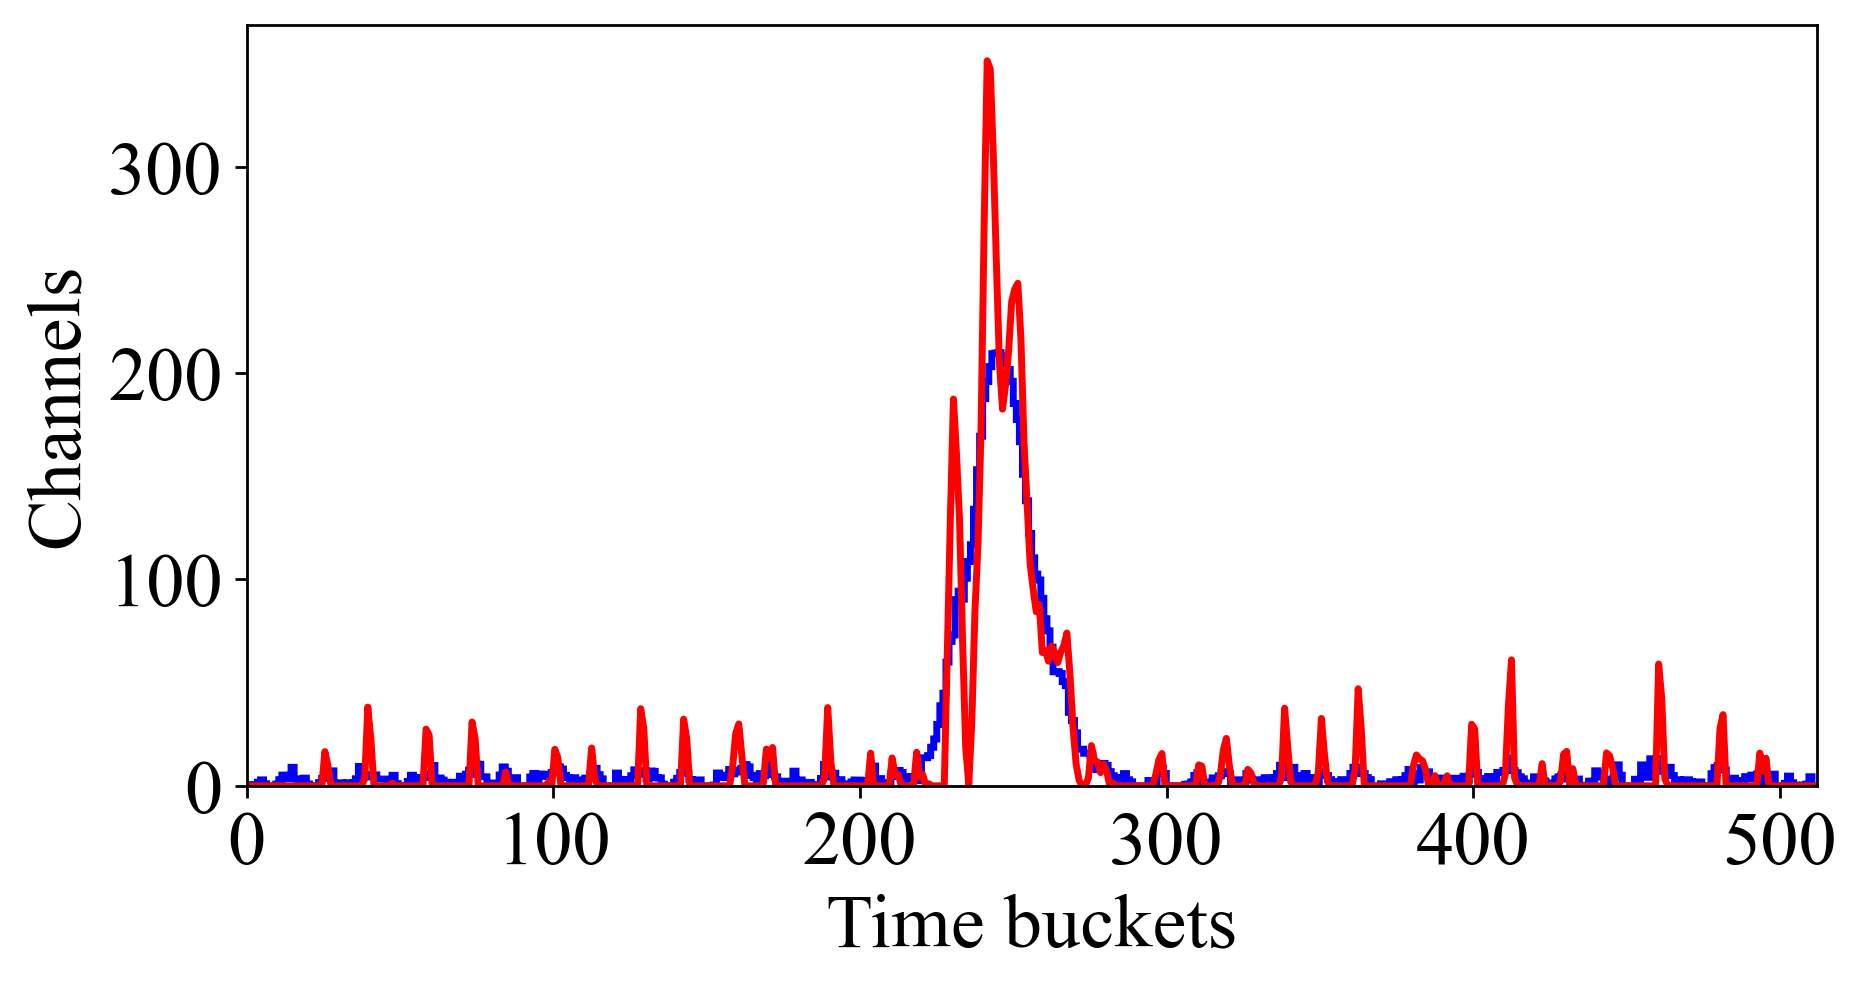

In [26]:
cnns = np.load("./dados/deconv_700_it.npy", allow_pickle = True)
fonte = 12
d = {18800 : 0, 148 : 1, 110413 : 2, 21484 : 3, 60334 : 4}
# num = 18800
# num = 148
# num = 110413
# num = 21484
num = 60334
print(f"Saída num = {num}")
# picos_deconv = peaksDeconv[num].astype(float).round().astype(int)
fig = plt.figure(dpi = 250, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1, label = "Raw signal w/o baseline")
# plt.plot(xt, CFD[num], lw = 2, c = "red", ls = "-", label = "CFD", alpha = 0.85, zorder = 2)
# plt.plot(xt, y2_scaled[num], lw = 2, c = "red", ls = "-", label = "Sinal após deconvolução", alpha = 0.85, zorder = 2)
# plt.scatter(xt[picos_deconv], y2_scaled[num][picos_deconv], marker = "x", lw = 2, zorder = 3, alpha = 1., s = 50, c = "green", label = "Pico")
plt.plot(xt, cnns[d[num]]/0.8, lw = 2, c = "red", ls = "-", label = "CNN", alpha = 1., zorder = 2)
# plt.plot(xt, cnns[d[num]], lw = 2, c = "red", ls = "-", label = "CNN", alpha = 1., zorder = 2)
if num == 18800:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    print(list(by_label.keys()))
    nomes_1 = list(by_label.keys())
    lines_1 = list(by_label.values())
    nomes = [nomes_1[1], nomes_1[0]]
    lines = [lines_1[1], lines_1[0]]
    plt.legend(lines, nomes, fontsize = 16, framealpha = 1., edgecolor = "black", loc = 2)
    # plt.legend(fontsize = 16, framealpha = 1., edgecolor = "black", loc = 2)
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte - 5) # Size here overrides font_prop
# plt.xlabel("Buckets", fontsize = fonte)
# plt.ylabel("ADC Charge", fontsize = fonte)
plt.xlim(left = 0., right = 512.)
plt.ylim(bottom = 0.)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.xlabel("Time buckets")
plt.ylabel("ADC Channels")
plt.xticks(np.arange(0, 512, 100))
# plt.legend()
plt.tight_layout()
plt.savefig(f"imagens/deconv_700_{d[num]}.png", dpi = 600, bbox_inches='tight')
plt.show()

# CNN 3000 it deconv

Saída num = 21484


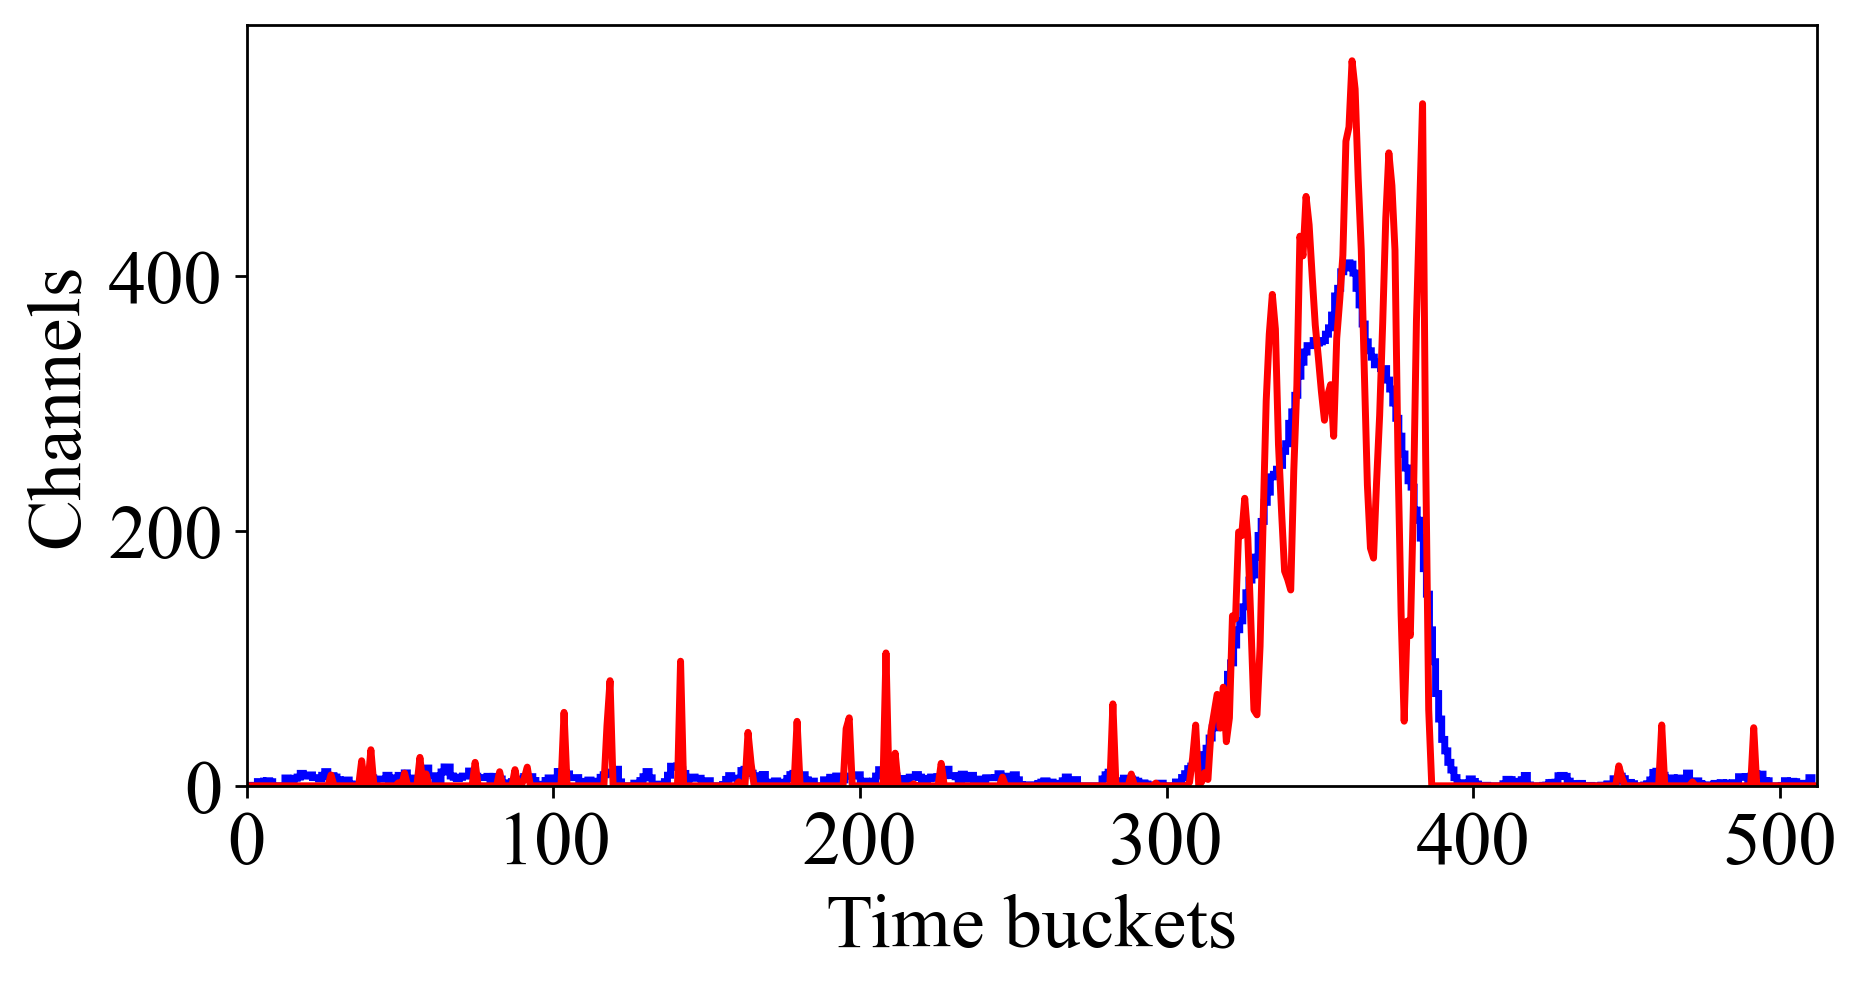

In [6]:
cnns = np.load("./dados/deconv_3000_it.npy", allow_pickle = True)
fonte = 12
d = {18800 : 0, 148 : 1, 110413 : 2, 21484 : 3, 60334 : 4}
# num = 18800
# num = 148
# num = 110413
num = 21484
# num = 60334
print(f"Saída num = {num}")
# picos_deconv = peaksDeconv[num].astype(float).round().astype(int)
fig = plt.figure(dpi = 250, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1)
plt.hist(xt, weights = y1[num], lw = 2, bins = 512, color = "blue", histtype = "step", zorder = 1, label = "Raw signal w/o baseline")
# plt.plot(xt, CFD[num], lw = 2, c = "red", ls = "-", label = "CFD", alpha = 0.85, zorder = 2)
# plt.plot(xt, y2_scaled[num], lw = 2, c = "red", ls = "-", label = "Sinal após deconvolução", alpha = 0.85, zorder = 2)
# plt.scatter(xt[picos_deconv], y2_scaled[num][picos_deconv], marker = "x", lw = 2, zorder = 3, alpha = 1., s = 50, c = "green", label = "Pico")
plt.plot(xt, cnns[d[num]]/0.85, lw = 2, c = "red", ls = "-", label = "CNN", alpha = 1., zorder = 2)
# plt.plot(xt, cnns[d[num]], lw = 2, c = "red", ls = "-", label = "CNN", alpha = 1., zorder = 2)
if num == 18800:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    print(list(by_label.keys()))
    nomes_1 = list(by_label.keys())
    lines_1 = list(by_label.values())
    nomes = [nomes_1[1], nomes_1[0]]
    lines = [lines_1[1], lines_1[0]]
    plt.legend(lines, nomes, fontsize = 16, framealpha = 1., edgecolor = "black", loc = 2)
    # plt.legend(fontsize = 16, framealpha = 1., edgecolor = "black", loc = 2)
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte - 5) # Size here overrides font_prop
# plt.xlabel("Buckets", fontsize = fonte)
# plt.ylabel("ADC Charge", fontsize = fonte)
plt.xlim(left = 0., right = 512.)
plt.ylim(bottom = 0.)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(1000))
plt.xlabel("Time buckets")
plt.ylabel("ADC Channels")
plt.xticks(np.arange(0, 512, 100))
# plt.legend()
plt.tight_layout()
plt.savefig(f"imagens/deconv_3000_{d[num]}.png", dpi = 600, bbox_inches='tight')
plt.show()

# DBSCAN delta E - E

In [3]:
def partial(dist, num):
    X = np.load("r_hist2d.npy")
    w = np.load("w.npy")
    x2 = []
    for i in X:
        x2.append(i.tolist())
    X = StandardScaler(with_mean=False, with_std=False).fit_transform(X)
    
    # #############################################################################
    # Compute DBSCAN

    # Métricas possíveis: manhattann, cityblock, euclidian, l1, l2, cosine   
    db = DBSCAN(eps=dist, min_samples=num, metric = 'l2').fit(X, sample_weight = w)
    return db

db = partial(70, 420)

Estimated number of clusters: 4
Estimated number of noise points: 58


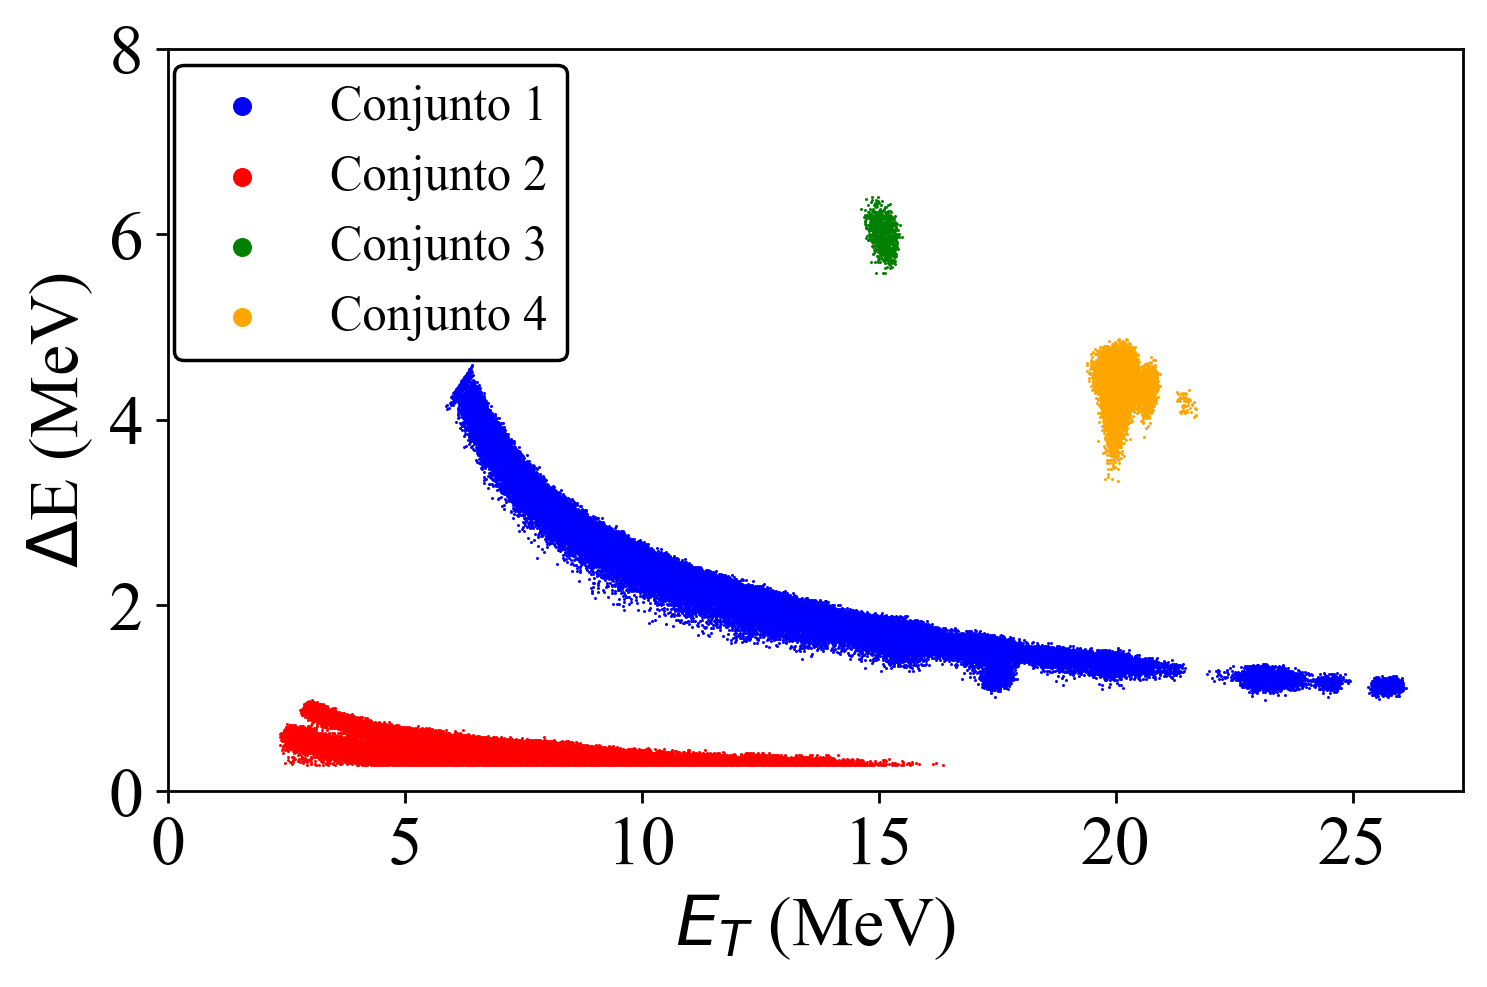

{'algorithm': 'auto', 'eps': 70, 'leaf_size': 30, 'metric': 'l2', 'metric_params': None, 'min_samples': 420, 'n_jobs': None, 'p': None}


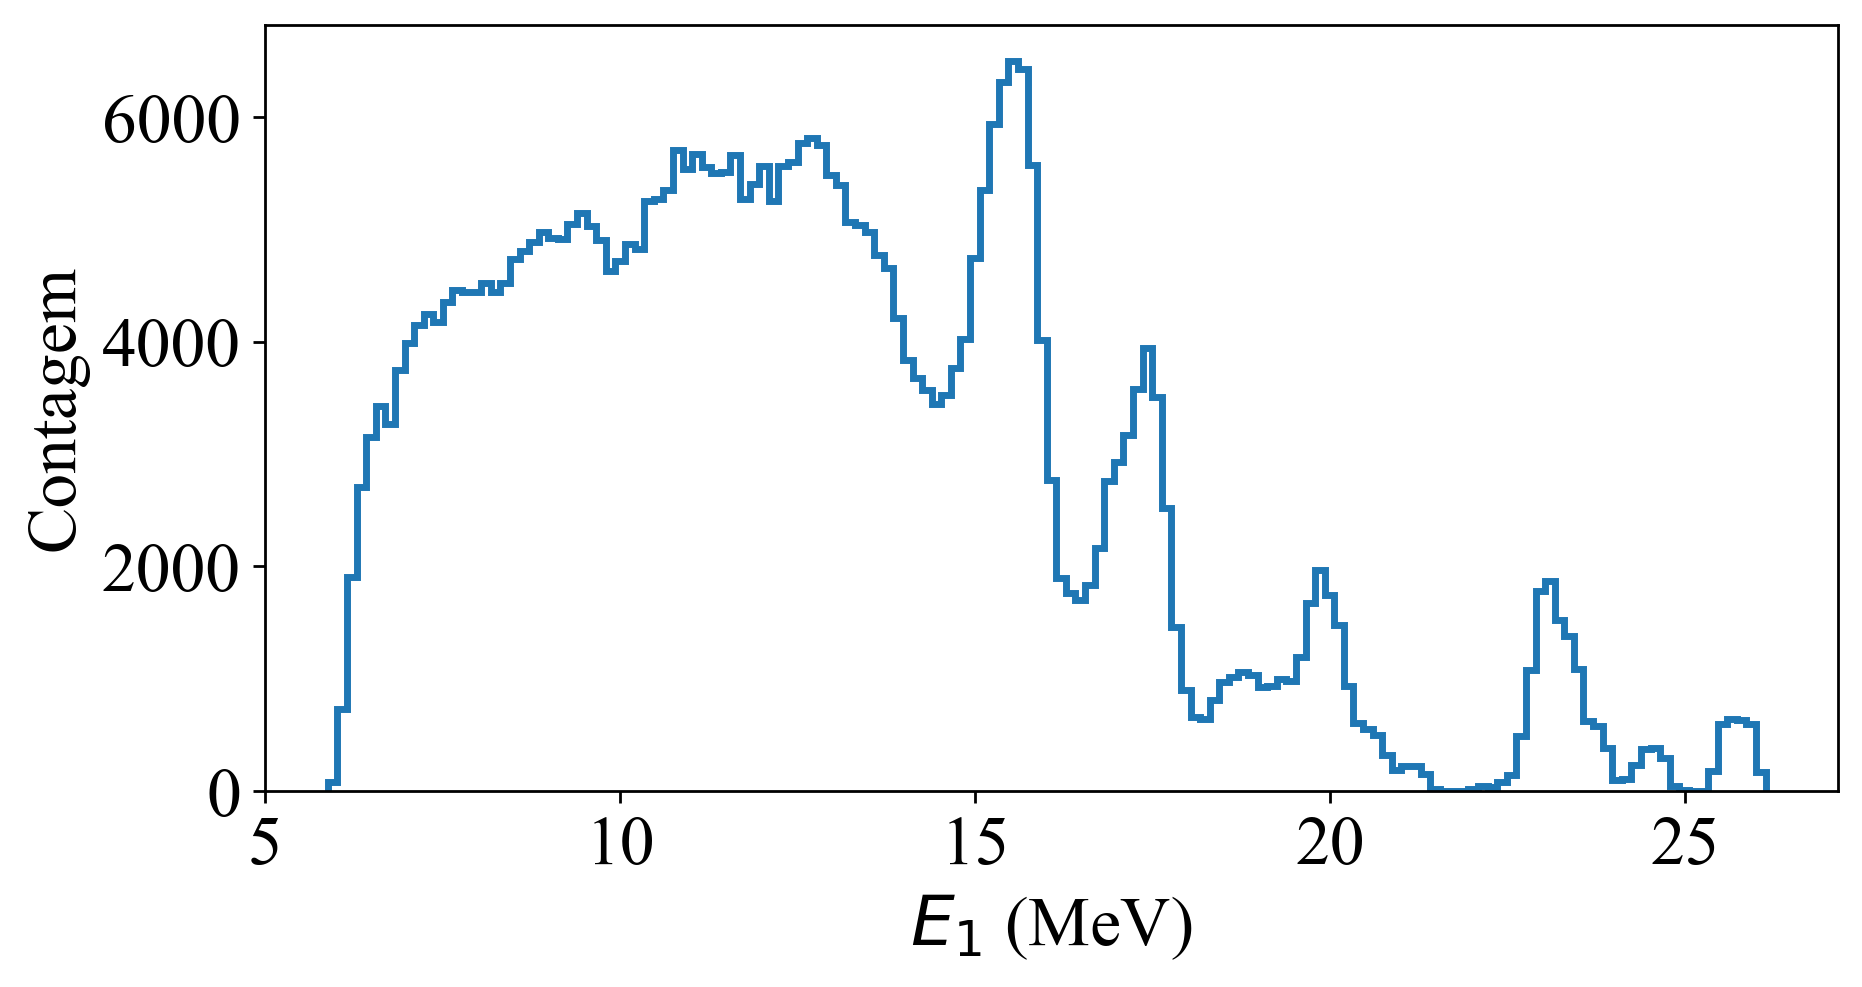

In [30]:
def DBS(dist, num):
    # Carrega os dados em X e os pesos em Y. X2 é uma lista auxiliar para futuramente anexar os
    # pesos por cluster futuramente (coisas relacionadas as diferenças de arrays e listas)
    X = np.load("r_hist2d.npy")
    w = np.load("w.npy")
    x2 = []
    for i in X:
        x2.append(i.tolist())
    X = StandardScaler(with_mean=False, with_std=False).fit_transform(X)
    
    # #############################################################################
    # Compute DBSCAN

    # Métricas possíveis: manhattann, cityblock, euclidian, l1, l2, cosine   
    # db = DBSCAN(eps=dist, min_samples=num, metric = 'l2').fit(X, sample_weight = w)
    # db = partial()
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    #prints abaixo retornam os resultados estatísticos de acertos
    print('Estimated number of clusters: %d' % n_clusters_)
    print('Estimated number of noise points: %d' % n_noise_)
    #print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
    #print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
    #print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
    #print("Adjusted Rand Index: %0.3f"
    #      % metrics.adjusted_rand_score(labels_true, labels))
    #print("Adjusted Mutual Information: %0.3f"
    #      % metrics.adjusted_mutual_info_score(labels_true, labels))
    
    # m = metrics.silhouette_score(X, labels)
    # print("Silhouette Coefficient: %0.3f" %m)
    
    unique_labels = set(labels)
    # colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    colors = ["blue", "red", "green", "orange"]
    fig = plt.figure(dpi = 250, figsize = (6.5, 4.5))
    fig.patch.set_facecolor('white')
    Sep = []
    cor = []
    pesos = []
    plt.xlabel("$E_T$ (MeV)")
    plt.ylabel("$\Delta$E (MeV)")
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            # col = [0, 0, 0, 1]
            col = "black"
    
        class_member_mask = (labels == k)
        
        xy = X[class_member_mask & core_samples_mask]
        # plt.scatter(xy[:, 0], xy[:, 1], color = tuple(col), marker = '.', s = 1, lw = 0)
        plt.scatter((xy[:, 1]*0.315 + xy[:, 0])*12.5/1e3, xy[:, 1]*3/1e3, c = col, marker = '.', s = 3, lw = 0, label = f"Conjunto {k + 1}")
        z = xy.tolist()
    
        xy = X[class_member_mask & ~core_samples_mask]
        # plt.scatter(xy[:, 0], xy[:, 1], color = tuple(col), marker = '.', s = 1, lw = 0)
        plt.scatter((xy[:, 1]*0.315 + xy[:, 0])*12.5/1e3, xy[:, 1]*3/1e3, c = col, marker = '.', s = 3, lw = 0)
        # Abaixo anexa os pontos de cada cluster percorrido em um array, depois guarda no Sep,
        # que armazenaum vetor que possui vetores 2D de cada cluster.
        prov = z + xy.tolist()
        z = np.array(prov)
        aux_pesos = []
        
        # Busca o índice que tem o ponto no arquivo original x2 para colocar o valor
        # correspondente do peso
        for i in prov:
            aux_pesos.append(w[x2.index(i)])
        pesos.append(aux_pesos)
        Sep.append(z)
        cor.append(col)
        
    
    # plt.title('Estimated number of clusters: %d Silhouette Coefficient = %0.3f'
    #           % (n_clusters_, m))
    lgnd = plt.legend(fontsize = 14, framealpha = 1., edgecolor = "black", loc = (0.005, .58))
    ssize = 120
    lgnd.legendHandles[0]._sizes = [ssize]
    lgnd.legendHandles[1]._sizes = [ssize]
    lgnd.legendHandles[2]._sizes = [ssize]
    lgnd.legendHandles[3]._sizes = [ssize]
    # plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))
    # plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.5))
    plt.xlim(left = 0.)
    plt.ylim(bottom = 0., top = 8.)
    plt.tight_layout()
    # plt.savefig("imagens/DBSCAN eps = %d samples = %d"%(dist, num), dpi = 600, bbox_inches='tight')
    plt.savefig("imagens/espectro_2.png", dpi = 600, bbox_inches='tight')
    plt.show()
    print(db.get_params())
    return Sep, cor, pesos
    
# As strings/comentários são parte da análise para diferentes valores de entrada

a, b, c = DBS(70, 420)

# for i in range(len(a)):
#     plt.figure(dpi = 140)
#     plt.xlabel("E")
#     plt.ylabel("$\Delta$E")
#     plt.title("Cluster de número %d"%i)
#     plt.grid(True)
#     # plt.scatter(a[i][:,0], a[i][:,1],  color = tuple(b[i]), marker = '.', lw = 0)
#     plt.scatter(a[i][:,0], a[i][:,1],  c = b[i], marker = '.', lw = 0, s = 6)
#     plt.show()
fig = plt.figure(dpi = 250, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
plt.hist((a[0][:, 1]*0.315 + a[0][:, 0])*12.5/1e3, weights = c[0], bins = 150, histtype = 'step', lw = 2)
# plt.title("Contagem x E1")
plt.xlabel("$E_{1}$ (MeV)")
plt.ylabel("Contagem")
plt.ylim(bottom = 0.)
# plt.xlim(left = 0., right = 2.)
plt.xlim(left = 5.)
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(0.5))
plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2000))
plt.tight_layout()
plt.savefig("imagens/espectro_3.png", dpi = 600, bbox_inches='tight')
plt.show()


# CNN Segmentação

In [34]:
target_n_peaks_img, index_n = construct_target_n_peaks_img(peaksDeconv, min_peak = 1, max_peak = 6, extra_points = 2)
print(target_n_peaks_img.shape)
# 18800, 148, 110413, 21484, 60334

(150030,)
(150030, 512)


Saída num = 21484
[323 334 346 359 372 383]


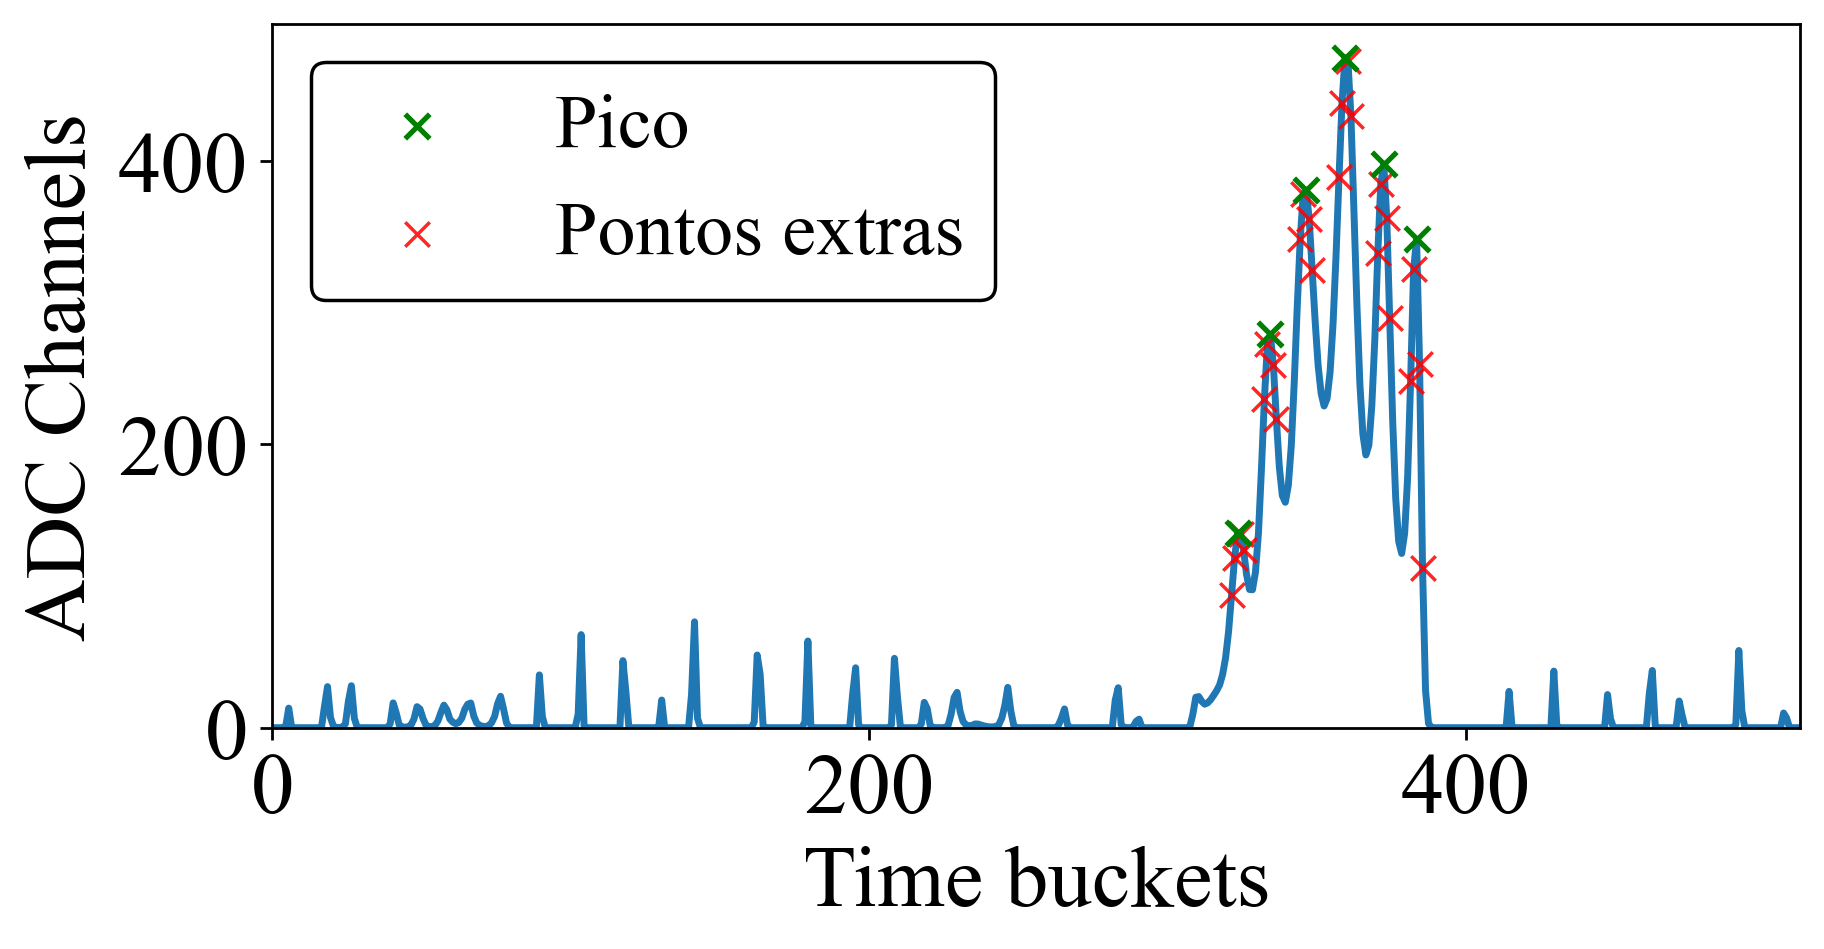

In [18]:
fig = plt.figure(dpi = 250, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# num = np.random.randint(low = 0, high = len(index_n), size = 1)[0]
num = 21484
# num = 136780
# recorte = target_n_peaks_img[num].astype(int)
a = fp(y2_scaled[num].reshape(-1), 100., distance = 4, prominence = 4)[0]
recorte = construct_target_n_peak_img(a)
recorte = np.where(recorte > 0)[0]
# print(recorte)
# num2 = index_n[num]
num2 = num
print(f"Saída num = {num}")
# picos_deconv = peaksDeconv[num2].astype(float).round().astype(int)
print(a)
picos_dencov = np.copy(a)
# fig = plt.figure(dpi = 250, figsize = (12, 4.5))
fig.patch.set_facecolor('white')
plt.plot(xt, y2_scaled[num2], lw = 2, ls = "-", alpha = 1., zorder = 1)
plt.scatter(xt[a], y2_scaled[num2][a], marker = "x",
            lw = 1.5, zorder = 3, alpha = 1., s = 50, c = "green", label = "Pico")
plt.scatter(xt[recorte], y2_scaled[num2][recorte], marker = "x",
            lw = 1., zorder = 2, alpha = 0.85, s = 50, c = "red", label = "Pontos extras")
# plt.legend(fontsize = fonte, framealpha = 1., edgecolor = "black", loc = 0)
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte - 5) # Size here overrides font_prop
plt.xlim(left = 0., right = 512.)
plt.ylim(bottom = 0.)
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(700))
plt.xlabel("Time buckets")
plt.ylabel("ADC Channels")
plt.legend(framealpha = 1., edgecolor = "black", fontsize = 22)
plt.tight_layout()
plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/np_ex1.png", dpi = 600, bbox_inches='tight')
plt.show()

In [59]:
def load2():
    arrays = np.load("./dados/arrays.npz", allow_pickle = True)['arr_0']
    picos  = np.load("./dados/picos.npy", allow_pickle = True)
    return arrays, picos
arrays, picos = load2()

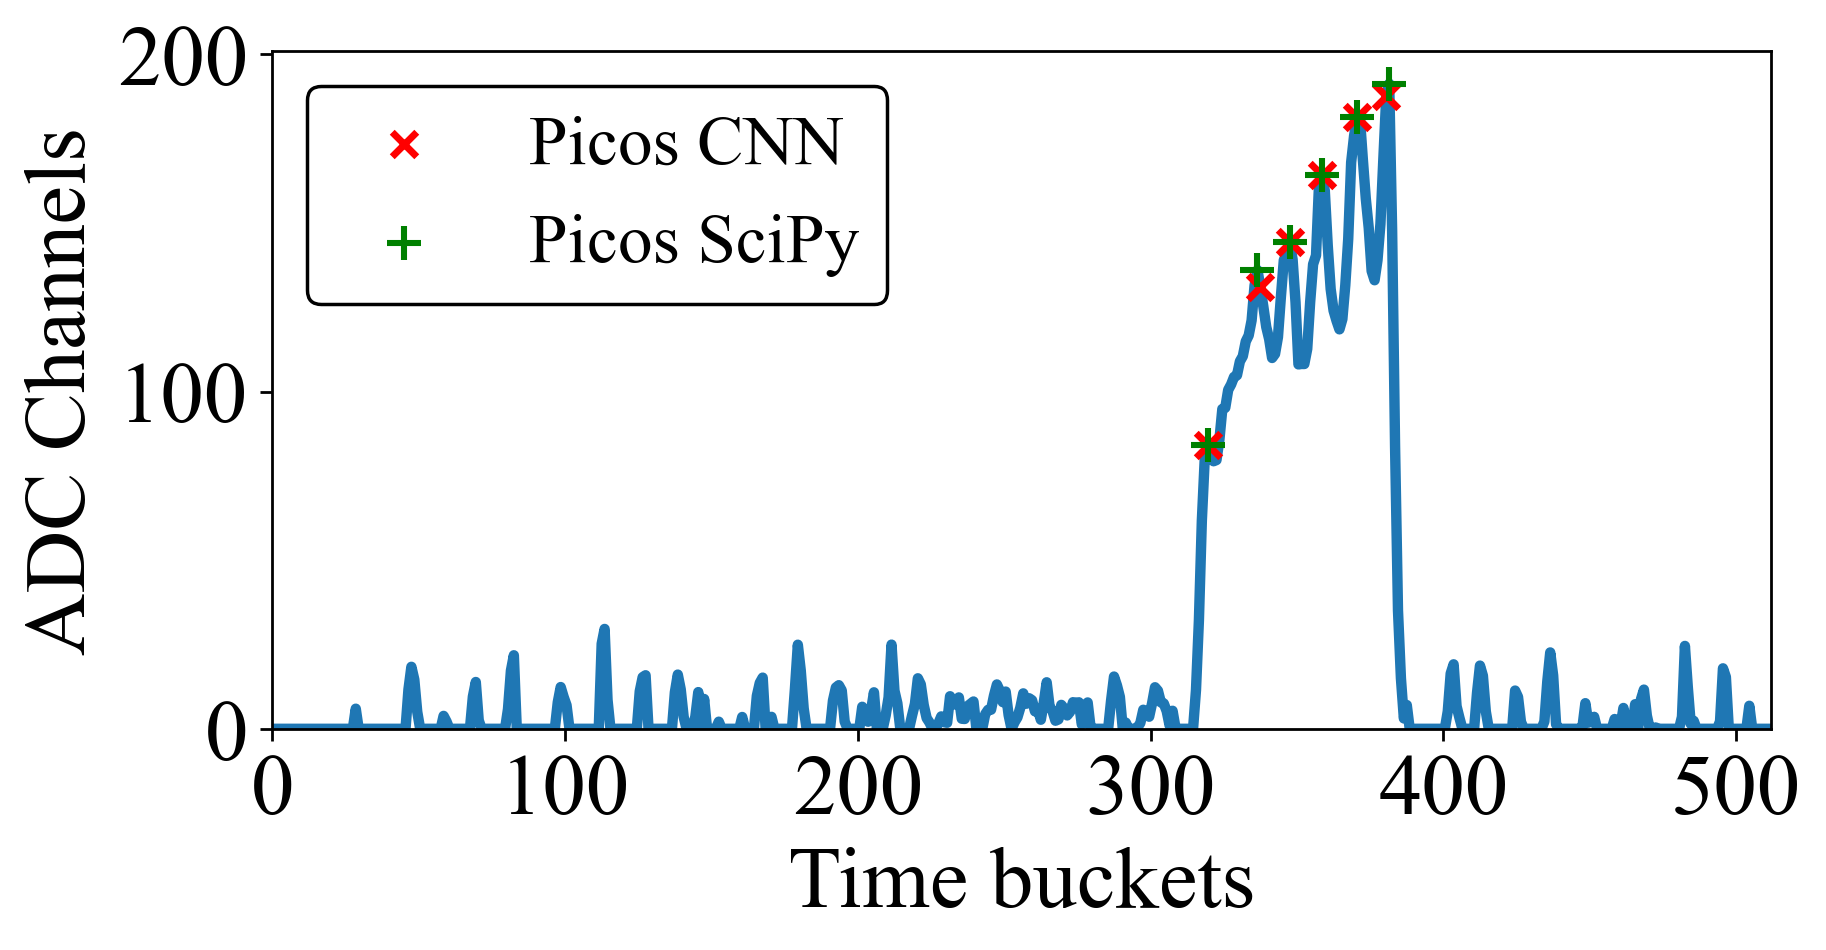

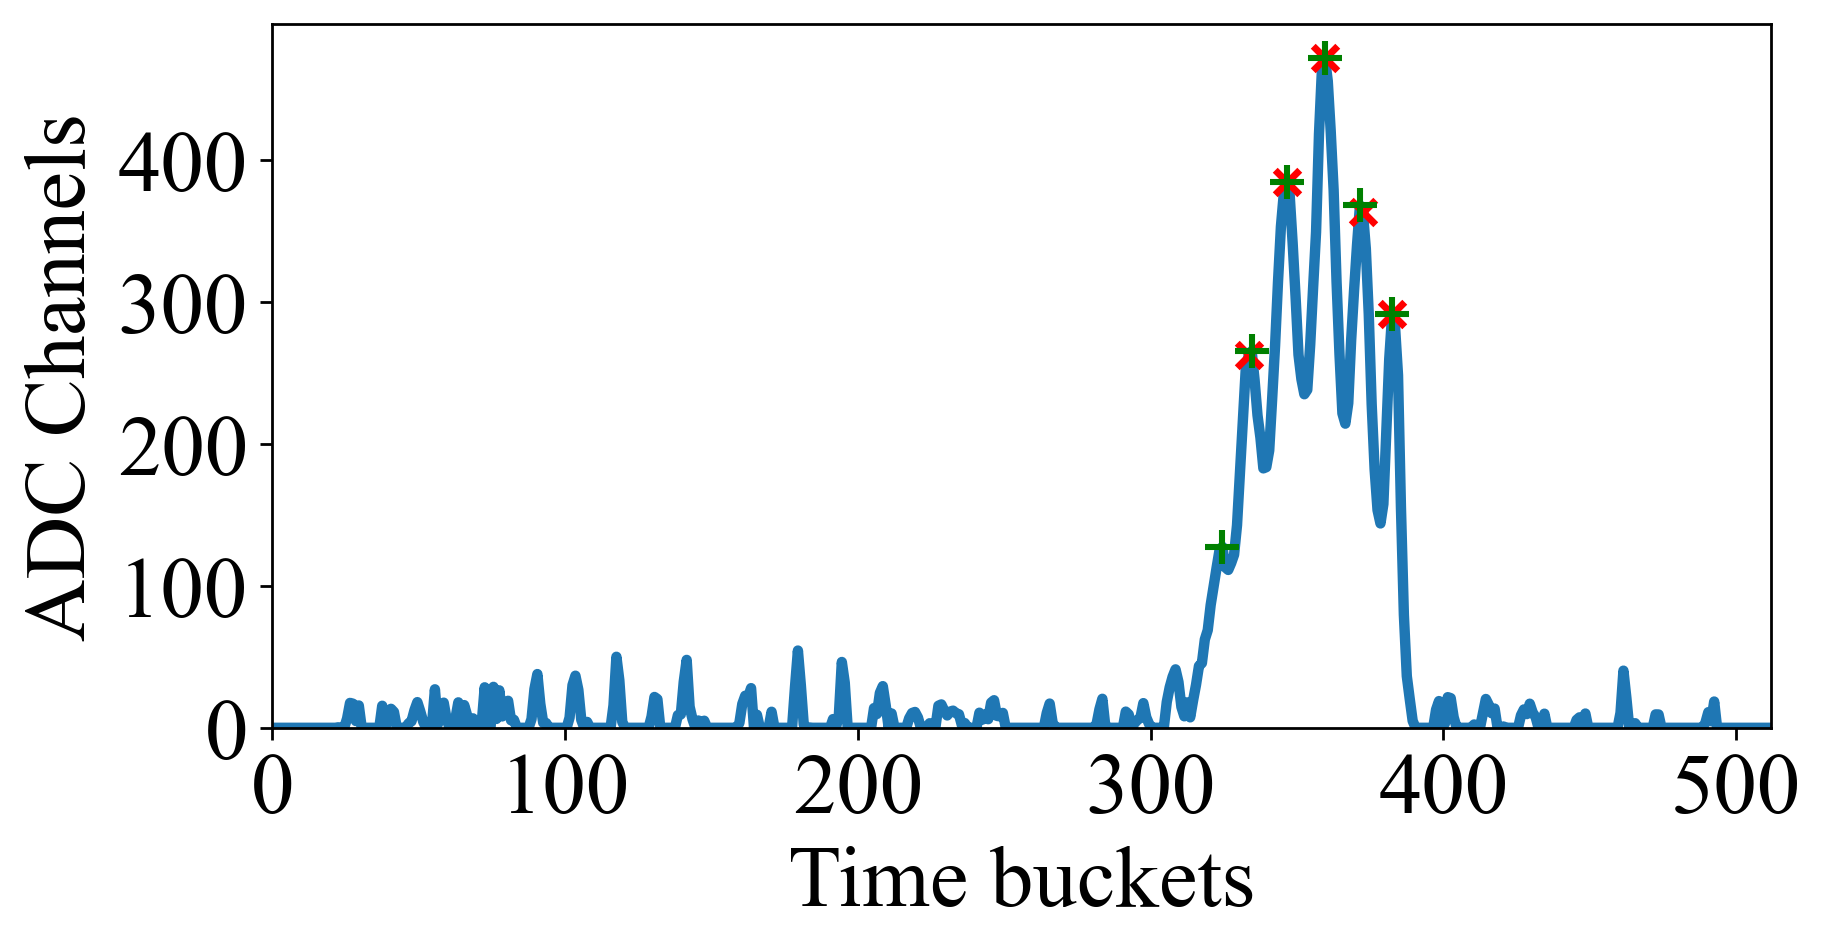

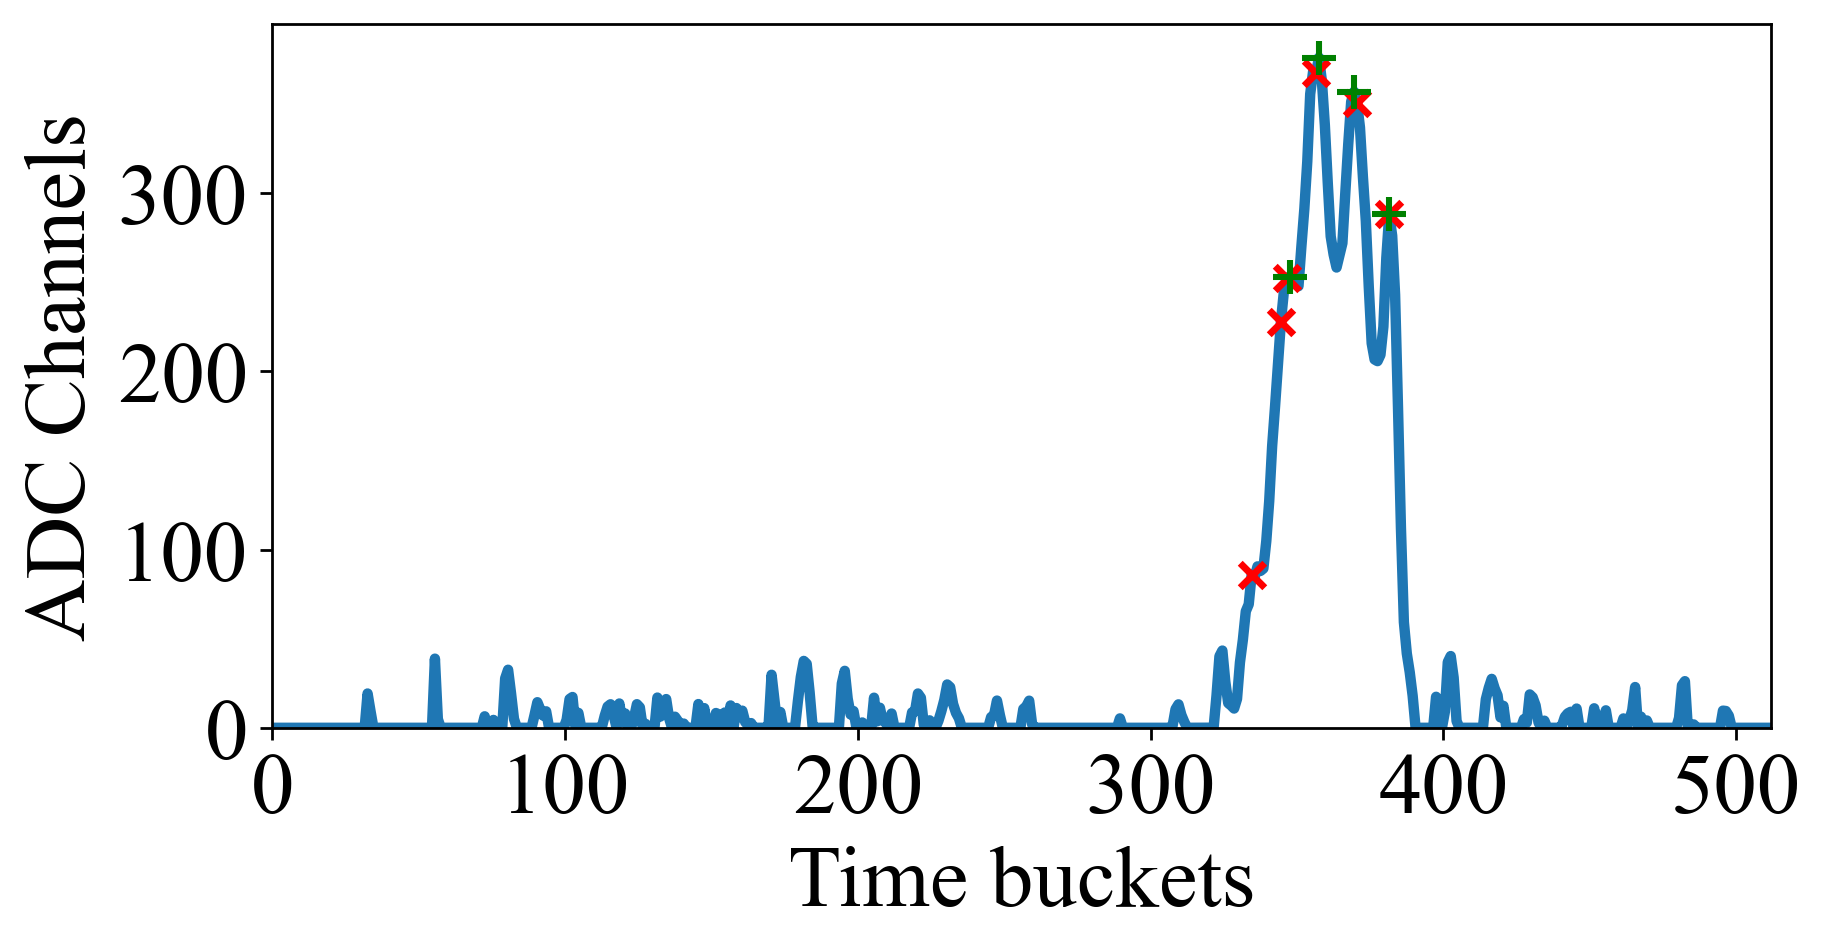

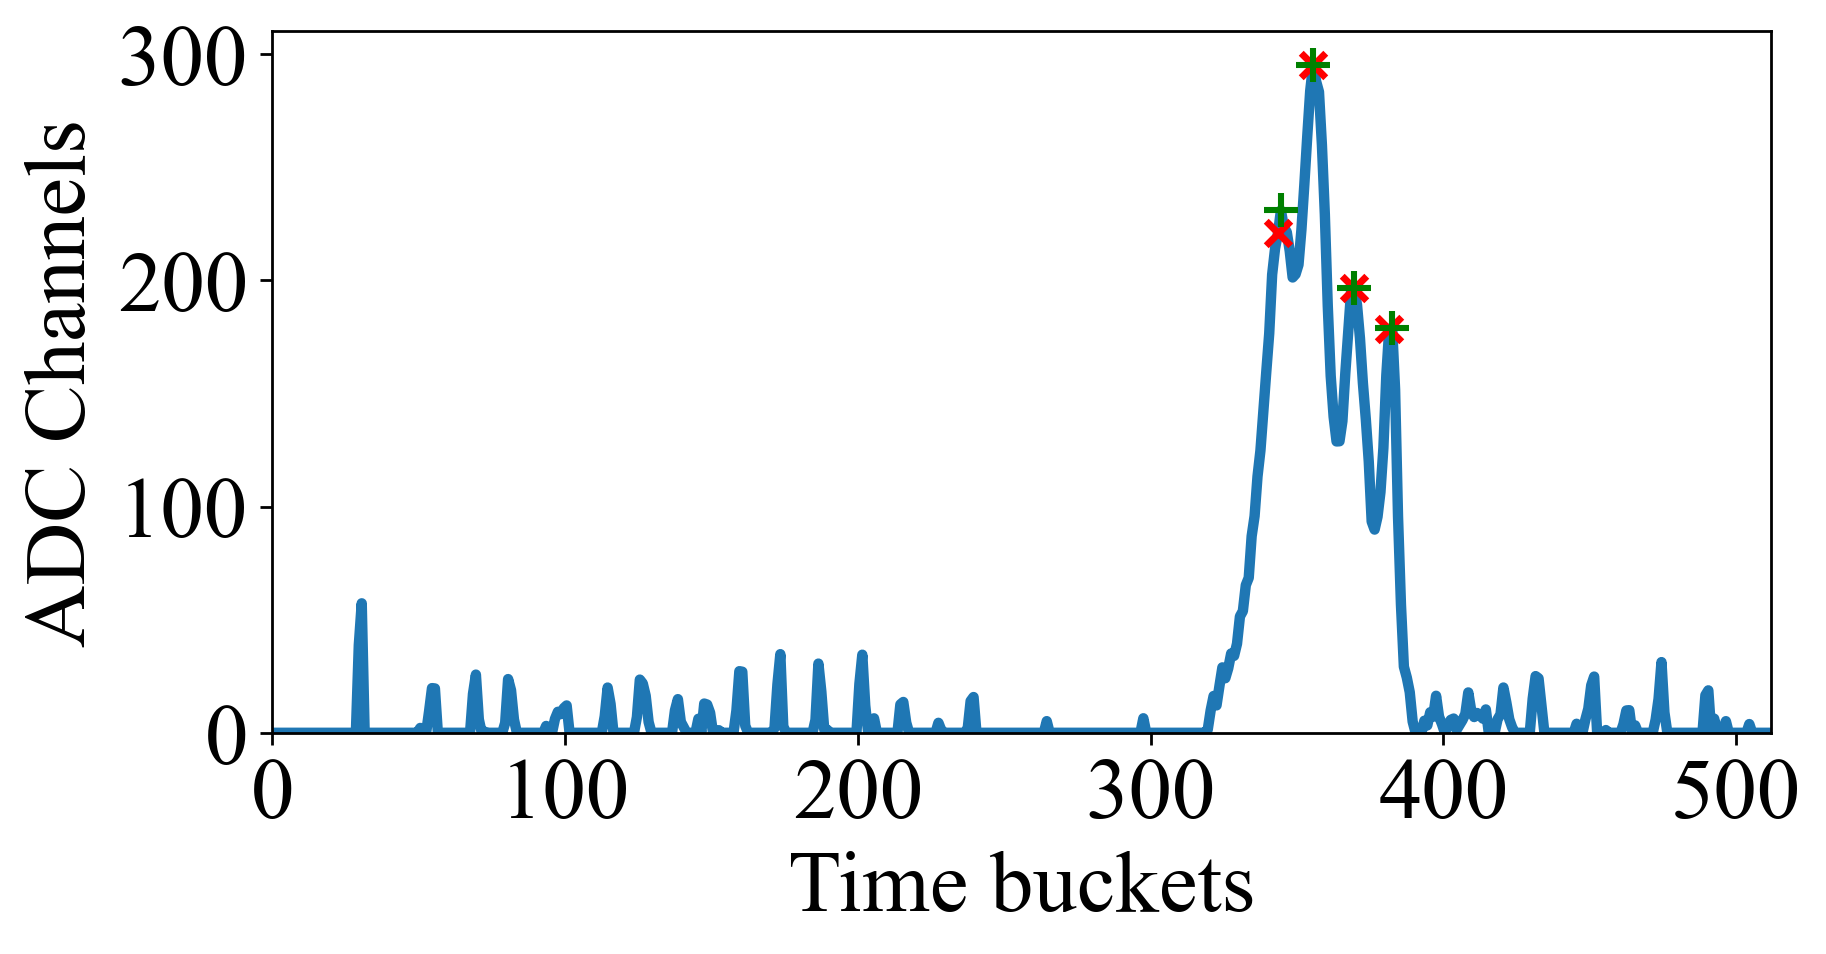

In [62]:
# for i in range(len(picos)):
    # for i in [0, 2, 143, 148]:
d = {0 : 1, 21484 : 2, 143 : 3, 148 : 4}
# fig = plt.figure(dpi = 200)
# i = 143
# fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, dpi = 220, figsize = (15, 8))
# ax1.plot(xt, arrays[i][512:])
# peaks = np.array(picos[i]).astype(float).round().astype(int)
# a = len(peaks)
# ax1.plot(xt[peaks], arrays[i][peaks + 512], "x", color = "red")
# peaks = fp(arrays[i][512:], height = 70., distance = 4, prominence = 4)[0]
# b = len(peaks)
# print(f"Razão = {b / a}")
# ax1.plot(xt[peaks], arrays[i][peaks + 512], "d", color = "purple")
# ax2.plot(arrays[i][:512])
# plt.show()
for i in d.keys():
    peaks = np.array(picos[i]).astype(float).round().astype(int)
    if i == 148:
        peaks = peaks[np.array([0, 2, 3, 4], dtype = int)]
    fig = plt.figure(dpi = 250, figsize = (8, 4.5))
    fig.patch.set_facecolor('white')
    peaks_sci = fp(arrays[i][512:], height = 70., distance = 4, prominence = 4)[0]
    plt.plot(xt, arrays[i][512:], lw = 3., zorder = 0)
    plt.scatter(xt[peaks], arrays[i][peaks + 512], marker = "x", color = "red", lw = 2., s = 50, zorder = 1, label = "Picos CNN")
    plt.scatter(xt[peaks_sci], arrays[i][peaks_sci + 512], marker = "+", color = "green", lw = 1.75, s = 100, zorder = 1, label = "Picos SciPy")
    plt.xlim(left = 0, right = 512)
    plt.ylim(bottom = 0.)
    plt.xticks([0, 100, 200, 300, 400, 500])
    if i == 0:
        plt.legend(framealpha = 1., edgecolor = "black", fontsize = 20)
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(100))
    plt.xlabel("Time buckets")
    plt.ylabel("ADC Channels")
    plt.tight_layout()
    plt.savefig(f"D:/Documentos/Dissertacao_V1/Tese/figs/np_exs{d[i]}.png", dpi = 600, bbox_inches='tight')
    plt.show()

# Loss e metrica x epoch segmentação

In [25]:
# df = pd.read_csv("./dados/DECONVCNN_BKG_TO_DECONV_700.csv")
df = pd.read_csv("./dados/DECONVCNN_TO_N_PEAKS.csv")

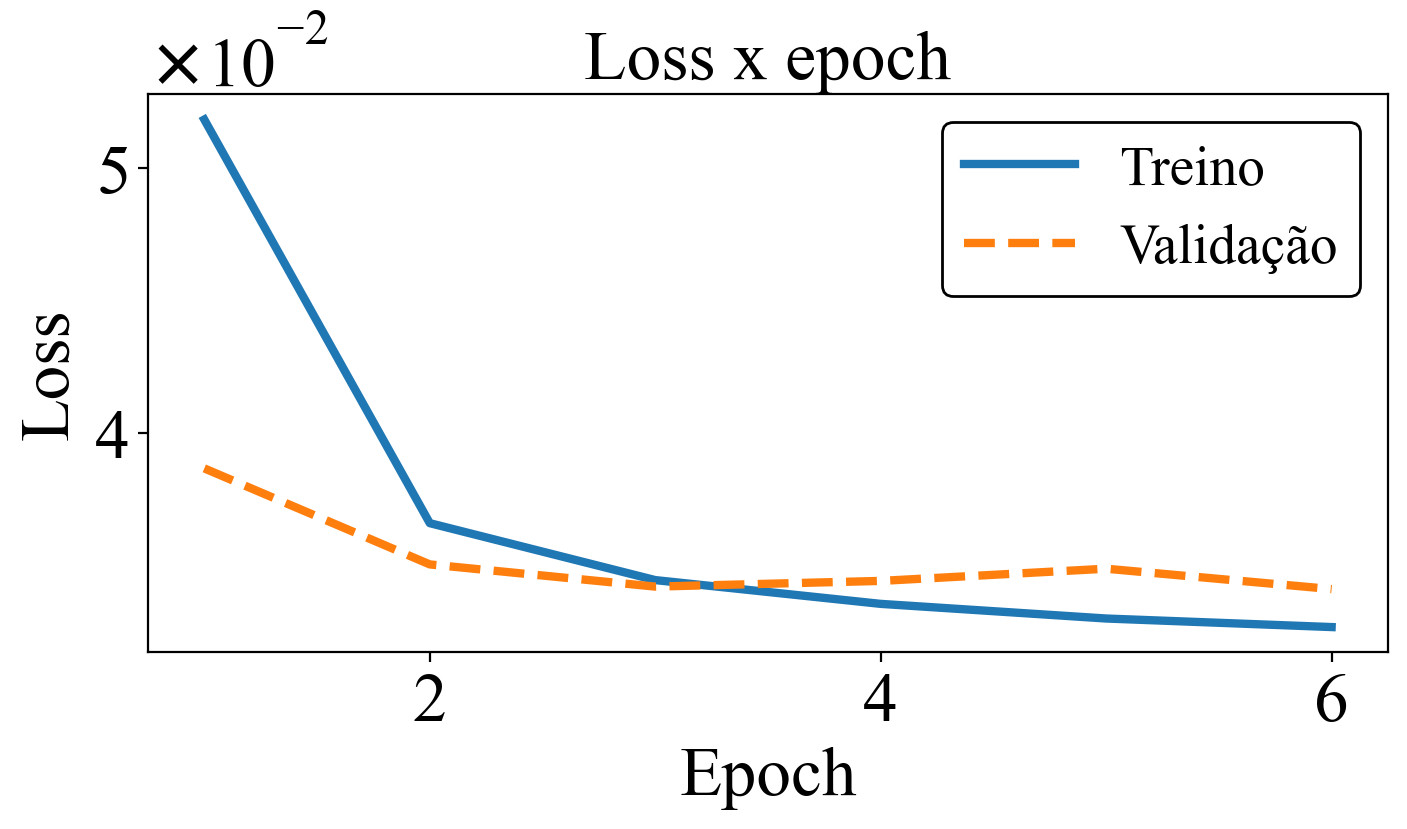

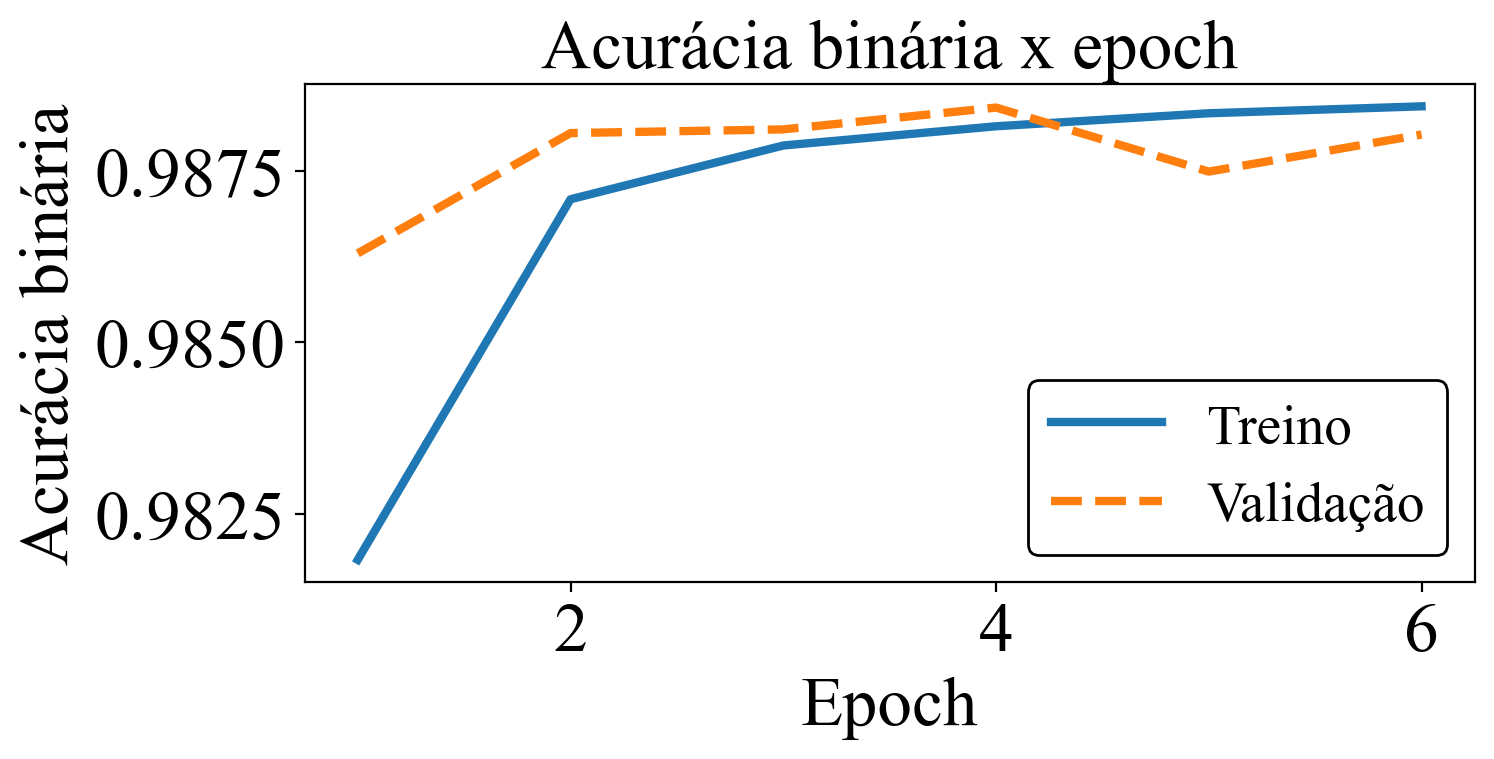

In [38]:
fonte = 22
fig = plt.figure(dpi = 200, figsize = (8, 4.85))
fig.patch.set_facecolor('white')
plt.plot(np.arange(1, len(df) + 1, 1), df["loss"], lw = 3, label = "Treino")
plt.plot(np.arange(1, len(df) + 1, 1), df["val_loss"], ls = "--", lw = 3, label = "Validação")
# plt.xlabel("Epoch", fontsize = fonte)
# plt.ylabel("Loss", fontsize = fonte)
plt.xlabel("Epoch")
plt.ylabel("Loss")
# scale_y = 1e3
# ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
# fig.gca().yaxis.set_major_formatter(ticks_y)
plt.ticklabel_format(axis = "y", style = "sci", scilimits=(3, 4), useMathText = True)
plt.title("Loss x epoch")
plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black")
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(3000))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
plt.tight_layout()
# plt.savefig(f"imagens/source_wo_bkg_to_deconv_loss.png", dpi = 600, bbox_inches='tight')
plt.savefig(f"imagens/n_peaks_loss.png", dpi = 600, bbox_inches='tight')
plt.show()

fig = plt.figure(dpi = 200, figsize = (8, 4.5))
fig.patch.set_facecolor('white')
# plt.plot(np.arange(1, len(df) + 1, 1), df["mean_absolute_error"], lw = 3, label = "Treino")
# plt.plot(np.arange(1, len(df) + 1, 1), df["val_mean_absolute_error"], ls = "--", lw = 3, label = "Validação")
plt.plot(np.arange(1, len(df) + 1, 1), df["binary_accuracy"], lw = 3, label = "Treino")
plt.plot(np.arange(1, len(df) + 1, 1), df["val_binary_accuracy"], ls = "--", lw = 3, label = "Validação")
plt.xlabel("Epoch")
plt.ylabel("Acurácia binária")
plt.title("Acurácia binária x epoch")
plt.legend(fontsize = fonte - 2, framealpha = 1., edgecolor = "black")
# for label in (fig.gca().get_xticklabels() + fig.gca().get_yticklabels()):
#     # label.set_fontproperties(font_prop)
#     label.set_fontsize(fonte) # Size here overrides font_prop
# plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(2))
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.tight_layout()
# plt.savefig(f"imagens/source_wo_bkg_to_deconv_metric.png", dpi = 600, bbox_inches='tight')
plt.savefig(f"imagens/n_peaks_metric.png", dpi = 600, bbox_inches='tight')
plt.show()